In [1]:
import sys
sys.path.append('/home/xinyiz/pamrats')

In [2]:
##This is adapted from https://github.com/tkipf/gae/blob/master/gae/train.py and https://github.com/tkipf/pygcn/blob/master/pygcn/train.py##

import time
import os

# Train on CPU (hide GPU) due to memory constraints
# os.environ['CUDA_VISIBLE_DEVICES'] = ""

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim

# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import average_precision_score

import gae.gae.optimizer as optimizer
import gae.gae.model
import gae.gae.preprocessing as preprocessing

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Settings
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
use_cuda=True
fastmode=False #Validate during training pass
seed=3
useSavedMaskedEdges=True
maskedgeName='knn20_connectivity'
epochs=10000
saveFreq=10
lr=0.001 #initial learning rate
lr_adv=0.001
weight_decay=0 #Weight for L2 loss on embedding matrix.

hidden1=1024 #Number of units in hidden layer 1
hidden2=1024 #Number of units in hidden layer 2
# hidden3=2048
# hidden4=2048
# hidden5=128
fc_dim1=1024
# fc_dim2=128
# fc_dim3=128
# fc_dim4=128
# gcn_dim1=2600
# clf_hidden=256
adv_hidden=128

dropout=0.01
testNodes=0.1 #fraction of total nodes for testing
valNodes=0.05 #fraction of total nodes for validation
XreconWeight=20
# clfweight=20
advWeight=2
# randFeatureSubset=None
model_str='gcn_vae_xa_e2_d1_dca'
clf=None
adv=None  #'clf_fc1_control_eq' #'clf_fc1_control'  #'clf_fc1'
protein=None #'scaled_binary'
proteinWeights=0.05
adj_decodeName=None #gala or None
ridgeL=0.01
shareGenePi=True

pretrainedAE=None #{'name':'controlphy5XAbin_01_dca','epoch':9990}
num_features=2112
# training_samples=['control13','disease13','disease8']###rename and retrain C8
training_samples=['control13','disease13','disease8','control8']
# training_samples=['control13','control8']
targetBatch=None
training_sample_X='logminmax'
switchFreq=100
standardizeX=False
# name='allk20XA_01_dca_noD8' ###rename and retrain D8 C8
name='allk20XA_01_dca_NB'
logsavepath='/mnt/xinyi/pamrats/log/train_gae_starmap/'+name
modelsavepath='/mnt/xinyi/pamrats/models/train_gae_starmap/'+name
plotsavepath='/mnt/xinyi/pamrats/plots/train_gae_starmap/'+name

#Load data
sampleidx={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}
savedir=os.path.join('/mnt/xinyi/','starmap')
adj_dir=os.path.join(savedir,'a')

featureslist={}
if training_sample_X in ['corrected','scaled']:
    scaleddata=scanpy.read_h5ad('/mnt/xinyi/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-scaled.h5ad')
    
    for s in sampleidx.keys():
        featureslist[s+'X_'+'corrected']=torch.tensor(scaleddata.layers['corrected'][scaleddata.obs['sample']==sampleidx[s]])
        featureslist[s+'X_'+'scaled']=torch.tensor(scaleddata.layers['scaled'][scaleddata.obs['sample']==sampleidx[s]])

else:
    scaleddata=scanpy.read_h5ad('/mnt/xinyi/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-raw.h5ad')
    
    for s in sampleidx.keys():
        scaleddata_train=scaleddata.X[scaleddata.obs['sample']==sampleidx[s]]

        if training_sample_X=='logminmax':
            featurelog_train=np.log2(scaleddata_train+1/2)
            scaler = MinMaxScaler()
            featurelog_train_minmax=np.transpose(scaler.fit_transform(np.transpose(featurelog_train)))
            featureslist[s+'X_'+training_sample_X]=torch.tensor(featurelog_train_minmax)
        elif training_sample_X=='logminmax10':
            featurelog_train=np.log2(scaleddata_train+1/2)
            scaler = MinMaxScaler(feature_range=(0,10))
            featurelog_train_minmax=np.transpose(scaler.fit_transform(np.transpose(featurelog_train)))
            featureslist[s+'X_'+training_sample_X]=torch.tensor(featurelog_train_minmax)

if protein:
    proteinsavepath=os.path.join('/mnt/xinyi/','starmap','protein')
    for s in sampleidx.keys():
        pmtx=sp.load_npz(os.path.join(proteinsavepath,sampleidx[s]+'_'+protein+'.npz'))
        pmtx=preprocessing.sparse_mx_to_torch_sparse_tensor(pmtx)
        pmtx=pmtx.to_dense()
        scalefactor=torch.sum(featureslist[s+'X_'+training_sample_X])/torch.sum(pmtx)*proteinWeights
        featureslist[s+'X_'+training_sample_X]=torch.cat((featureslist[s+'X_'+training_sample_X],pmtx*scalefactor),dim=1)
            
if clf:
    ctlist={}
    ctlist['disease13']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9494','top_level'].to_numpy()
    ctlist['control13']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9498','top_level'].to_numpy()
    ctlist['disease8']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9723','top_level'].to_numpy()
    ctlist['control8']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9735','top_level'].to_numpy()
    ct_unique=np.unique(scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9735','top_level'])
    for k in ctlist.keys():
        for i in range(ct_unique.size):
            ctlist[k][ctlist[k]==ct_unique[i]]=i
    
adj_list={}
adj_list['disease13']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9494.npz'))
adj_list['control13']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9498.npz'))
adj_list['disease8']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9723.npz'))
adj_list['control8']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9735.npz'))

adjnormlist={}
pos_weightlist={}
normlist={}
for ai in adj_list.keys():
    adjnormlist[ai]=preprocessing.preprocess_graph(adj_list[ai])
    
    pos_weightlist[ai] = torch.tensor(float(adj_list[ai].shape[0] * adj_list[ai].shape[0] - adj_list[ai].sum()) / adj_list[ai].sum()) #using full unmasked adj
    normlist[ai] = adj_list[ai].shape[0] * adj_list[ai].shape[0] / float((adj_list[ai].shape[0] * adj_list[ai].shape[0] - adj_list[ai].sum()) * 2)
    
    adj_label=adj_list[ai] + sp.eye(adj_list[ai].shape[0])
    adj_list[ai]=torch.tensor(adj_label.todense())
    
if adv:
    if 'control_eq' in adv:
        sampleLabellist_ae={}
        sampleLabellist_ae['control13']=torch.tensor([0.5,0.5]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_ae['control8']=torch.tensor([0.5,0.5]).expand(adjnormlist['control8'].shape[0],-1)

        sampleLabellist_d={}
        sampleLabellist_d['control13']=torch.tensor([1,0]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_d['control8']=torch.tensor([0,1]).expand(adjnormlist['control8'].shape[0],-1)
    elif 'control' in adv:
        sampleLabellist_ae={}
        sampleLabellist_ae['control13']=torch.tensor([0,1]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_ae['control8']=torch.tensor([1,0]).expand(adjnormlist['control8'].shape[0],-1)

        sampleLabellist_d={}
        sampleLabellist_d['control13']=torch.tensor([1,0]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_d['control8']=torch.tensor([0,1]).expand(adjnormlist['control8'].shape[0],-1)        
    else:
        sampleLabellist_ae={}
        sampleLabellist_ae['disease13']=torch.tensor([0,1,1,1]).expand(adjnormlist['disease13'].shape[0],-1)
        sampleLabellist_ae['control13']=torch.tensor([1,0,1,1]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_ae['disease8']=torch.tensor([1,1,0,1]).expand(adjnormlist['disease8'].shape[0],-1)
        sampleLabellist_ae['control8']=torch.tensor([1,1,1,0]).expand(adjnormlist['control8'].shape[0],-1)

        sampleLabellist_d={}
        sampleLabellist_d['disease13']=torch.tensor([1,0,0,0]).expand(adjnormlist['disease13'].shape[0],-1)
        sampleLabellist_d['control13']=torch.tensor([0,1,0,0]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_d['disease8']=torch.tensor([0,0,1,0]).expand(adjnormlist['disease8'].shape[0],-1)
        sampleLabellist_d['control8']=torch.tensor([0,0,0,1]).expand(adjnormlist['control8'].shape[0],-1)
        
    
        
    
# adj_decode=None
# if adj_decodeName == 'gala':
#     adj_decode=preprocessing.preprocess_graph_sharp(adj_train)



if 'dca' in model_str:
    rawdata=scanpy.read_h5ad('/mnt/xinyi/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-raw.h5ad')
    features_raw_list={}
    for s in sampleidx.keys():
#         features_raw_list[s+'X_'+'raw']=torch.tensor(rawdata.X[rawdata.obs['sample']==sampleidx[s]]).cuda()
        features_raw_list[s+'X_'+'raw']=torch.tensor(rawdata.X[rawdata.obs['sample']==sampleidx[s]])
        if protein:
            proteinsavepath=os.path.join('/mnt/xinyi/','starmap','protein')
            pmtx=sp.load_npz(os.path.join(proteinsavepath,sampleidx[s]+'_'+protein+'.npz'))
            pmtx=preprocessing.sparse_mx_to_torch_sparse_tensor(pmtx)
            pmtx=pmtx.to_dense()
            scalefactor=torch.sum(features_raw_list[s+'X_raw'])/torch.sum(pmtx)*proteinWeights
            features_raw_list[s+'X_raw']=torch.cat((features_raw_list[s+'X_raw'],pmtx*scalefactor),dim=1)

if clf:
    ct_train=ctlist[training_samples].astype(int)
# features=torch.tensor(np.identity(7000)).float()
# features=features[0:10,:]
if standardizeX:
    features=torch.tensor(scale(features,axis=0, with_mean=True, with_std=True, copy=True))

# Set cuda and seed
np.random.seed(seed)
if use_cuda and (not torch.cuda.is_available()):
    print('cuda not available')
    use_cuda=False
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True

# Load data
# if randFeatureSubset != None:
#     idx=np.random.choice(features.shape[1],randFeatureSubset,replace=False)
#     features=features[:,idx]


In [4]:
if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)

In [5]:
# loop over all train/validation sets

mse=torch.nn.MSELoss()
# mse=torch.nn.MSELoss(reduction=None)
# Create model
if model_str=='gcn_vae_xa':
    model = gae.gae.model.GCNModelVAE_XA(num_features, hidden1, hidden2,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
elif model_str == 'gcn_vae_gcnX_inprA':
    model = gae.gae.model.GCNModelVAE_gcnX_inprA(num_features, hidden1, hidden2,gcn_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
    
elif model_str == 'gcn_vae_gcnX_inprA_w':
    model = gae.gae.model.GCNModelVAE_gcnX_inprA_w(num_features, hidden1, hidden2,gcn_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE    
    
elif model_str=='gcn_vae_xa_e3':
    model = gae.gae.model.GCNModelVAE_XA_e3(num_features, hidden1, hidden2,hidden3,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
    
elif model_str == 'gcn_vae_xa_e1':
    model = gae.gae.model.GCNModelVAE_XA_e1(num_features, hidden1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE

elif model_str == 'gcn_vae_xa_e2_d1':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1(num_features, hidden1,hidden2, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
    
elif model_str=='gcn_vae_xa_e2_d1_dca':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCA(num_features, hidden1,hidden2,fc_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE

elif model_str=='gcn_vae_xa_e2_d1_dcaFork':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCAfork(num_features, hidden1,hidden2,fc_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE

elif model_str=='gcn_vae_xa_e2_d1_dcaElemPi':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCAelemPi(num_features, hidden1,hidden2,fc_dim1, dropout,shareGenePi)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE

elif model_str=='gcn_vae_xa_e2_d1_dcaConstantDisp':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCA_constantDisp(num_features, hidden1,hidden2,fc_dim1, dropout,shareGenePi)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE    
    
elif model_str == 'gcn_vae_xa_e4_d1':
    model = gae.gae.model.GCNModelVAE_XA_e4_d1(num_features, hidden1,hidden2,hidden3,hidden4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE    
    
elif model_str=='fc':
    model = gae.gae.model.FCVAE(num_features, hidden1, hidden2,hidden3,hidden4,hidden5,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
#     loss_x=mse
    loss_a=optimizer.optimizer_CE
elif model_str=='fcae':
    model = gae.gae.model.FCAE(num_features, hidden1, hidden2,hidden3,hidden4,hidden5,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_x=optimizer.optimizer_MSE
#     loss_x=mse

elif model_str=='fcae1':
    model = gae.gae.model.FCAE1(num_features, dropout,hidden1)
    loss_x=optimizer.optimizer_MSE
#     loss_x=mse
elif model_str=='fcae2':
    model = gae.gae.model.FCAE2(num_features, dropout,hidden1,hidden2)
    loss_x=optimizer.optimizer_MSE

elif model_str=='fc1':
    model = gae.gae.model.FCVAE1(num_features, hidden1,dropout)
    loss_x=optimizer.optimizer_MSE
    loss_kl=optimizer.optimizer_kl
    loss_a=optimizer.optimizer_CE

elif model_str=='fc1_dca':
    model = gae.gae.model.FCVAE1_DCA(num_features, hidden1,fc_dim1, dropout)
    loss_x=optimizer.optimizer_zinb
    loss_kl=optimizer.optimizer_kl
    loss_a=optimizer.optimizer_CE

if clf=='clf_fc1':
    modelClf=gae.gae.model.Clf_fc1(hidden2, dropout,clf_hidden,ct_unique.size)
    loss_clf=torch.nn.CrossEntropyLoss()
    
if adv=='clf_fc1' or adv=='clf_fc1_control' or adv=='clf_fc1_control_eq':
    modelAdv=gae.gae.model.Clf_fc1(hidden2, dropout,adv_hidden,sampleLabellist_ae['control13'].size()[1])
    loss_adv=optimizer.optimizer_CEclf
    
if adv=='clf_linear1' or adv=='clf_linear1_control':
    modelAdv=gae.gae.model.Clf_linear1(hidden2, dropout,sampleLabellist_ae['control13'].size()[1])
    loss_adv=optimizer.optimizer_CEclf
    
if 'NB' in name:
    print('using NB loss for X')
    loss_x=optimizer.optimizer_nb
    
if use_cuda:
    model.cuda()
    if clf:
        modelClf.cuda()
        ct_train=torch.tensor(ct_train).cuda()
    if adv:
        modelAdv.cuda()
#         for sk in sampleLabellist_ae.keys():
#             sampleLabellist_ae[sk]=sampleLabellist_ae[sk].cuda().float()
#             sampleLabellist_d[sk]=sampleLabellist_d[sk].cuda().float()
#     for fk in featureslist.keys():
#         featureslist[fk] = featureslist[fk].cuda().float()
#     for ak in adj_list.keys():
#         adjnormlist[ak] =adjnormlist[ak].cuda()
#         adj_list[ak] = adj_list[ak].cuda().float()
#     if adj_decode is not None:
#         adj_decode=adj_decode.cuda()
    

optimizerVAEXA = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
if clf:
    optimizerClf=optim.Adam(modelClf.parameters(), lr=lr, weight_decay=weight_decay)
if adv:
    optimizerAdv=optim.Adam(modelAdv.parameters(), lr=lr_adv, weight_decay=weight_decay)    


using NB loss for X


In [6]:
# model.load_state_dict(torch.load(os.path.join(modelsavepath,str(19990)+'.pt')))
# epochs=40000
if pretrainedAE:
    print('loading '+pretrainedAE['name']+' epoch '+str(pretrainedAE['epoch']))
    model.load_state_dict(torch.load(os.path.join('/mnt/xinyi/pamrats/models/train_gae_starmap/'+pretrainedAE['name'],str(pretrainedAE['epoch'])+'.pt')))
    
def train(epoch):
    t = time.time()
    model.train()
    optimizerVAEXA.zero_grad()
    
    if adj_decodeName==None:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm)
    #     features_recon, z, mu, logvar=model(features.float())
    else:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm,adj_decode)
        
    
    if clf:
        modelClf.train()
        optimizerClf.zero_grad()
        clfOut=modelClf(z)
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
        modelAdv.eval()
        advOut=modelAdv(z)
    
    loss_kl_train=loss_kl(mu, logvar, train_nodes_idx)
    if 'dca' in model_str:
        if 'NB' in name:
            loss_x_train=loss_x(features_recon, features,train_nodes_idx,XreconWeight)
        else:
            loss_x_train=loss_x(features_recon, features,train_nodes_idx,XreconWeight,ridgeL,features_raw)
    else:
        loss_x_train=loss_x(features_recon, features,train_nodes_idx,XreconWeight,mse)
    loss_a_train=loss_a(adj_recon, adj_label, pos_weight, norm,train_nodes_idx)
    loss = loss_kl_train+loss_x_train+loss_a_train
#     loss=loss_x_train #for lossXreconOnly only
#     loss=loss_kl_train+loss_x_train #for lossXreconOnly_wKL only
#     loss = loss_kl_train+loss_a_train #for lossAreconOnly_wKL only
    if clf:
        loss_clf_train=loss_clf(clfOut[train_nodes_idx],ct_train[train_nodes_idx])
        loss=loss+clfweight*loss_clf_train
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
        loss_adv_train=loss_adv(advOut,sampleLabel_ae,train_nodes_idx)
        loss+=loss_adv_train*advWeight
    loss.backward()
    optimizerVAEXA.step()
    if clf:
        optimizerClf.step()

    if not fastmode:
        # Evaluate validation set performance separately,
        # deactivates dropout during validation run & no variation in z.
        model.eval()
        if adj_decodeName==None:
            adj_recon,mu,logvar,z, features_recon = model(features, adj_norm)
    #         features_recon, z, mu, logvar=model(features.float())
        else:
            adj_recon,mu,logvar,z, features_recon = model(features, adj_norm,adj_decode)
    
    if clf:
        modelClf.eval()
        clfOut=modelClf(z)
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
        advOut=modelAdv(z)
    if 'dca' in model_str:
        if 'NB' in name:
            loss_x_val=loss_x(features_recon, features,val_nodes_idx,XreconWeight)
        else:
            loss_x_val=loss_x(features_recon, features,val_nodes_idx,XreconWeight,ridgeL,features_raw)
    else:
        loss_x_val=loss_x(features_recon, features,val_nodes_idx,XreconWeight,mse)
    loss_a_val=loss_a(adj_recon, adj_label, pos_weight, norm,val_nodes_idx)
    loss_val = loss_x_val+loss_a_val
#     loss_val=loss_x_val
#     loss_val=loss_a_val
    if clf:
        loss_clf_val=loss_clf(clfOut[val_nodes_idx],ct_train[val_nodes_idx])
        loss_val=loss_val+clfweight*loss_clf_val
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
        loss_adv_val=loss_adv(advOut,sampleLabel_ae,val_nodes_idx)
        loss_val+=loss_adv_val*advWeight
#     print(features_recon[:5,:5])
    print(training_samples_t+' Epoch: {:04d}'.format(epoch),
          'loss_train: {:.4f}'.format(loss.item()),
          'loss_kl_train: {:.4f}'.format(loss_kl_train.item()),
          'loss_x_train: {:.4f}'.format(loss_x_train.item()),
          'loss_a_train: {:.4f}'.format(loss_a_train.item()),
#           'loss_clf_train: {:.4f}'.format(loss_clf_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'loss_x_val: {:.4f}'.format(loss_x_val.item()),
          'loss_a_val: {:.4f}'.format(loss_a_val.item()),
#           'loss_clf_val: {:.4f}'.format(loss_clf_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
        print('loss_adv_train: {:.4f}'.format(loss_adv_train.item()),
              'loss_adv_val: {:.4f}'.format(loss_adv_val.item())
             )
#     return loss.item(),loss_x_train.item(),loss_val.item(),loss_x_val.item()
#     return loss.item(),loss_kl_train.item(),loss_x_train.item(),loss_val.item(),loss_x_val.item()
    if clf:
        return loss.item(),loss_kl_train.item(),loss_x_train.item(),loss_a_train.item(),loss_val.item(),loss_x_val.item(),loss_a_val.item(),loss_clf_train.item(),loss_clf_val.item()
    elif adv:
        if (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
            return float(loss),float(loss_kl_train),float(loss_x_train),float(loss_a_train),float(loss_val),float(loss_x_val),float(loss_a_val),float(loss_adv_train),float(loss_adv_val)        
        else:
            return float(loss),float(loss_kl_train),float(loss_x_train),float(loss_a_train),float(loss_val),float(loss_x_val),float(loss_a_val),None,None   
    else:
        return float(loss),float(loss_kl_train),float(loss_x_train),float(loss_a_train),float(loss_val),float(loss_x_val),float(loss_a_val)        

def train_discriminator(epoch):
    t = time.time()
    model.eval()
    
    if adj_decodeName==None:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm)
    #     features_recon, z, mu, logvar=model(features.float())
    else:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm,adj_decode)
        
    
    if clf:
        modelClf.eval()
        clfOut=modelClf(z)
        
    modelAdv.train()
    optimizerAdv.zero_grad()
    advOut=modelAdv(z)
    
    loss_adv_train=loss_adv(advOut,sampleLabel_d,train_nodes_idx)
    loss = loss_adv_train*advWeight
    
    loss.backward()
    optimizerAdv.step()

    modelAdv.eval()
    advOut=modelAdv(z)
    loss_adv_val=loss_adv(advOut,sampleLabel_d,val_nodes_idx)
    loss_val=loss_adv_val*advWeight
    print(training_samples_t+' Epoch: {:04d}'.format(epoch),
          'loss_adv_train: {:.4f}'.format(loss_adv_train.item()),
          'loss_adv_val: {:.4f}'.format(loss_adv_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
    return float(loss_adv_train),float(loss_adv_val)
    
# print('cross-validation ',seti)
train_loss_ep=[None]*epochs
train_loss_kl_ep=[None]*epochs
train_loss_x_ep=[None]*epochs
train_loss_a_ep=[None]*epochs
train_loss_clf_ep=[None]*epochs
train_loss_adv_ep=[None]*epochs
train_loss_advD_ep=[None]*epochs
val_loss_ep=[None]*epochs
val_loss_x_ep=[None]*epochs
val_loss_a_ep=[None]*epochs
val_loss_clf_ep=[None]*epochs
val_loss_adv_ep=[None]*epochs
val_loss_advD_ep=[None]*epochs
t_ep=time.time()
for ep in range(epochs):
    t=int(ep/switchFreq)%len(training_samples)
    training_samples_t=training_samples[t]
    
#     adj_norm=adjnormlist[training_samples_t]
#     adj_label=adj_list[training_samples_t]
#     features=featureslist[training_samples_t+'X_'+training_sample_X]
    adj_norm=adjnormlist[training_samples_t].cuda().float()
    adj_label=adj_list[training_samples_t].cuda().float()
    features=featureslist[training_samples_t+'X_'+training_sample_X].cuda().float()
    pos_weight=pos_weightlist[training_samples_t]
    norm=normlist[training_samples_t]
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())):
#         sampleLabel_ae=sampleLabellist_ae[training_samples_t]
#         sampleLabel_d=sampleLabellist_d[training_samples_t]
        sampleLabel_ae=sampleLabellist_ae[training_samples_t].cuda().float()
        sampleLabel_d=sampleLabellist_d[training_samples_t].cuda().float()
    if 'dca' in model_str:
#         features_raw=features_raw_list[training_samples_t+'X_raw']
        features_raw=features_raw_list[training_samples_t+'X_raw'].cuda()
    num_nodes,_ = features.shape
    
    maskpath=os.path.join(savedir,'trainMask',training_samples_t+'_'+maskedgeName+'_seed'+str(seed)+'.pkl')
    if useSavedMaskedEdges and os.path.exists(maskpath):
#         print('opening saved')
        with open(maskpath, 'rb') as input:
            maskedgeres = pickle.load(input)
    else:
        # construct training, validation, and test sets
        maskedgeres= preprocessing.mask_nodes_edges(features.shape[0],testNodeSize=testNodes,valNodeSize=valNodes,seed=seed)
        with open(maskpath, 'wb') as output:
            pickle.dump(maskedgeres, output, pickle.HIGHEST_PROTOCOL)
    train_nodes_idx,val_nodes_idx,test_nodes_idx = maskedgeres
    if use_cuda:
        train_nodes_idx=train_nodes_idx.cuda()
        val_nodes_idx=val_nodes_idx.cuda()
        test_nodes_idx=test_nodes_idx.cuda()
    
    if clf:
        train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],train_loss_a_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep],val_loss_a_ep[ep],train_loss_clf_ep[ep],val_loss_clf_ep[ep]=train(ep)
    elif adv:
        train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],train_loss_a_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep],val_loss_a_ep[ep],train_loss_adv_ep[ep],val_loss_adv_ep[ep]=train(ep)
        if (training_samples_t in list(sampleLabellist_ae.keys())):
            train_loss_advD_ep[ep],val_loss_advD_ep[ep]=train_discriminator(ep)
    else:
        train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],train_loss_a_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep],val_loss_a_ep[ep]=train(ep)

        
    if ep%saveFreq == 0:
        torch.save(model.cpu().state_dict(), os.path.join(modelsavepath,str(ep)+'.pt'))
    if use_cuda:
        model.cuda()
print(' total time: {:.4f}s'.format(time.time() - t_ep))


control13 Epoch: 0000 loss_train: 26.8839 loss_kl_train: 0.0006 loss_x_train: 13.2340 loss_a_train: 13.6492 loss_val: 14.1762 loss_x_val: 13.0594 loss_a_val: 1.1168 time: 0.7436s
control13 Epoch: 0001 loss_train: 24.2624 loss_kl_train: 0.0002 loss_x_train: 11.2913 loss_a_train: 12.9709 loss_val: 14.4669 loss_x_val: 12.9727 loss_a_val: 1.4941 time: 0.4541s
control13 Epoch: 0002 loss_train: 22.6023 loss_kl_train: 0.0003 loss_x_train: 9.6933 loss_a_train: 12.9087 loss_val: 14.3221 loss_x_val: 12.9059 loss_a_val: 1.4162 time: 0.4548s
control13 Epoch: 0003 loss_train: 21.2489 loss_kl_train: 0.0002 loss_x_train: 8.3880 loss_a_train: 12.8607 loss_val: 14.0905 loss_x_val: 12.8405 loss_a_val: 1.2500 time: 0.4542s
control13 Epoch: 0004 loss_train: 20.1327 loss_kl_train: 0.0002 loss_x_train: 7.3384 loss_a_train: 12.7941 loss_val: 13.9892 loss_x_val: 12.7561 loss_a_val: 1.2331 time: 0.4564s
control13 Epoch: 0005 loss_train: 19.2053 loss_kl_train: 0.0002 loss_x_train: 6.4996 loss_a_train: 12.7054 l

control13 Epoch: 0047 loss_train: 9.9810 loss_kl_train: 0.0117 loss_x_train: 2.8629 loss_a_train: 7.1064 loss_val: 9.2216 loss_x_val: 7.6862 loss_a_val: 1.5354 time: 0.4583s
control13 Epoch: 0048 loss_train: 9.5810 loss_kl_train: 0.0126 loss_x_train: 2.8521 loss_a_train: 6.7162 loss_val: 9.1678 loss_x_val: 7.3842 loss_a_val: 1.7836 time: 0.4635s
control13 Epoch: 0049 loss_train: 9.4057 loss_kl_train: 0.0139 loss_x_train: 2.8419 loss_a_train: 6.5499 loss_val: 9.1624 loss_x_val: 7.5688 loss_a_val: 1.5936 time: 0.4607s
control13 Epoch: 0050 loss_train: 9.2477 loss_kl_train: 0.0150 loss_x_train: 2.8341 loss_a_train: 6.3986 loss_val: 9.2733 loss_x_val: 7.5832 loss_a_val: 1.6901 time: 0.4588s
control13 Epoch: 0051 loss_train: 9.0884 loss_kl_train: 0.0163 loss_x_train: 2.8233 loss_a_train: 6.2488 loss_val: 9.1533 loss_x_val: 7.5393 loss_a_val: 1.6141 time: 0.4585s
control13 Epoch: 0052 loss_train: 8.9399 loss_kl_train: 0.0176 loss_x_train: 2.8187 loss_a_train: 6.1036 loss_val: 9.2664 loss_x_v

control13 Epoch: 0095 loss_train: 5.6321 loss_kl_train: 0.0851 loss_x_train: 2.7184 loss_a_train: 2.8287 loss_val: 7.8495 loss_x_val: 6.2957 loss_a_val: 1.5538 time: 0.4600s
control13 Epoch: 0096 loss_train: 5.5651 loss_kl_train: 0.0863 loss_x_train: 2.7148 loss_a_train: 2.7640 loss_val: 7.9168 loss_x_val: 6.3912 loss_a_val: 1.5256 time: 0.4608s
control13 Epoch: 0097 loss_train: 5.5262 loss_kl_train: 0.0875 loss_x_train: 2.7163 loss_a_train: 2.7224 loss_val: 7.8485 loss_x_val: 6.3049 loss_a_val: 1.5436 time: 0.4647s
control13 Epoch: 0098 loss_train: 5.5279 loss_kl_train: 0.0888 loss_x_train: 2.7182 loss_a_train: 2.7209 loss_val: 7.6925 loss_x_val: 6.1100 loss_a_val: 1.5825 time: 0.4622s
control13 Epoch: 0099 loss_train: 5.5083 loss_kl_train: 0.0901 loss_x_train: 2.7139 loss_a_train: 2.7044 loss_val: 7.8253 loss_x_val: 6.3066 loss_a_val: 1.5187 time: 0.4647s
disease13 Epoch: 0100 loss_train: 5.8538 loss_kl_train: 0.0821 loss_x_train: 2.9971 loss_a_train: 2.7747 loss_val: 8.8883 loss_x_v

disease13 Epoch: 0143 loss_train: 5.4059 loss_kl_train: 0.0938 loss_x_train: 2.9641 loss_a_train: 2.3480 loss_val: 8.8358 loss_x_val: 7.2031 loss_a_val: 1.6327 time: 0.7098s
disease13 Epoch: 0144 loss_train: 5.4147 loss_kl_train: 0.0940 loss_x_train: 2.9586 loss_a_train: 2.3622 loss_val: 9.2490 loss_x_val: 7.7055 loss_a_val: 1.5435 time: 0.7125s
disease13 Epoch: 0145 loss_train: 5.3925 loss_kl_train: 0.0941 loss_x_train: 2.9602 loss_a_train: 2.3381 loss_val: 9.0978 loss_x_val: 7.4854 loss_a_val: 1.6124 time: 0.7204s
disease13 Epoch: 0146 loss_train: 5.4195 loss_kl_train: 0.0944 loss_x_train: 2.9629 loss_a_train: 2.3623 loss_val: 9.2183 loss_x_val: 7.6787 loss_a_val: 1.5396 time: 0.7132s
disease13 Epoch: 0147 loss_train: 5.3718 loss_kl_train: 0.0945 loss_x_train: 2.9628 loss_a_train: 2.3145 loss_val: 8.7964 loss_x_val: 7.2012 loss_a_val: 1.5952 time: 0.7083s
disease13 Epoch: 0148 loss_train: 5.3732 loss_kl_train: 0.0948 loss_x_train: 2.9558 loss_a_train: 2.3226 loss_val: 9.0026 loss_x_v

disease13 Epoch: 0191 loss_train: 4.4493 loss_kl_train: 0.1156 loss_x_train: 2.9317 loss_a_train: 1.4019 loss_val: 6.4244 loss_x_val: 5.5012 loss_a_val: 0.9232 time: 0.7189s
disease13 Epoch: 0192 loss_train: 4.4489 loss_kl_train: 0.1164 loss_x_train: 2.9262 loss_a_train: 1.4063 loss_val: 6.4568 loss_x_val: 5.5632 loss_a_val: 0.8936 time: 0.7173s
disease13 Epoch: 0193 loss_train: 4.4237 loss_kl_train: 0.1172 loss_x_train: 2.9325 loss_a_train: 1.3740 loss_val: 6.2093 loss_x_val: 5.2910 loss_a_val: 0.9182 time: 0.7183s
disease13 Epoch: 0194 loss_train: 4.4183 loss_kl_train: 0.1180 loss_x_train: 2.9244 loss_a_train: 1.3758 loss_val: 6.3486 loss_x_val: 5.4684 loss_a_val: 0.8801 time: 0.7109s
disease13 Epoch: 0195 loss_train: 4.4061 loss_kl_train: 0.1188 loss_x_train: 2.9353 loss_a_train: 1.3520 loss_val: 6.1024 loss_x_val: 5.2015 loss_a_val: 0.9008 time: 0.7107s
disease13 Epoch: 0196 loss_train: 4.3880 loss_kl_train: 0.1197 loss_x_train: 2.9242 loss_a_train: 1.3441 loss_val: 6.0340 loss_x_v

disease8 Epoch: 0239 loss_train: 3.9174 loss_kl_train: 0.1859 loss_x_train: 2.5980 loss_a_train: 1.1336 loss_val: 4.4443 loss_x_val: 3.5697 loss_a_val: 0.8745 time: 0.4186s
disease8 Epoch: 0240 loss_train: 3.9111 loss_kl_train: 0.1869 loss_x_train: 2.5980 loss_a_train: 1.1262 loss_val: 4.4192 loss_x_val: 3.5506 loss_a_val: 0.8686 time: 0.4184s
disease8 Epoch: 0241 loss_train: 3.9055 loss_kl_train: 0.1880 loss_x_train: 2.5994 loss_a_train: 1.1181 loss_val: 4.3861 loss_x_val: 3.5062 loss_a_val: 0.8799 time: 0.4233s
disease8 Epoch: 0242 loss_train: 3.9104 loss_kl_train: 0.1889 loss_x_train: 2.5927 loss_a_train: 1.1288 loss_val: 4.3577 loss_x_val: 3.4845 loss_a_val: 0.8732 time: 0.4212s
disease8 Epoch: 0243 loss_train: 3.8866 loss_kl_train: 0.1900 loss_x_train: 2.5942 loss_a_train: 1.1025 loss_val: 4.3358 loss_x_val: 3.4624 loss_a_val: 0.8734 time: 0.4207s
disease8 Epoch: 0244 loss_train: 3.8910 loss_kl_train: 0.1909 loss_x_train: 2.5943 loss_a_train: 1.1058 loss_val: 4.3250 loss_x_val: 3.

disease8 Epoch: 0287 loss_train: 3.7408 loss_kl_train: 0.2227 loss_x_train: 2.5605 loss_a_train: 0.9576 loss_val: 3.7657 loss_x_val: 2.9048 loss_a_val: 0.8610 time: 0.4191s
disease8 Epoch: 0288 loss_train: 3.7327 loss_kl_train: 0.2232 loss_x_train: 2.5588 loss_a_train: 0.9507 loss_val: 3.7583 loss_x_val: 2.9032 loss_a_val: 0.8551 time: 0.4198s
disease8 Epoch: 0289 loss_train: 3.7284 loss_kl_train: 0.2238 loss_x_train: 2.5580 loss_a_train: 0.9466 loss_val: 3.7521 loss_x_val: 2.8944 loss_a_val: 0.8577 time: 0.4200s
disease8 Epoch: 0290 loss_train: 3.7207 loss_kl_train: 0.2243 loss_x_train: 2.5601 loss_a_train: 0.9363 loss_val: 3.7276 loss_x_val: 2.8737 loss_a_val: 0.8539 time: 0.4240s
disease8 Epoch: 0291 loss_train: 3.7263 loss_kl_train: 0.2249 loss_x_train: 2.5573 loss_a_train: 0.9441 loss_val: 3.7247 loss_x_val: 2.8668 loss_a_val: 0.8580 time: 0.4156s
disease8 Epoch: 0292 loss_train: 3.7218 loss_kl_train: 0.2254 loss_x_train: 2.5556 loss_a_train: 0.9409 loss_val: 3.7050 loss_x_val: 2.

control8 Epoch: 0335 loss_train: 4.0843 loss_kl_train: 0.2356 loss_x_train: 2.7761 loss_a_train: 1.0726 loss_val: 4.0495 loss_x_val: 3.0620 loss_a_val: 0.9875 time: 0.4869s
control8 Epoch: 0336 loss_train: 4.0745 loss_kl_train: 0.2351 loss_x_train: 2.7853 loss_a_train: 1.0541 loss_val: 4.0283 loss_x_val: 3.0467 loss_a_val: 0.9816 time: 0.4957s
control8 Epoch: 0337 loss_train: 4.0721 loss_kl_train: 0.2349 loss_x_train: 2.7836 loss_a_train: 1.0535 loss_val: 3.9978 loss_x_val: 3.0109 loss_a_val: 0.9869 time: 0.4917s
control8 Epoch: 0338 loss_train: 4.0582 loss_kl_train: 0.2347 loss_x_train: 2.7738 loss_a_train: 1.0497 loss_val: 4.0041 loss_x_val: 3.0354 loss_a_val: 0.9687 time: 0.4905s
control8 Epoch: 0339 loss_train: 4.0473 loss_kl_train: 0.2343 loss_x_train: 2.7835 loss_a_train: 1.0294 loss_val: 3.9684 loss_x_val: 3.0052 loss_a_val: 0.9632 time: 0.4943s
control8 Epoch: 0340 loss_train: 4.0445 loss_kl_train: 0.2341 loss_x_train: 2.7780 loss_a_train: 1.0323 loss_val: 3.9622 loss_x_val: 2.

control8 Epoch: 0383 loss_train: 3.8720 loss_kl_train: 0.2289 loss_x_train: 2.7543 loss_a_train: 0.8888 loss_val: 3.7672 loss_x_val: 2.9137 loss_a_val: 0.8535 time: 0.4988s
control8 Epoch: 0384 loss_train: 3.8627 loss_kl_train: 0.2289 loss_x_train: 2.7584 loss_a_train: 0.8754 loss_val: 3.7358 loss_x_val: 2.8959 loss_a_val: 0.8399 time: 0.4951s
control8 Epoch: 0385 loss_train: 3.8682 loss_kl_train: 0.2290 loss_x_train: 2.7531 loss_a_train: 0.8861 loss_val: 3.7504 loss_x_val: 2.8995 loss_a_val: 0.8509 time: 0.4880s
control8 Epoch: 0386 loss_train: 3.8597 loss_kl_train: 0.2290 loss_x_train: 2.7591 loss_a_train: 0.8716 loss_val: 3.7060 loss_x_val: 2.8725 loss_a_val: 0.8335 time: 0.4920s
control8 Epoch: 0387 loss_train: 3.8657 loss_kl_train: 0.2291 loss_x_train: 2.7525 loss_a_train: 0.8841 loss_val: 3.7640 loss_x_val: 2.9065 loss_a_val: 0.8575 time: 0.4925s
control8 Epoch: 0388 loss_train: 3.8609 loss_kl_train: 0.2291 loss_x_train: 2.7589 loss_a_train: 0.8729 loss_val: 3.7591 loss_x_val: 2.

control13 Epoch: 0431 loss_train: 3.8876 loss_kl_train: 0.2192 loss_x_train: 2.5860 loss_a_train: 1.0824 loss_val: 3.6551 loss_x_val: 2.6920 loss_a_val: 0.9630 time: 0.4666s
control13 Epoch: 0432 loss_train: 3.8933 loss_kl_train: 0.2192 loss_x_train: 2.5841 loss_a_train: 1.0900 loss_val: 3.6947 loss_x_val: 2.6870 loss_a_val: 1.0077 time: 0.4637s
control13 Epoch: 0433 loss_train: 3.9449 loss_kl_train: 0.2192 loss_x_train: 2.5806 loss_a_train: 1.1451 loss_val: 3.6523 loss_x_val: 2.6814 loss_a_val: 0.9708 time: 0.4639s
control13 Epoch: 0434 loss_train: 3.8978 loss_kl_train: 0.2191 loss_x_train: 2.5822 loss_a_train: 1.0965 loss_val: 3.6543 loss_x_val: 2.6785 loss_a_val: 0.9758 time: 0.4646s
control13 Epoch: 0435 loss_train: 3.9190 loss_kl_train: 0.2190 loss_x_train: 2.5812 loss_a_train: 1.1188 loss_val: 3.6624 loss_x_val: 2.6828 loss_a_val: 0.9796 time: 0.4619s
control13 Epoch: 0436 loss_train: 3.9068 loss_kl_train: 0.2189 loss_x_train: 2.5812 loss_a_train: 1.1068 loss_val: 3.6672 loss_x_v

control13 Epoch: 0479 loss_train: 3.8318 loss_kl_train: 0.2156 loss_x_train: 2.5652 loss_a_train: 1.0510 loss_val: 3.5190 loss_x_val: 2.6510 loss_a_val: 0.8680 time: 0.4643s
control13 Epoch: 0480 loss_train: 3.7599 loss_kl_train: 0.2156 loss_x_train: 2.5668 loss_a_train: 0.9775 loss_val: 3.8048 loss_x_val: 2.6402 loss_a_val: 1.1645 time: 0.4696s
control13 Epoch: 0481 loss_train: 4.1070 loss_kl_train: 0.2159 loss_x_train: 2.5610 loss_a_train: 1.3302 loss_val: 3.5394 loss_x_val: 2.6596 loss_a_val: 0.8798 time: 0.4645s
control13 Epoch: 0482 loss_train: 3.7763 loss_kl_train: 0.2158 loss_x_train: 2.5699 loss_a_train: 0.9907 loss_val: 3.5180 loss_x_val: 2.6434 loss_a_val: 0.8746 time: 0.4616s
control13 Epoch: 0483 loss_train: 3.7771 loss_kl_train: 0.2157 loss_x_train: 2.5615 loss_a_train: 0.9999 loss_val: 3.5268 loss_x_val: 2.6415 loss_a_val: 0.8853 time: 0.4659s
control13 Epoch: 0484 loss_train: 3.7848 loss_kl_train: 0.2159 loss_x_train: 2.5595 loss_a_train: 1.0094 loss_val: 3.5353 loss_x_v

disease13 Epoch: 0527 loss_train: 3.9210 loss_kl_train: 0.1918 loss_x_train: 2.8020 loss_a_train: 0.9272 loss_val: 3.7276 loss_x_val: 2.8692 loss_a_val: 0.8584 time: 0.7120s
disease13 Epoch: 0528 loss_train: 3.9260 loss_kl_train: 0.1916 loss_x_train: 2.8010 loss_a_train: 0.9333 loss_val: 3.7390 loss_x_val: 2.8695 loss_a_val: 0.8695 time: 0.7166s
disease13 Epoch: 0529 loss_train: 3.9226 loss_kl_train: 0.1915 loss_x_train: 2.8053 loss_a_train: 0.9258 loss_val: 3.7169 loss_x_val: 2.8550 loss_a_val: 0.8619 time: 0.7195s
disease13 Epoch: 0530 loss_train: 3.9305 loss_kl_train: 0.1914 loss_x_train: 2.7987 loss_a_train: 0.9405 loss_val: 3.7702 loss_x_val: 2.8965 loss_a_val: 0.8738 time: 0.7177s
disease13 Epoch: 0531 loss_train: 3.9261 loss_kl_train: 0.1912 loss_x_train: 2.8087 loss_a_train: 0.9262 loss_val: 3.7356 loss_x_val: 2.8673 loss_a_val: 0.8684 time: 0.7195s
disease13 Epoch: 0532 loss_train: 3.9325 loss_kl_train: 0.1911 loss_x_train: 2.7979 loss_a_train: 0.9435 loss_val: 3.7621 loss_x_v

disease13 Epoch: 0575 loss_train: 3.8567 loss_kl_train: 0.1899 loss_x_train: 2.7905 loss_a_train: 0.8763 loss_val: 3.6494 loss_x_val: 2.8431 loss_a_val: 0.8063 time: 0.7203s
disease13 Epoch: 0576 loss_train: 3.8047 loss_kl_train: 0.1899 loss_x_train: 2.7949 loss_a_train: 0.8200 loss_val: 3.6093 loss_x_val: 2.8395 loss_a_val: 0.7698 time: 0.7119s
disease13 Epoch: 0577 loss_train: 3.8060 loss_kl_train: 0.1901 loss_x_train: 2.7876 loss_a_train: 0.8283 loss_val: 3.6431 loss_x_val: 2.8480 loss_a_val: 0.7951 time: 0.7143s
disease13 Epoch: 0578 loss_train: 3.8142 loss_kl_train: 0.1901 loss_x_train: 2.7916 loss_a_train: 0.8325 loss_val: 3.6329 loss_x_val: 2.8411 loss_a_val: 0.7917 time: 0.7116s
disease13 Epoch: 0579 loss_train: 3.8185 loss_kl_train: 0.1903 loss_x_train: 2.7916 loss_a_train: 0.8365 loss_val: 3.6439 loss_x_val: 2.8471 loss_a_val: 0.7967 time: 0.7188s
disease13 Epoch: 0580 loss_train: 3.8188 loss_kl_train: 0.1903 loss_x_train: 2.7976 loss_a_train: 0.8309 loss_val: 3.6420 loss_x_v

disease8 Epoch: 0623 loss_train: 4.0670 loss_kl_train: 0.2301 loss_x_train: 2.5185 loss_a_train: 1.3184 loss_val: 3.6848 loss_x_val: 2.5569 loss_a_val: 1.1279 time: 0.4232s
disease8 Epoch: 0624 loss_train: 4.0399 loss_kl_train: 0.2292 loss_x_train: 2.5171 loss_a_train: 1.2936 loss_val: 3.6521 loss_x_val: 2.5523 loss_a_val: 1.0998 time: 0.4185s
disease8 Epoch: 0625 loss_train: 4.0030 loss_kl_train: 0.2280 loss_x_train: 2.5155 loss_a_train: 1.2595 loss_val: 3.6349 loss_x_val: 2.5501 loss_a_val: 1.0848 time: 0.4184s
disease8 Epoch: 0626 loss_train: 3.9900 loss_kl_train: 0.2269 loss_x_train: 2.5157 loss_a_train: 1.2473 loss_val: 3.6094 loss_x_val: 2.5489 loss_a_val: 1.0605 time: 0.4186s
disease8 Epoch: 0627 loss_train: 3.9645 loss_kl_train: 0.2260 loss_x_train: 2.5154 loss_a_train: 1.2231 loss_val: 3.5988 loss_x_val: 2.5478 loss_a_val: 1.0510 time: 0.4221s
disease8 Epoch: 0628 loss_train: 3.9537 loss_kl_train: 0.2250 loss_x_train: 2.5148 loss_a_train: 1.2139 loss_val: 3.5806 loss_x_val: 2.

disease8 Epoch: 0671 loss_train: 3.6247 loss_kl_train: 0.2238 loss_x_train: 2.5011 loss_a_train: 0.8998 loss_val: 3.3592 loss_x_val: 2.5298 loss_a_val: 0.8294 time: 0.4218s
disease8 Epoch: 0672 loss_train: 3.6180 loss_kl_train: 0.2246 loss_x_train: 2.4994 loss_a_train: 0.8940 loss_val: 3.3610 loss_x_val: 2.5284 loss_a_val: 0.8326 time: 0.4190s
disease8 Epoch: 0673 loss_train: 3.6153 loss_kl_train: 0.2252 loss_x_train: 2.4993 loss_a_train: 0.8908 loss_val: 3.3566 loss_x_val: 2.5265 loss_a_val: 0.8301 time: 0.4209s
disease8 Epoch: 0674 loss_train: 3.6162 loss_kl_train: 0.2258 loss_x_train: 2.4993 loss_a_train: 0.8912 loss_val: 3.3524 loss_x_val: 2.5252 loss_a_val: 0.8271 time: 0.4191s
disease8 Epoch: 0675 loss_train: 3.6147 loss_kl_train: 0.2265 loss_x_train: 2.5000 loss_a_train: 0.8882 loss_val: 3.3517 loss_x_val: 2.5255 loss_a_val: 0.8262 time: 0.4191s
disease8 Epoch: 0676 loss_train: 3.6153 loss_kl_train: 0.2271 loss_x_train: 2.4996 loss_a_train: 0.8886 loss_val: 3.3661 loss_x_val: 2.

control8 Epoch: 0719 loss_train: 3.8393 loss_kl_train: 0.2470 loss_x_train: 2.7360 loss_a_train: 0.8563 loss_val: 3.6225 loss_x_val: 2.7621 loss_a_val: 0.8604 time: 0.4926s
control8 Epoch: 0720 loss_train: 3.8341 loss_kl_train: 0.2468 loss_x_train: 2.7336 loss_a_train: 0.8537 loss_val: 3.6154 loss_x_val: 2.7583 loss_a_val: 0.8572 time: 0.4896s
control8 Epoch: 0721 loss_train: 3.8360 loss_kl_train: 0.2466 loss_x_train: 2.7313 loss_a_train: 0.8581 loss_val: 3.6195 loss_x_val: 2.7592 loss_a_val: 0.8603 time: 0.4943s
control8 Epoch: 0722 loss_train: 3.8282 loss_kl_train: 0.2464 loss_x_train: 2.7320 loss_a_train: 0.8498 loss_val: 3.6135 loss_x_val: 2.7580 loss_a_val: 0.8555 time: 0.4929s
control8 Epoch: 0723 loss_train: 3.8275 loss_kl_train: 0.2461 loss_x_train: 2.7315 loss_a_train: 0.8498 loss_val: 3.6102 loss_x_val: 2.7560 loss_a_val: 0.8542 time: 0.4915s
control8 Epoch: 0724 loss_train: 3.8236 loss_kl_train: 0.2459 loss_x_train: 2.7313 loss_a_train: 0.8464 loss_val: 3.6036 loss_x_val: 2.

control8 Epoch: 0767 loss_train: 3.7751 loss_kl_train: 0.2374 loss_x_train: 2.7215 loss_a_train: 0.8161 loss_val: 3.5561 loss_x_val: 2.7422 loss_a_val: 0.8138 time: 0.4906s
control8 Epoch: 0768 loss_train: 3.7712 loss_kl_train: 0.2372 loss_x_train: 2.7214 loss_a_train: 0.8126 loss_val: 3.5594 loss_x_val: 2.7443 loss_a_val: 0.8150 time: 0.4929s
control8 Epoch: 0769 loss_train: 3.7749 loss_kl_train: 0.2372 loss_x_train: 2.7228 loss_a_train: 0.8149 loss_val: 3.5504 loss_x_val: 2.7432 loss_a_val: 0.8072 time: 0.4922s
control8 Epoch: 0770 loss_train: 3.7681 loss_kl_train: 0.2371 loss_x_train: 2.7213 loss_a_train: 0.8098 loss_val: 3.5537 loss_x_val: 2.7439 loss_a_val: 0.8098 time: 0.4910s
control8 Epoch: 0771 loss_train: 3.7608 loss_kl_train: 0.2369 loss_x_train: 2.7215 loss_a_train: 0.8024 loss_val: 3.5346 loss_x_val: 2.7406 loss_a_val: 0.7940 time: 0.4935s
control8 Epoch: 0772 loss_train: 3.7607 loss_kl_train: 0.2369 loss_x_train: 2.7206 loss_a_train: 0.8033 loss_val: 3.5464 loss_x_val: 2.

control13 Epoch: 0815 loss_train: 3.5812 loss_kl_train: 0.2283 loss_x_train: 2.5434 loss_a_train: 0.8096 loss_val: 3.3258 loss_x_val: 2.5705 loss_a_val: 0.7553 time: 0.4681s
control13 Epoch: 0816 loss_train: 3.5862 loss_kl_train: 0.2287 loss_x_train: 2.5413 loss_a_train: 0.8162 loss_val: 3.3442 loss_x_val: 2.5731 loss_a_val: 0.7711 time: 0.4650s
control13 Epoch: 0817 loss_train: 3.5850 loss_kl_train: 0.2292 loss_x_train: 2.5427 loss_a_train: 0.8131 loss_val: 3.3242 loss_x_val: 2.5716 loss_a_val: 0.7525 time: 0.4631s
control13 Epoch: 0818 loss_train: 3.5772 loss_kl_train: 0.2298 loss_x_train: 2.5413 loss_a_train: 0.8061 loss_val: 3.3347 loss_x_val: 2.5716 loss_a_val: 0.7631 time: 0.4631s
control13 Epoch: 0819 loss_train: 3.5719 loss_kl_train: 0.2303 loss_x_train: 2.5405 loss_a_train: 0.8011 loss_val: 3.3215 loss_x_val: 2.5687 loss_a_val: 0.7528 time: 0.4640s
control13 Epoch: 0820 loss_train: 3.5765 loss_kl_train: 0.2307 loss_x_train: 2.5388 loss_a_train: 0.8070 loss_val: 3.3526 loss_x_v

control13 Epoch: 0863 loss_train: 3.5389 loss_kl_train: 0.2449 loss_x_train: 2.5301 loss_a_train: 0.7639 loss_val: 3.3016 loss_x_val: 2.5606 loss_a_val: 0.7411 time: 0.4667s
control13 Epoch: 0864 loss_train: 3.5508 loss_kl_train: 0.2452 loss_x_train: 2.5287 loss_a_train: 0.7770 loss_val: 3.3185 loss_x_val: 2.5620 loss_a_val: 0.7564 time: 0.4657s
control13 Epoch: 0865 loss_train: 3.5492 loss_kl_train: 0.2453 loss_x_train: 2.5299 loss_a_train: 0.7740 loss_val: 3.3336 loss_x_val: 2.5646 loss_a_val: 0.7690 time: 0.4612s
control13 Epoch: 0866 loss_train: 3.5530 loss_kl_train: 0.2456 loss_x_train: 2.5325 loss_a_train: 0.7750 loss_val: 3.3302 loss_x_val: 2.5641 loss_a_val: 0.7661 time: 0.4619s
control13 Epoch: 0867 loss_train: 3.5544 loss_kl_train: 0.2457 loss_x_train: 2.5316 loss_a_train: 0.7771 loss_val: 3.3382 loss_x_val: 2.5645 loss_a_val: 0.7736 time: 0.4648s
control13 Epoch: 0868 loss_train: 3.5576 loss_kl_train: 0.2459 loss_x_train: 2.5314 loss_a_train: 0.7803 loss_val: 3.3357 loss_x_v

disease13 Epoch: 0911 loss_train: 3.7575 loss_kl_train: 0.2239 loss_x_train: 2.7824 loss_a_train: 0.7511 loss_val: 3.5803 loss_x_val: 2.8056 loss_a_val: 0.7746 time: 0.7130s
disease13 Epoch: 0912 loss_train: 3.7586 loss_kl_train: 0.2237 loss_x_train: 2.7806 loss_a_train: 0.7542 loss_val: 3.5778 loss_x_val: 2.8025 loss_a_val: 0.7754 time: 0.7120s
disease13 Epoch: 0913 loss_train: 3.7580 loss_kl_train: 0.2236 loss_x_train: 2.7788 loss_a_train: 0.7556 loss_val: 3.5766 loss_x_val: 2.8027 loss_a_val: 0.7739 time: 0.7200s
disease13 Epoch: 0914 loss_train: 3.7528 loss_kl_train: 0.2233 loss_x_train: 2.7782 loss_a_train: 0.7512 loss_val: 3.5759 loss_x_val: 2.8037 loss_a_val: 0.7722 time: 0.7177s
disease13 Epoch: 0915 loss_train: 3.7544 loss_kl_train: 0.2230 loss_x_train: 2.7786 loss_a_train: 0.7527 loss_val: 3.5737 loss_x_val: 2.8011 loss_a_val: 0.7726 time: 0.7230s
disease13 Epoch: 0916 loss_train: 3.7504 loss_kl_train: 0.2228 loss_x_train: 2.7767 loss_a_train: 0.7508 loss_val: 3.5668 loss_x_v

disease13 Epoch: 0959 loss_train: 3.6617 loss_kl_train: 0.2142 loss_x_train: 2.7658 loss_a_train: 0.6816 loss_val: 3.4990 loss_x_val: 2.7882 loss_a_val: 0.7109 time: 0.7103s
disease13 Epoch: 0960 loss_train: 3.6575 loss_kl_train: 0.2141 loss_x_train: 2.7670 loss_a_train: 0.6764 loss_val: 3.4792 loss_x_val: 2.7867 loss_a_val: 0.6925 time: 0.7206s
disease13 Epoch: 0961 loss_train: 3.6579 loss_kl_train: 0.2140 loss_x_train: 2.7656 loss_a_train: 0.6783 loss_val: 3.4919 loss_x_val: 2.7869 loss_a_val: 0.7050 time: 0.7109s
disease13 Epoch: 0962 loss_train: 3.6579 loss_kl_train: 0.2139 loss_x_train: 2.7663 loss_a_train: 0.6777 loss_val: 3.4772 loss_x_val: 2.7873 loss_a_val: 0.6899 time: 0.7178s
disease13 Epoch: 0963 loss_train: 3.6570 loss_kl_train: 0.2138 loss_x_train: 2.7660 loss_a_train: 0.6772 loss_val: 3.4805 loss_x_val: 2.7870 loss_a_val: 0.6934 time: 0.7186s
disease13 Epoch: 0964 loss_train: 3.6549 loss_kl_train: 0.2137 loss_x_train: 2.7658 loss_a_train: 0.6753 loss_val: 3.4780 loss_x_v

disease8 Epoch: 1007 loss_train: 4.0293 loss_kl_train: 0.2727 loss_x_train: 2.5151 loss_a_train: 1.2415 loss_val: 3.7614 loss_x_val: 2.5342 loss_a_val: 1.2272 time: 0.4197s
disease8 Epoch: 1008 loss_train: 4.1084 loss_kl_train: 0.2747 loss_x_train: 2.5175 loss_a_train: 1.3162 loss_val: 3.8146 loss_x_val: 2.5290 loss_a_val: 1.2856 time: 0.4193s
disease8 Epoch: 1009 loss_train: 4.1695 loss_kl_train: 0.2763 loss_x_train: 2.5151 loss_a_train: 1.3781 loss_val: 3.8557 loss_x_val: 2.5237 loss_a_val: 1.3320 time: 0.4201s
disease8 Epoch: 1010 loss_train: 4.2187 loss_kl_train: 0.2774 loss_x_train: 2.5132 loss_a_train: 1.4280 loss_val: 3.8852 loss_x_val: 2.5227 loss_a_val: 1.3625 time: 0.4191s
disease8 Epoch: 1011 loss_train: 4.2567 loss_kl_train: 0.2779 loss_x_train: 2.5123 loss_a_train: 1.4665 loss_val: 3.9068 loss_x_val: 2.5258 loss_a_val: 1.3810 time: 0.4227s
disease8 Epoch: 1012 loss_train: 4.2721 loss_kl_train: 0.2781 loss_x_train: 2.5117 loss_a_train: 1.4823 loss_val: 3.9129 loss_x_val: 2.

disease8 Epoch: 1055 loss_train: 3.6193 loss_kl_train: 0.2285 loss_x_train: 2.4893 loss_a_train: 0.9014 loss_val: 3.3212 loss_x_val: 2.4932 loss_a_val: 0.8279 time: 0.4203s
disease8 Epoch: 1056 loss_train: 3.6118 loss_kl_train: 0.2284 loss_x_train: 2.4885 loss_a_train: 0.8948 loss_val: 3.3181 loss_x_val: 2.4931 loss_a_val: 0.8250 time: 0.4211s
disease8 Epoch: 1057 loss_train: 3.6098 loss_kl_train: 0.2284 loss_x_train: 2.4892 loss_a_train: 0.8922 loss_val: 3.3183 loss_x_val: 2.4932 loss_a_val: 0.8251 time: 0.4200s
disease8 Epoch: 1058 loss_train: 3.6000 loss_kl_train: 0.2284 loss_x_train: 2.4894 loss_a_train: 0.8823 loss_val: 3.3071 loss_x_val: 2.4925 loss_a_val: 0.8146 time: 0.4224s
disease8 Epoch: 1059 loss_train: 3.5977 loss_kl_train: 0.2284 loss_x_train: 2.4883 loss_a_train: 0.8810 loss_val: 3.3103 loss_x_val: 2.4926 loss_a_val: 0.8177 time: 0.4184s
disease8 Epoch: 1060 loss_train: 3.5910 loss_kl_train: 0.2284 loss_x_train: 2.4888 loss_a_train: 0.8737 loss_val: 3.3032 loss_x_val: 2.

control8 Epoch: 1103 loss_train: 3.6908 loss_kl_train: 0.2551 loss_x_train: 2.7255 loss_a_train: 0.7103 loss_val: 3.4918 loss_x_val: 2.7360 loss_a_val: 0.7558 time: 0.4960s
control8 Epoch: 1104 loss_train: 3.6832 loss_kl_train: 0.2556 loss_x_train: 2.7265 loss_a_train: 0.7011 loss_val: 3.4627 loss_x_val: 2.7344 loss_a_val: 0.7283 time: 0.4930s
control8 Epoch: 1105 loss_train: 3.6942 loss_kl_train: 0.2560 loss_x_train: 2.7263 loss_a_train: 0.7119 loss_val: 3.5215 loss_x_val: 2.7376 loss_a_val: 0.7839 time: 0.4987s
control8 Epoch: 1106 loss_train: 3.6935 loss_kl_train: 0.2564 loss_x_train: 2.7259 loss_a_train: 0.7111 loss_val: 3.4881 loss_x_val: 2.7351 loss_a_val: 0.7530 time: 0.4948s
control8 Epoch: 1107 loss_train: 3.6955 loss_kl_train: 0.2567 loss_x_train: 2.7236 loss_a_train: 0.7153 loss_val: 3.5085 loss_x_val: 2.7357 loss_a_val: 0.7728 time: 0.4914s
control8 Epoch: 1108 loss_train: 3.6928 loss_kl_train: 0.2569 loss_x_train: 2.7240 loss_a_train: 0.7119 loss_val: 3.4818 loss_x_val: 2.

control8 Epoch: 1151 loss_train: 3.6607 loss_kl_train: 0.2476 loss_x_train: 2.7077 loss_a_train: 0.7054 loss_val: 3.4518 loss_x_val: 2.7222 loss_a_val: 0.7296 time: 0.4883s
control8 Epoch: 1152 loss_train: 3.6567 loss_kl_train: 0.2473 loss_x_train: 2.7070 loss_a_train: 0.7024 loss_val: 3.4477 loss_x_val: 2.7220 loss_a_val: 0.7257 time: 0.4895s
control8 Epoch: 1153 loss_train: 3.6557 loss_kl_train: 0.2471 loss_x_train: 2.7075 loss_a_train: 0.7011 loss_val: 3.4598 loss_x_val: 2.7224 loss_a_val: 0.7374 time: 0.4940s
control8 Epoch: 1154 loss_train: 3.6530 loss_kl_train: 0.2468 loss_x_train: 2.7080 loss_a_train: 0.6982 loss_val: 3.4334 loss_x_val: 2.7218 loss_a_val: 0.7116 time: 0.4908s
control8 Epoch: 1155 loss_train: 3.6501 loss_kl_train: 0.2465 loss_x_train: 2.7065 loss_a_train: 0.6970 loss_val: 3.4507 loss_x_val: 2.7223 loss_a_val: 0.7284 time: 0.4959s
control8 Epoch: 1156 loss_train: 3.6454 loss_kl_train: 0.2463 loss_x_train: 2.7070 loss_a_train: 0.6921 loss_val: 3.4304 loss_x_val: 2.

control8 Epoch: 1199 loss_train: 3.5849 loss_kl_train: 0.2475 loss_x_train: 2.7030 loss_a_train: 0.6344 loss_val: 3.3807 loss_x_val: 2.7210 loss_a_val: 0.6597 time: 0.4884s
control13 Epoch: 1200 loss_train: 3.5310 loss_kl_train: 0.2319 loss_x_train: 2.5513 loss_a_train: 0.7478 loss_val: 3.2829 loss_x_val: 2.5735 loss_a_val: 0.7094 time: 0.4660s
control13 Epoch: 1201 loss_train: 3.5110 loss_kl_train: 0.2321 loss_x_train: 2.5508 loss_a_train: 0.7282 loss_val: 3.2469 loss_x_val: 2.5670 loss_a_val: 0.6799 time: 0.4631s
control13 Epoch: 1202 loss_train: 3.5010 loss_kl_train: 0.2324 loss_x_train: 2.5420 loss_a_train: 0.7266 loss_val: 3.2468 loss_x_val: 2.5605 loss_a_val: 0.6863 time: 0.4648s
control13 Epoch: 1203 loss_train: 3.5109 loss_kl_train: 0.2326 loss_x_train: 2.5362 loss_a_train: 0.7421 loss_val: 3.2277 loss_x_val: 2.5578 loss_a_val: 0.6699 time: 0.4649s
control13 Epoch: 1204 loss_train: 3.4893 loss_kl_train: 0.2331 loss_x_train: 2.5361 loss_a_train: 0.7201 loss_val: 3.2444 loss_x_va

control13 Epoch: 1247 loss_train: 3.4137 loss_kl_train: 0.2489 loss_x_train: 2.5169 loss_a_train: 0.6479 loss_val: 3.1536 loss_x_val: 2.5459 loss_a_val: 0.6077 time: 0.4651s
control13 Epoch: 1248 loss_train: 3.4141 loss_kl_train: 0.2492 loss_x_train: 2.5168 loss_a_train: 0.6481 loss_val: 3.1642 loss_x_val: 2.5460 loss_a_val: 0.6182 time: 0.4641s
control13 Epoch: 1249 loss_train: 3.4107 loss_kl_train: 0.2495 loss_x_train: 2.5168 loss_a_train: 0.6444 loss_val: 3.1475 loss_x_val: 2.5458 loss_a_val: 0.6017 time: 0.4665s
control13 Epoch: 1250 loss_train: 3.4141 loss_kl_train: 0.2497 loss_x_train: 2.5161 loss_a_train: 0.6483 loss_val: 3.1623 loss_x_val: 2.5457 loss_a_val: 0.6165 time: 0.4643s
control13 Epoch: 1251 loss_train: 3.4095 loss_kl_train: 0.2501 loss_x_train: 2.5170 loss_a_train: 0.6423 loss_val: 3.1436 loss_x_val: 2.5454 loss_a_val: 0.5982 time: 0.4666s
control13 Epoch: 1252 loss_train: 3.4092 loss_kl_train: 0.2503 loss_x_train: 2.5161 loss_a_train: 0.6429 loss_val: 3.1408 loss_x_v

control13 Epoch: 1295 loss_train: 3.3706 loss_kl_train: 0.2586 loss_x_train: 2.5118 loss_a_train: 0.6002 loss_val: 3.1206 loss_x_val: 2.5455 loss_a_val: 0.5751 time: 0.4611s
control13 Epoch: 1296 loss_train: 3.3708 loss_kl_train: 0.2588 loss_x_train: 2.5128 loss_a_train: 0.5992 loss_val: 3.1018 loss_x_val: 2.5450 loss_a_val: 0.5568 time: 0.4656s
control13 Epoch: 1297 loss_train: 3.3707 loss_kl_train: 0.2588 loss_x_train: 2.5113 loss_a_train: 0.6005 loss_val: 3.1010 loss_x_val: 2.5449 loss_a_val: 0.5561 time: 0.4658s
control13 Epoch: 1298 loss_train: 3.3671 loss_kl_train: 0.2590 loss_x_train: 2.5113 loss_a_train: 0.5968 loss_val: 3.1010 loss_x_val: 2.5447 loss_a_val: 0.5563 time: 0.4623s
control13 Epoch: 1299 loss_train: 3.3638 loss_kl_train: 0.2591 loss_x_train: 2.5120 loss_a_train: 0.5928 loss_val: 3.0963 loss_x_val: 2.5447 loss_a_val: 0.5517 time: 0.4651s
disease13 Epoch: 1300 loss_train: 3.6521 loss_kl_train: 0.2352 loss_x_train: 2.7992 loss_a_train: 0.6177 loss_val: 3.4421 loss_x_v

disease13 Epoch: 1343 loss_train: 3.5976 loss_kl_train: 0.2181 loss_x_train: 2.7574 loss_a_train: 0.6221 loss_val: 3.3935 loss_x_val: 2.7762 loss_a_val: 0.6173 time: 0.7188s
disease13 Epoch: 1344 loss_train: 3.5925 loss_kl_train: 0.2178 loss_x_train: 2.7574 loss_a_train: 0.6173 loss_val: 3.3798 loss_x_val: 2.7757 loss_a_val: 0.6041 time: 0.7227s
disease13 Epoch: 1345 loss_train: 3.5891 loss_kl_train: 0.2175 loss_x_train: 2.7570 loss_a_train: 0.6147 loss_val: 3.3911 loss_x_val: 2.7754 loss_a_val: 0.6157 time: 0.7231s
disease13 Epoch: 1346 loss_train: 3.5851 loss_kl_train: 0.2171 loss_x_train: 2.7570 loss_a_train: 0.6110 loss_val: 3.3695 loss_x_val: 2.7751 loss_a_val: 0.5943 time: 0.7217s
disease13 Epoch: 1347 loss_train: 3.5839 loss_kl_train: 0.2169 loss_x_train: 2.7564 loss_a_train: 0.6106 loss_val: 3.3880 loss_x_val: 2.7752 loss_a_val: 0.6128 time: 0.7116s
disease13 Epoch: 1348 loss_train: 3.5798 loss_kl_train: 0.2166 loss_x_train: 2.7569 loss_a_train: 0.6064 loss_val: 3.3638 loss_x_v

disease13 Epoch: 1391 loss_train: 3.5349 loss_kl_train: 0.2140 loss_x_train: 2.7528 loss_a_train: 0.5681 loss_val: 3.3165 loss_x_val: 2.7724 loss_a_val: 0.5440 time: 0.7230s
disease13 Epoch: 1392 loss_train: 3.5315 loss_kl_train: 0.2139 loss_x_train: 2.7523 loss_a_train: 0.5652 loss_val: 3.3291 loss_x_val: 2.7729 loss_a_val: 0.5563 time: 0.7159s
disease13 Epoch: 1393 loss_train: 3.5335 loss_kl_train: 0.2139 loss_x_train: 2.7527 loss_a_train: 0.5669 loss_val: 3.3111 loss_x_val: 2.7727 loss_a_val: 0.5383 time: 0.7119s
disease13 Epoch: 1394 loss_train: 3.5327 loss_kl_train: 0.2139 loss_x_train: 2.7526 loss_a_train: 0.5661 loss_val: 3.3282 loss_x_val: 2.7728 loss_a_val: 0.5554 time: 0.7146s
disease13 Epoch: 1395 loss_train: 3.5309 loss_kl_train: 0.2140 loss_x_train: 2.7526 loss_a_train: 0.5644 loss_val: 3.3082 loss_x_val: 2.7724 loss_a_val: 0.5357 time: 0.7245s
disease13 Epoch: 1396 loss_train: 3.5291 loss_kl_train: 0.2140 loss_x_train: 2.7519 loss_a_train: 0.5632 loss_val: 3.3286 loss_x_v

disease8 Epoch: 1439 loss_train: 3.6981 loss_kl_train: 0.2352 loss_x_train: 2.4880 loss_a_train: 0.9749 loss_val: 3.3865 loss_x_val: 2.4873 loss_a_val: 0.8992 time: 0.4171s
disease8 Epoch: 1440 loss_train: 3.6943 loss_kl_train: 0.2336 loss_x_train: 2.4880 loss_a_train: 0.9727 loss_val: 3.3771 loss_x_val: 2.4871 loss_a_val: 0.8900 time: 0.4206s
disease8 Epoch: 1441 loss_train: 3.6852 loss_kl_train: 0.2320 loss_x_train: 2.4879 loss_a_train: 0.9653 loss_val: 3.3728 loss_x_val: 2.4872 loss_a_val: 0.8856 time: 0.4191s
disease8 Epoch: 1442 loss_train: 3.6751 loss_kl_train: 0.2306 loss_x_train: 2.4879 loss_a_train: 0.9567 loss_val: 3.3645 loss_x_val: 2.4871 loss_a_val: 0.8774 time: 0.4232s
disease8 Epoch: 1443 loss_train: 3.6730 loss_kl_train: 0.2291 loss_x_train: 2.4870 loss_a_train: 0.9568 loss_val: 3.3589 loss_x_val: 2.4870 loss_a_val: 0.8719 time: 0.4181s
disease8 Epoch: 1444 loss_train: 3.6663 loss_kl_train: 0.2280 loss_x_train: 2.4872 loss_a_train: 0.9511 loss_val: 3.3497 loss_x_val: 2.

disease8 Epoch: 1487 loss_train: 3.4657 loss_kl_train: 0.2396 loss_x_train: 2.4775 loss_a_train: 0.7486 loss_val: 3.2070 loss_x_val: 2.4816 loss_a_val: 0.7254 time: 0.4190s
disease8 Epoch: 1488 loss_train: 3.4615 loss_kl_train: 0.2404 loss_x_train: 2.4774 loss_a_train: 0.7437 loss_val: 3.1904 loss_x_val: 2.4816 loss_a_val: 0.7088 time: 0.4191s
disease8 Epoch: 1489 loss_train: 3.4610 loss_kl_train: 0.2412 loss_x_train: 2.4763 loss_a_train: 0.7435 loss_val: 3.2035 loss_x_val: 2.4810 loss_a_val: 0.7226 time: 0.4184s
disease8 Epoch: 1490 loss_train: 3.4566 loss_kl_train: 0.2419 loss_x_train: 2.4768 loss_a_train: 0.7379 loss_val: 3.2081 loss_x_val: 2.4808 loss_a_val: 0.7272 time: 0.4168s
disease8 Epoch: 1491 loss_train: 3.4562 loss_kl_train: 0.2426 loss_x_train: 2.4769 loss_a_train: 0.7367 loss_val: 3.1903 loss_x_val: 2.4807 loss_a_val: 0.7097 time: 0.4173s
disease8 Epoch: 1492 loss_train: 3.4572 loss_kl_train: 0.2433 loss_x_train: 2.4759 loss_a_train: 0.7379 loss_val: 3.1948 loss_x_val: 2.

control8 Epoch: 1535 loss_train: 3.6377 loss_kl_train: 0.2468 loss_x_train: 2.7023 loss_a_train: 0.6886 loss_val: 3.4230 loss_x_val: 2.7161 loss_a_val: 0.7070 time: 0.4898s
control8 Epoch: 1536 loss_train: 3.6363 loss_kl_train: 0.2465 loss_x_train: 2.7029 loss_a_train: 0.6869 loss_val: 3.4000 loss_x_val: 2.7157 loss_a_val: 0.6843 time: 0.4962s
control8 Epoch: 1537 loss_train: 3.6327 loss_kl_train: 0.2460 loss_x_train: 2.7019 loss_a_train: 0.6847 loss_val: 3.4039 loss_x_val: 2.7160 loss_a_val: 0.6879 time: 0.4931s
control8 Epoch: 1538 loss_train: 3.6295 loss_kl_train: 0.2456 loss_x_train: 2.7021 loss_a_train: 0.6818 loss_val: 3.4040 loss_x_val: 2.7157 loss_a_val: 0.6883 time: 0.4911s
control8 Epoch: 1539 loss_train: 3.6289 loss_kl_train: 0.2452 loss_x_train: 2.7017 loss_a_train: 0.6820 loss_val: 3.3959 loss_x_val: 2.7154 loss_a_val: 0.6806 time: 0.4965s
control8 Epoch: 1540 loss_train: 3.6275 loss_kl_train: 0.2449 loss_x_train: 2.7013 loss_a_train: 0.6813 loss_val: 3.4015 loss_x_val: 2.

control8 Epoch: 1583 loss_train: 3.5553 loss_kl_train: 0.2402 loss_x_train: 2.6972 loss_a_train: 0.6179 loss_val: 3.3360 loss_x_val: 2.7153 loss_a_val: 0.6207 time: 0.4907s
control8 Epoch: 1584 loss_train: 3.5539 loss_kl_train: 0.2403 loss_x_train: 2.6978 loss_a_train: 0.6158 loss_val: 3.3308 loss_x_val: 2.7153 loss_a_val: 0.6155 time: 0.4888s
control8 Epoch: 1585 loss_train: 3.5538 loss_kl_train: 0.2404 loss_x_train: 2.6976 loss_a_train: 0.6158 loss_val: 3.3193 loss_x_val: 2.7154 loss_a_val: 0.6039 time: 0.4919s
control8 Epoch: 1586 loss_train: 3.5516 loss_kl_train: 0.2405 loss_x_train: 2.6967 loss_a_train: 0.6144 loss_val: 3.3361 loss_x_val: 2.7155 loss_a_val: 0.6205 time: 0.4900s
control8 Epoch: 1587 loss_train: 3.5477 loss_kl_train: 0.2406 loss_x_train: 2.6977 loss_a_train: 0.6093 loss_val: 3.3216 loss_x_val: 2.7154 loss_a_val: 0.6062 time: 0.4896s
control8 Epoch: 1588 loss_train: 3.5463 loss_kl_train: 0.2407 loss_x_train: 2.6968 loss_a_train: 0.6089 loss_val: 3.3189 loss_x_val: 2.

control13 Epoch: 1631 loss_train: 3.3841 loss_kl_train: 0.2435 loss_x_train: 2.5132 loss_a_train: 0.6274 loss_val: 3.1158 loss_x_val: 2.5420 loss_a_val: 0.5738 time: 0.4627s
control13 Epoch: 1632 loss_train: 3.3817 loss_kl_train: 0.2439 loss_x_train: 2.5124 loss_a_train: 0.6254 loss_val: 3.1090 loss_x_val: 2.5419 loss_a_val: 0.5671 time: 0.4658s
control13 Epoch: 1633 loss_train: 3.3787 loss_kl_train: 0.2444 loss_x_train: 2.5120 loss_a_train: 0.6223 loss_val: 3.1100 loss_x_val: 2.5419 loss_a_val: 0.5681 time: 0.4661s
control13 Epoch: 1634 loss_train: 3.3762 loss_kl_train: 0.2449 loss_x_train: 2.5124 loss_a_train: 0.6190 loss_val: 3.1162 loss_x_val: 2.5422 loss_a_val: 0.5740 time: 0.4641s
control13 Epoch: 1635 loss_train: 3.3790 loss_kl_train: 0.2454 loss_x_train: 2.5128 loss_a_train: 0.6208 loss_val: 3.1033 loss_x_val: 2.5420 loss_a_val: 0.5612 time: 0.4634s
control13 Epoch: 1636 loss_train: 3.3759 loss_kl_train: 0.2458 loss_x_train: 2.5112 loss_a_train: 0.6189 loss_val: 3.1171 loss_x_v

control13 Epoch: 1679 loss_train: 3.3262 loss_kl_train: 0.2583 loss_x_train: 2.5055 loss_a_train: 0.5625 loss_val: 3.0476 loss_x_val: 2.5413 loss_a_val: 0.5063 time: 0.4649s
control13 Epoch: 1680 loss_train: 3.3319 loss_kl_train: 0.2583 loss_x_train: 2.5048 loss_a_train: 0.5688 loss_val: 3.0924 loss_x_val: 2.5415 loss_a_val: 0.5509 time: 0.4645s
control13 Epoch: 1681 loss_train: 3.3360 loss_kl_train: 0.2586 loss_x_train: 2.5069 loss_a_train: 0.5705 loss_val: 3.0643 loss_x_val: 2.5409 loss_a_val: 0.5233 time: 0.4623s
control13 Epoch: 1682 loss_train: 3.3246 loss_kl_train: 0.2587 loss_x_train: 2.5055 loss_a_train: 0.5604 loss_val: 3.0580 loss_x_val: 2.5417 loss_a_val: 0.5163 time: 0.4657s
control13 Epoch: 1683 loss_train: 3.3446 loss_kl_train: 0.2587 loss_x_train: 2.5045 loss_a_train: 0.5814 loss_val: 3.0832 loss_x_val: 2.5418 loss_a_val: 0.5413 time: 0.4632s
control13 Epoch: 1684 loss_train: 3.3305 loss_kl_train: 0.2590 loss_x_train: 2.5061 loss_a_train: 0.5654 loss_val: 3.0847 loss_x_v

disease13 Epoch: 1727 loss_train: 3.5591 loss_kl_train: 0.2295 loss_x_train: 2.7546 loss_a_train: 0.5749 loss_val: 3.3468 loss_x_val: 2.7727 loss_a_val: 0.5741 time: 0.7167s
disease13 Epoch: 1728 loss_train: 3.5529 loss_kl_train: 0.2292 loss_x_train: 2.7538 loss_a_train: 0.5700 loss_val: 3.3335 loss_x_val: 2.7723 loss_a_val: 0.5612 time: 0.7181s
disease13 Epoch: 1729 loss_train: 3.5532 loss_kl_train: 0.2286 loss_x_train: 2.7537 loss_a_train: 0.5709 loss_val: 3.3404 loss_x_val: 2.7722 loss_a_val: 0.5682 time: 0.7225s
disease13 Epoch: 1730 loss_train: 3.5477 loss_kl_train: 0.2283 loss_x_train: 2.7535 loss_a_train: 0.5659 loss_val: 3.3259 loss_x_val: 2.7716 loss_a_val: 0.5543 time: 0.7242s
disease13 Epoch: 1731 loss_train: 3.5466 loss_kl_train: 0.2277 loss_x_train: 2.7528 loss_a_train: 0.5660 loss_val: 3.3245 loss_x_val: 2.7713 loss_a_val: 0.5532 time: 0.7183s
disease13 Epoch: 1732 loss_train: 3.5430 loss_kl_train: 0.2273 loss_x_train: 2.7524 loss_a_train: 0.5633 loss_val: 3.3257 loss_x_v

disease13 Epoch: 1775 loss_train: 3.4840 loss_kl_train: 0.2179 loss_x_train: 2.7471 loss_a_train: 0.5190 loss_val: 3.2589 loss_x_val: 2.7688 loss_a_val: 0.4900 time: 0.7213s
disease13 Epoch: 1776 loss_train: 3.4870 loss_kl_train: 0.2178 loss_x_train: 2.7463 loss_a_train: 0.5229 loss_val: 3.2849 loss_x_val: 2.7696 loss_a_val: 0.5154 time: 0.7145s
disease13 Epoch: 1777 loss_train: 3.4878 loss_kl_train: 0.2179 loss_x_train: 2.7474 loss_a_train: 0.5226 loss_val: 3.2567 loss_x_val: 2.7691 loss_a_val: 0.4877 time: 0.7143s
disease13 Epoch: 1778 loss_train: 3.4860 loss_kl_train: 0.2178 loss_x_train: 2.7462 loss_a_train: 0.5221 loss_val: 3.2583 loss_x_val: 2.7689 loss_a_val: 0.4895 time: 0.7137s
disease13 Epoch: 1779 loss_train: 3.4851 loss_kl_train: 0.2176 loss_x_train: 2.7463 loss_a_train: 0.5211 loss_val: 3.2736 loss_x_val: 2.7692 loss_a_val: 0.5044 time: 0.7205s
disease13 Epoch: 1780 loss_train: 3.4823 loss_kl_train: 0.2176 loss_x_train: 2.7465 loss_a_train: 0.5183 loss_val: 3.2612 loss_x_v

disease8 Epoch: 1823 loss_train: 3.8957 loss_kl_train: 0.2850 loss_x_train: 2.4871 loss_a_train: 1.1236 loss_val: 3.5274 loss_x_val: 2.4857 loss_a_val: 1.0418 time: 0.4212s
disease8 Epoch: 1824 loss_train: 3.8575 loss_kl_train: 0.2809 loss_x_train: 2.4868 loss_a_train: 1.0898 loss_val: 3.4867 loss_x_val: 2.4860 loss_a_val: 1.0007 time: 0.4200s
disease8 Epoch: 1825 loss_train: 3.8069 loss_kl_train: 0.2769 loss_x_train: 2.4864 loss_a_train: 1.0436 loss_val: 3.4582 loss_x_val: 2.4859 loss_a_val: 0.9723 time: 0.4180s
disease8 Epoch: 1826 loss_train: 3.7765 loss_kl_train: 0.2731 loss_x_train: 2.4864 loss_a_train: 1.0170 loss_val: 3.4380 loss_x_val: 2.4859 loss_a_val: 0.9521 time: 0.4192s
disease8 Epoch: 1827 loss_train: 3.7480 loss_kl_train: 0.2694 loss_x_train: 2.4858 loss_a_train: 0.9928 loss_val: 3.4185 loss_x_val: 2.4855 loss_a_val: 0.9330 time: 0.4206s
disease8 Epoch: 1828 loss_train: 3.7216 loss_kl_train: 0.2659 loss_x_train: 2.4853 loss_a_train: 0.9704 loss_val: 3.4028 loss_x_val: 2.

disease8 Epoch: 1871 loss_train: 3.4189 loss_kl_train: 0.2300 loss_x_train: 2.4713 loss_a_train: 0.7176 loss_val: 3.1336 loss_x_val: 2.4765 loss_a_val: 0.6570 time: 0.4198s
disease8 Epoch: 1872 loss_train: 3.4148 loss_kl_train: 0.2307 loss_x_train: 2.4710 loss_a_train: 0.7131 loss_val: 3.1261 loss_x_val: 2.4764 loss_a_val: 0.6497 time: 0.4190s
disease8 Epoch: 1873 loss_train: 3.4136 loss_kl_train: 0.2314 loss_x_train: 2.4707 loss_a_train: 0.7114 loss_val: 3.1334 loss_x_val: 2.4768 loss_a_val: 0.6566 time: 0.4231s
disease8 Epoch: 1874 loss_train: 3.4077 loss_kl_train: 0.2322 loss_x_train: 2.4709 loss_a_train: 0.7045 loss_val: 3.1287 loss_x_val: 2.4768 loss_a_val: 0.6519 time: 0.4243s
disease8 Epoch: 1875 loss_train: 3.4074 loss_kl_train: 0.2330 loss_x_train: 2.4709 loss_a_train: 0.7034 loss_val: 3.1214 loss_x_val: 2.4768 loss_a_val: 0.6446 time: 0.4231s
disease8 Epoch: 1876 loss_train: 3.4037 loss_kl_train: 0.2338 loss_x_train: 2.4710 loss_a_train: 0.6989 loss_val: 3.1247 loss_x_val: 2.

control8 Epoch: 1919 loss_train: 3.5162 loss_kl_train: 0.2574 loss_x_train: 2.7004 loss_a_train: 0.5584 loss_val: 3.2845 loss_x_val: 2.7132 loss_a_val: 0.5714 time: 0.4946s
control8 Epoch: 1920 loss_train: 3.5158 loss_kl_train: 0.2571 loss_x_train: 2.6998 loss_a_train: 0.5588 loss_val: 3.2814 loss_x_val: 2.7130 loss_a_val: 0.5684 time: 0.4902s
control8 Epoch: 1921 loss_train: 3.5158 loss_kl_train: 0.2571 loss_x_train: 2.6995 loss_a_train: 0.5592 loss_val: 3.2725 loss_x_val: 2.7130 loss_a_val: 0.5595 time: 0.4958s
control8 Epoch: 1922 loss_train: 3.5146 loss_kl_train: 0.2570 loss_x_train: 2.6989 loss_a_train: 0.5587 loss_val: 3.2811 loss_x_val: 2.7128 loss_a_val: 0.5683 time: 0.4908s
control8 Epoch: 1923 loss_train: 3.5126 loss_kl_train: 0.2568 loss_x_train: 2.6986 loss_a_train: 0.5572 loss_val: 3.2769 loss_x_val: 2.7128 loss_a_val: 0.5641 time: 0.4906s
control8 Epoch: 1924 loss_train: 3.5131 loss_kl_train: 0.2565 loss_x_train: 2.6986 loss_a_train: 0.5580 loss_val: 3.2710 loss_x_val: 2.

control8 Epoch: 1967 loss_train: 3.4697 loss_kl_train: 0.2520 loss_x_train: 2.6911 loss_a_train: 0.5267 loss_val: 3.2341 loss_x_val: 2.7121 loss_a_val: 0.5220 time: 0.4945s
control8 Epoch: 1968 loss_train: 3.4674 loss_kl_train: 0.2519 loss_x_train: 2.6913 loss_a_train: 0.5242 loss_val: 3.2269 loss_x_val: 2.7125 loss_a_val: 0.5144 time: 0.4948s
control8 Epoch: 1969 loss_train: 3.4699 loss_kl_train: 0.2519 loss_x_train: 2.6904 loss_a_train: 0.5276 loss_val: 3.2366 loss_x_val: 2.7125 loss_a_val: 0.5242 time: 0.4972s
control8 Epoch: 1970 loss_train: 3.4698 loss_kl_train: 0.2518 loss_x_train: 2.6906 loss_a_train: 0.5274 loss_val: 3.2295 loss_x_val: 2.7125 loss_a_val: 0.5171 time: 0.4925s
control8 Epoch: 1971 loss_train: 3.4689 loss_kl_train: 0.2518 loss_x_train: 2.6906 loss_a_train: 0.5265 loss_val: 3.2246 loss_x_val: 2.7125 loss_a_val: 0.5121 time: 0.4864s
control8 Epoch: 1972 loss_train: 3.4667 loss_kl_train: 0.2518 loss_x_train: 2.6902 loss_a_train: 0.5248 loss_val: 3.2339 loss_x_val: 2.

control13 Epoch: 2015 loss_train: 3.3874 loss_kl_train: 0.2397 loss_x_train: 2.5160 loss_a_train: 0.6317 loss_val: 3.1004 loss_x_val: 2.5415 loss_a_val: 0.5590 time: 0.4631s
control13 Epoch: 2016 loss_train: 3.3863 loss_kl_train: 0.2403 loss_x_train: 2.5153 loss_a_train: 0.6307 loss_val: 3.1012 loss_x_val: 2.5410 loss_a_val: 0.5602 time: 0.4614s
control13 Epoch: 2017 loss_train: 3.3865 loss_kl_train: 0.2407 loss_x_train: 2.5146 loss_a_train: 0.6312 loss_val: 3.0975 loss_x_val: 2.5406 loss_a_val: 0.5569 time: 0.4666s
control13 Epoch: 2018 loss_train: 3.3834 loss_kl_train: 0.2412 loss_x_train: 2.5135 loss_a_train: 0.6286 loss_val: 3.0970 loss_x_val: 2.5404 loss_a_val: 0.5566 time: 0.4624s
control13 Epoch: 2019 loss_train: 3.3818 loss_kl_train: 0.2418 loss_x_train: 2.5128 loss_a_train: 0.6272 loss_val: 3.0993 loss_x_val: 2.5403 loss_a_val: 0.5590 time: 0.4654s
control13 Epoch: 2020 loss_train: 3.3795 loss_kl_train: 0.2422 loss_x_train: 2.5126 loss_a_train: 0.6248 loss_val: 3.0925 loss_x_v

control13 Epoch: 2063 loss_train: 3.2879 loss_kl_train: 0.2556 loss_x_train: 2.5003 loss_a_train: 0.5319 loss_val: 3.0117 loss_x_val: 2.5383 loss_a_val: 0.4734 time: 0.4688s
control13 Epoch: 2064 loss_train: 3.2880 loss_kl_train: 0.2559 loss_x_train: 2.5003 loss_a_train: 0.5318 loss_val: 3.0090 loss_x_val: 2.5384 loss_a_val: 0.4706 time: 0.4641s
control13 Epoch: 2065 loss_train: 3.2868 loss_kl_train: 0.2561 loss_x_train: 2.5003 loss_a_train: 0.5303 loss_val: 3.0093 loss_x_val: 2.5384 loss_a_val: 0.4709 time: 0.4633s
control13 Epoch: 2066 loss_train: 3.2836 loss_kl_train: 0.2563 loss_x_train: 2.5000 loss_a_train: 0.5273 loss_val: 3.0059 loss_x_val: 2.5385 loss_a_val: 0.4674 time: 0.4703s
control13 Epoch: 2067 loss_train: 3.2825 loss_kl_train: 0.2564 loss_x_train: 2.4999 loss_a_train: 0.5262 loss_val: 3.0042 loss_x_val: 2.5384 loss_a_val: 0.4658 time: 0.4633s
control13 Epoch: 2068 loss_train: 3.2825 loss_kl_train: 0.2565 loss_x_train: 2.4997 loss_a_train: 0.5263 loss_val: 3.0074 loss_x_v

disease13 Epoch: 2111 loss_train: 3.6026 loss_kl_train: 0.2390 loss_x_train: 2.7613 loss_a_train: 0.6024 loss_val: 3.3733 loss_x_val: 2.7764 loss_a_val: 0.5969 time: 0.7210s
disease13 Epoch: 2112 loss_train: 3.6066 loss_kl_train: 0.2383 loss_x_train: 2.7606 loss_a_train: 0.6077 loss_val: 3.3739 loss_x_val: 2.7761 loss_a_val: 0.5978 time: 0.7164s
disease13 Epoch: 2113 loss_train: 3.6109 loss_kl_train: 0.2377 loss_x_train: 2.7593 loss_a_train: 0.6139 loss_val: 3.3770 loss_x_val: 2.7751 loss_a_val: 0.6019 time: 0.7101s
disease13 Epoch: 2114 loss_train: 3.6110 loss_kl_train: 0.2369 loss_x_train: 2.7578 loss_a_train: 0.6162 loss_val: 3.3784 loss_x_val: 2.7745 loss_a_val: 0.6039 time: 0.7147s
disease13 Epoch: 2115 loss_train: 3.6123 loss_kl_train: 0.2361 loss_x_train: 2.7572 loss_a_train: 0.6190 loss_val: 3.3778 loss_x_val: 2.7739 loss_a_val: 0.6040 time: 0.7162s
disease13 Epoch: 2116 loss_train: 3.6145 loss_kl_train: 0.2353 loss_x_train: 2.7568 loss_a_train: 0.6225 loss_val: 3.3781 loss_x_v

disease13 Epoch: 2159 loss_train: 3.4742 loss_kl_train: 0.2105 loss_x_train: 2.7433 loss_a_train: 0.5204 loss_val: 3.2569 loss_x_val: 2.7667 loss_a_val: 0.4902 time: 0.7099s
disease13 Epoch: 2160 loss_train: 3.4740 loss_kl_train: 0.2105 loss_x_train: 2.7436 loss_a_train: 0.5199 loss_val: 3.2486 loss_x_val: 2.7665 loss_a_val: 0.4821 time: 0.7157s
disease13 Epoch: 2161 loss_train: 3.4734 loss_kl_train: 0.2105 loss_x_train: 2.7432 loss_a_train: 0.5198 loss_val: 3.2426 loss_x_val: 2.7664 loss_a_val: 0.4762 time: 0.7160s
disease13 Epoch: 2162 loss_train: 3.4726 loss_kl_train: 0.2103 loss_x_train: 2.7425 loss_a_train: 0.5199 loss_val: 3.2527 loss_x_val: 2.7663 loss_a_val: 0.4864 time: 0.7107s
disease13 Epoch: 2163 loss_train: 3.4708 loss_kl_train: 0.2103 loss_x_train: 2.7430 loss_a_train: 0.5176 loss_val: 3.2447 loss_x_val: 2.7660 loss_a_val: 0.4787 time: 0.7108s
disease13 Epoch: 2164 loss_train: 3.4712 loss_kl_train: 0.2102 loss_x_train: 2.7424 loss_a_train: 0.5185 loss_val: 3.2445 loss_x_v

disease8 Epoch: 2207 loss_train: 4.0377 loss_kl_train: 0.3077 loss_x_train: 2.4988 loss_a_train: 1.2312 loss_val: 3.7978 loss_x_val: 2.5102 loss_a_val: 1.2875 time: 0.4196s
disease8 Epoch: 2208 loss_train: 4.1510 loss_kl_train: 0.3123 loss_x_train: 2.4978 loss_a_train: 1.3408 loss_val: 3.8873 loss_x_val: 2.5069 loss_a_val: 1.3805 time: 0.4203s
disease8 Epoch: 2209 loss_train: 4.2529 loss_kl_train: 0.3160 loss_x_train: 2.4969 loss_a_train: 1.4400 loss_val: 3.9556 loss_x_val: 2.5050 loss_a_val: 1.4505 time: 0.4193s
disease8 Epoch: 2210 loss_train: 4.3326 loss_kl_train: 0.3182 loss_x_train: 2.4958 loss_a_train: 1.5186 loss_val: 3.9969 loss_x_val: 2.5038 loss_a_val: 1.4931 time: 0.4221s
disease8 Epoch: 2211 loss_train: 4.3750 loss_kl_train: 0.3197 loss_x_train: 2.4951 loss_a_train: 1.5602 loss_val: 4.0134 loss_x_val: 2.5009 loss_a_val: 1.5125 time: 0.4199s
disease8 Epoch: 2212 loss_train: 4.3981 loss_kl_train: 0.3200 loss_x_train: 2.4933 loss_a_train: 1.5848 loss_val: 4.0070 loss_x_val: 2.

disease8 Epoch: 2255 loss_train: 3.4169 loss_kl_train: 0.2282 loss_x_train: 2.4689 loss_a_train: 0.7198 loss_val: 3.1111 loss_x_val: 2.4748 loss_a_val: 0.6363 time: 0.4167s
disease8 Epoch: 2256 loss_train: 3.4127 loss_kl_train: 0.2285 loss_x_train: 2.4683 loss_a_train: 0.7158 loss_val: 3.1078 loss_x_val: 2.4748 loss_a_val: 0.6330 time: 0.4203s
disease8 Epoch: 2257 loss_train: 3.4067 loss_kl_train: 0.2288 loss_x_train: 2.4682 loss_a_train: 0.7097 loss_val: 3.1027 loss_x_val: 2.4748 loss_a_val: 0.6279 time: 0.4175s
disease8 Epoch: 2258 loss_train: 3.4021 loss_kl_train: 0.2292 loss_x_train: 2.4674 loss_a_train: 0.7055 loss_val: 3.1037 loss_x_val: 2.4746 loss_a_val: 0.6291 time: 0.4221s
disease8 Epoch: 2259 loss_train: 3.3975 loss_kl_train: 0.2296 loss_x_train: 2.4672 loss_a_train: 0.7007 loss_val: 3.0975 loss_x_val: 2.4745 loss_a_val: 0.6231 time: 0.4187s
disease8 Epoch: 2260 loss_train: 3.3955 loss_kl_train: 0.2300 loss_x_train: 2.4671 loss_a_train: 0.6984 loss_val: 3.0927 loss_x_val: 2.

control8 Epoch: 2303 loss_train: 3.5163 loss_kl_train: 0.2609 loss_x_train: 2.7145 loss_a_train: 0.5410 loss_val: 3.2654 loss_x_val: 2.7221 loss_a_val: 0.5433 time: 0.4883s
control8 Epoch: 2304 loss_train: 3.5168 loss_kl_train: 0.2610 loss_x_train: 2.7156 loss_a_train: 0.5403 loss_val: 3.2592 loss_x_val: 2.7216 loss_a_val: 0.5376 time: 0.4907s
control8 Epoch: 2305 loss_train: 3.5169 loss_kl_train: 0.2610 loss_x_train: 2.7152 loss_a_train: 0.5407 loss_val: 3.2587 loss_x_val: 2.7203 loss_a_val: 0.5385 time: 0.4897s
control8 Epoch: 2306 loss_train: 3.5108 loss_kl_train: 0.2611 loss_x_train: 2.7125 loss_a_train: 0.5372 loss_val: 3.2398 loss_x_val: 2.7189 loss_a_val: 0.5209 time: 0.4901s
control8 Epoch: 2307 loss_train: 3.5061 loss_kl_train: 0.2610 loss_x_train: 2.7107 loss_a_train: 0.5344 loss_val: 3.2435 loss_x_val: 2.7185 loss_a_val: 0.5250 time: 0.4944s
control8 Epoch: 2308 loss_train: 3.5047 loss_kl_train: 0.2610 loss_x_train: 2.7089 loss_a_train: 0.5348 loss_val: 3.2507 loss_x_val: 2.

control8 Epoch: 2351 loss_train: 3.4478 loss_kl_train: 0.2524 loss_x_train: 2.6880 loss_a_train: 0.5074 loss_val: 3.1932 loss_x_val: 2.7112 loss_a_val: 0.4820 time: 0.4901s
control8 Epoch: 2352 loss_train: 3.4491 loss_kl_train: 0.2522 loss_x_train: 2.6876 loss_a_train: 0.5094 loss_val: 3.2003 loss_x_val: 2.7111 loss_a_val: 0.4892 time: 0.4902s
control8 Epoch: 2353 loss_train: 3.4453 loss_kl_train: 0.2521 loss_x_train: 2.6875 loss_a_train: 0.5057 loss_val: 3.2005 loss_x_val: 2.7110 loss_a_val: 0.4895 time: 0.4908s
control8 Epoch: 2354 loss_train: 3.4462 loss_kl_train: 0.2520 loss_x_train: 2.6872 loss_a_train: 0.5070 loss_val: 3.1954 loss_x_val: 2.7112 loss_a_val: 0.4842 time: 0.4913s
control8 Epoch: 2355 loss_train: 3.4455 loss_kl_train: 0.2519 loss_x_train: 2.6875 loss_a_train: 0.5061 loss_val: 3.1966 loss_x_val: 2.7113 loss_a_val: 0.4853 time: 0.4914s
control8 Epoch: 2356 loss_train: 3.4443 loss_kl_train: 0.2518 loss_x_train: 2.6869 loss_a_train: 0.5057 loss_val: 3.1967 loss_x_val: 2.

control8 Epoch: 2399 loss_train: 3.4305 loss_kl_train: 0.2492 loss_x_train: 2.6823 loss_a_train: 0.4990 loss_val: 3.1824 loss_x_val: 2.7126 loss_a_val: 0.4698 time: 0.4910s
control13 Epoch: 2400 loss_train: 3.4416 loss_kl_train: 0.2309 loss_x_train: 2.5430 loss_a_train: 0.6677 loss_val: 3.0990 loss_x_val: 2.5575 loss_a_val: 0.5415 time: 0.4647s
control13 Epoch: 2401 loss_train: 3.3798 loss_kl_train: 0.2311 loss_x_train: 2.5367 loss_a_train: 0.6120 loss_val: 3.0770 loss_x_val: 2.5503 loss_a_val: 0.5267 time: 0.4628s
control13 Epoch: 2402 loss_train: 3.3664 loss_kl_train: 0.2313 loss_x_train: 2.5280 loss_a_train: 0.6070 loss_val: 3.0864 loss_x_val: 2.5488 loss_a_val: 0.5376 time: 0.4606s
control13 Epoch: 2403 loss_train: 3.3838 loss_kl_train: 0.2315 loss_x_train: 2.5257 loss_a_train: 0.6265 loss_val: 3.0567 loss_x_val: 2.5479 loss_a_val: 0.5088 time: 0.4638s
control13 Epoch: 2404 loss_train: 3.3538 loss_kl_train: 0.2321 loss_x_train: 2.5265 loss_a_train: 0.5952 loss_val: 3.0571 loss_x_va

control13 Epoch: 2447 loss_train: 3.2738 loss_kl_train: 0.2527 loss_x_train: 2.4974 loss_a_train: 0.5238 loss_val: 2.9993 loss_x_val: 2.5369 loss_a_val: 0.4624 time: 0.4676s
control13 Epoch: 2448 loss_train: 3.2740 loss_kl_train: 0.2530 loss_x_train: 2.4976 loss_a_train: 0.5234 loss_val: 2.9982 loss_x_val: 2.5370 loss_a_val: 0.4613 time: 0.4655s
control13 Epoch: 2449 loss_train: 3.2716 loss_kl_train: 0.2532 loss_x_train: 2.4974 loss_a_train: 0.5210 loss_val: 2.9948 loss_x_val: 2.5373 loss_a_val: 0.4575 time: 0.4613s
control13 Epoch: 2450 loss_train: 3.2710 loss_kl_train: 0.2535 loss_x_train: 2.4967 loss_a_train: 0.5208 loss_val: 2.9939 loss_x_val: 2.5374 loss_a_val: 0.4565 time: 0.4623s
control13 Epoch: 2451 loss_train: 3.2711 loss_kl_train: 0.2538 loss_x_train: 2.4965 loss_a_train: 0.5208 loss_val: 2.9969 loss_x_val: 2.5371 loss_a_val: 0.4598 time: 0.4641s
control13 Epoch: 2452 loss_train: 3.2691 loss_kl_train: 0.2540 loss_x_train: 2.4966 loss_a_train: 0.5185 loss_val: 2.9946 loss_x_v

control13 Epoch: 2495 loss_train: 3.2456 loss_kl_train: 0.2601 loss_x_train: 2.4899 loss_a_train: 0.4956 loss_val: 2.9730 loss_x_val: 2.5388 loss_a_val: 0.4343 time: 0.4696s
control13 Epoch: 2496 loss_train: 3.2435 loss_kl_train: 0.2601 loss_x_train: 2.4896 loss_a_train: 0.4938 loss_val: 2.9751 loss_x_val: 2.5388 loss_a_val: 0.4362 time: 0.4645s
control13 Epoch: 2497 loss_train: 3.2432 loss_kl_train: 0.2601 loss_x_train: 2.4898 loss_a_train: 0.4933 loss_val: 2.9756 loss_x_val: 2.5390 loss_a_val: 0.4366 time: 0.4646s
control13 Epoch: 2498 loss_train: 3.2426 loss_kl_train: 0.2602 loss_x_train: 2.4894 loss_a_train: 0.4929 loss_val: 2.9715 loss_x_val: 2.5389 loss_a_val: 0.4326 time: 0.4641s
control13 Epoch: 2499 loss_train: 3.2440 loss_kl_train: 0.2603 loss_x_train: 2.4895 loss_a_train: 0.4942 loss_val: 2.9707 loss_x_val: 2.5388 loss_a_val: 0.4319 time: 0.4652s
disease13 Epoch: 2500 loss_train: 3.5874 loss_kl_train: 0.2420 loss_x_train: 2.7932 loss_a_train: 0.5522 loss_val: 3.3652 loss_x_v

disease13 Epoch: 2543 loss_train: 3.4793 loss_kl_train: 0.2092 loss_x_train: 2.7414 loss_a_train: 0.5287 loss_val: 3.2517 loss_x_val: 2.7652 loss_a_val: 0.4865 time: 0.7227s
disease13 Epoch: 2544 loss_train: 3.4757 loss_kl_train: 0.2087 loss_x_train: 2.7414 loss_a_train: 0.5256 loss_val: 3.2495 loss_x_val: 2.7651 loss_a_val: 0.4844 time: 0.7193s
disease13 Epoch: 2545 loss_train: 3.4741 loss_kl_train: 0.2083 loss_x_train: 2.7408 loss_a_train: 0.5249 loss_val: 3.2465 loss_x_val: 2.7650 loss_a_val: 0.4815 time: 0.7216s
disease13 Epoch: 2546 loss_train: 3.4726 loss_kl_train: 0.2079 loss_x_train: 2.7408 loss_a_train: 0.5239 loss_val: 3.2456 loss_x_val: 2.7649 loss_a_val: 0.4807 time: 0.7245s
disease13 Epoch: 2547 loss_train: 3.4715 loss_kl_train: 0.2077 loss_x_train: 2.7405 loss_a_train: 0.5232 loss_val: 3.2420 loss_x_val: 2.7650 loss_a_val: 0.4769 time: 0.7148s
disease13 Epoch: 2548 loss_train: 3.4670 loss_kl_train: 0.2075 loss_x_train: 2.7402 loss_a_train: 0.5193 loss_val: 3.2407 loss_x_v

disease13 Epoch: 2591 loss_train: 3.4282 loss_kl_train: 0.2095 loss_x_train: 2.7342 loss_a_train: 0.4846 loss_val: 3.2064 loss_x_val: 2.7649 loss_a_val: 0.4415 time: 0.7223s
disease13 Epoch: 2592 loss_train: 3.4291 loss_kl_train: 0.2096 loss_x_train: 2.7338 loss_a_train: 0.4857 loss_val: 3.2069 loss_x_val: 2.7651 loss_a_val: 0.4419 time: 0.7134s
disease13 Epoch: 2593 loss_train: 3.4303 loss_kl_train: 0.2098 loss_x_train: 2.7341 loss_a_train: 0.4864 loss_val: 3.2086 loss_x_val: 2.7649 loss_a_val: 0.4437 time: 0.7118s
disease13 Epoch: 2594 loss_train: 3.4280 loss_kl_train: 0.2099 loss_x_train: 2.7341 loss_a_train: 0.4839 loss_val: 3.2056 loss_x_val: 2.7649 loss_a_val: 0.4407 time: 0.7166s
disease13 Epoch: 2595 loss_train: 3.4281 loss_kl_train: 0.2099 loss_x_train: 2.7338 loss_a_train: 0.4844 loss_val: 3.2059 loss_x_val: 2.7652 loss_a_val: 0.4408 time: 0.7230s
disease13 Epoch: 2596 loss_train: 3.4297 loss_kl_train: 0.2101 loss_x_train: 2.7336 loss_a_train: 0.4860 loss_val: 3.2096 loss_x_v

disease8 Epoch: 2639 loss_train: 3.4186 loss_kl_train: 0.2538 loss_x_train: 2.4678 loss_a_train: 0.6969 loss_val: 3.1142 loss_x_val: 2.4747 loss_a_val: 0.6394 time: 0.4202s
disease8 Epoch: 2640 loss_train: 3.4096 loss_kl_train: 0.2523 loss_x_train: 2.4676 loss_a_train: 0.6897 loss_val: 3.1067 loss_x_val: 2.4745 loss_a_val: 0.6322 time: 0.4208s
disease8 Epoch: 2641 loss_train: 3.4071 loss_kl_train: 0.2507 loss_x_train: 2.4669 loss_a_train: 0.6895 loss_val: 3.1032 loss_x_val: 2.4743 loss_a_val: 0.6289 time: 0.4164s
disease8 Epoch: 2642 loss_train: 3.4001 loss_kl_train: 0.2494 loss_x_train: 2.4668 loss_a_train: 0.6839 loss_val: 3.0947 loss_x_val: 2.4744 loss_a_val: 0.6204 time: 0.4206s
disease8 Epoch: 2643 loss_train: 3.3944 loss_kl_train: 0.2480 loss_x_train: 2.4665 loss_a_train: 0.6799 loss_val: 3.0978 loss_x_val: 2.4742 loss_a_val: 0.6236 time: 0.4149s
disease8 Epoch: 2644 loss_train: 3.3911 loss_kl_train: 0.2470 loss_x_train: 2.4665 loss_a_train: 0.6776 loss_val: 3.0879 loss_x_val: 2.

disease8 Epoch: 2687 loss_train: 3.2728 loss_kl_train: 0.2527 loss_x_train: 2.4561 loss_a_train: 0.5639 loss_val: 2.9715 loss_x_val: 2.4733 loss_a_val: 0.4982 time: 0.4204s
disease8 Epoch: 2688 loss_train: 3.2748 loss_kl_train: 0.2533 loss_x_train: 2.4557 loss_a_train: 0.5658 loss_val: 2.9720 loss_x_val: 2.4732 loss_a_val: 0.4988 time: 0.4188s
disease8 Epoch: 2689 loss_train: 3.2693 loss_kl_train: 0.2537 loss_x_train: 2.4557 loss_a_train: 0.5598 loss_val: 2.9765 loss_x_val: 2.4731 loss_a_val: 0.5034 time: 0.4201s
disease8 Epoch: 2690 loss_train: 3.2703 loss_kl_train: 0.2544 loss_x_train: 2.4552 loss_a_train: 0.5607 loss_val: 2.9717 loss_x_val: 2.4731 loss_a_val: 0.4986 time: 0.4186s
disease8 Epoch: 2691 loss_train: 3.2673 loss_kl_train: 0.2547 loss_x_train: 2.4553 loss_a_train: 0.5573 loss_val: 2.9689 loss_x_val: 2.4730 loss_a_val: 0.4959 time: 0.4183s
disease8 Epoch: 2692 loss_train: 3.2676 loss_kl_train: 0.2551 loss_x_train: 2.4553 loss_a_train: 0.5571 loss_val: 2.9747 loss_x_val: 2.

control8 Epoch: 2744 loss_train: 3.4245 loss_kl_train: 0.2505 loss_x_train: 2.6842 loss_a_train: 0.4897 loss_val: 3.1694 loss_x_val: 2.7109 loss_a_val: 0.4584 time: 0.4923s
control8 Epoch: 2745 loss_train: 3.4243 loss_kl_train: 0.2503 loss_x_train: 2.6839 loss_a_train: 0.4900 loss_val: 3.1695 loss_x_val: 2.7108 loss_a_val: 0.4587 time: 0.4939s
control8 Epoch: 2746 loss_train: 3.4232 loss_kl_train: 0.2502 loss_x_train: 2.6837 loss_a_train: 0.4894 loss_val: 3.1663 loss_x_val: 2.7105 loss_a_val: 0.4558 time: 0.4900s
control8 Epoch: 2747 loss_train: 3.4232 loss_kl_train: 0.2500 loss_x_train: 2.6835 loss_a_train: 0.4897 loss_val: 3.1659 loss_x_val: 2.7105 loss_a_val: 0.4554 time: 0.4988s
control8 Epoch: 2748 loss_train: 3.4236 loss_kl_train: 0.2498 loss_x_train: 2.6835 loss_a_train: 0.4903 loss_val: 3.1664 loss_x_val: 2.7108 loss_a_val: 0.4556 time: 0.4901s
control8 Epoch: 2749 loss_train: 3.4220 loss_kl_train: 0.2496 loss_x_train: 2.6830 loss_a_train: 0.4894 loss_val: 3.1677 loss_x_val: 2.

control8 Epoch: 2792 loss_train: 3.4093 loss_kl_train: 0.2469 loss_x_train: 2.6772 loss_a_train: 0.4853 loss_val: 3.1549 loss_x_val: 2.7133 loss_a_val: 0.4417 time: 0.4952s
control8 Epoch: 2793 loss_train: 3.4083 loss_kl_train: 0.2468 loss_x_train: 2.6767 loss_a_train: 0.4848 loss_val: 3.1583 loss_x_val: 2.7128 loss_a_val: 0.4455 time: 0.4954s
control8 Epoch: 2794 loss_train: 3.4074 loss_kl_train: 0.2467 loss_x_train: 2.6768 loss_a_train: 0.4838 loss_val: 3.1642 loss_x_val: 2.7125 loss_a_val: 0.4517 time: 0.4926s
control8 Epoch: 2795 loss_train: 3.4069 loss_kl_train: 0.2468 loss_x_train: 2.6768 loss_a_train: 0.4833 loss_val: 3.1581 loss_x_val: 2.7129 loss_a_val: 0.4452 time: 0.4959s
control8 Epoch: 2796 loss_train: 3.4064 loss_kl_train: 0.2468 loss_x_train: 2.6772 loss_a_train: 0.4824 loss_val: 3.1556 loss_x_val: 2.7131 loss_a_val: 0.4425 time: 0.4950s
control8 Epoch: 2797 loss_train: 3.4060 loss_kl_train: 0.2467 loss_x_train: 2.6762 loss_a_train: 0.4831 loss_val: 3.1603 loss_x_val: 2.

control13 Epoch: 2840 loss_train: 3.2528 loss_kl_train: 0.2517 loss_x_train: 2.4940 loss_a_train: 0.5071 loss_val: 2.9811 loss_x_val: 2.5370 loss_a_val: 0.4441 time: 0.4645s
control13 Epoch: 2841 loss_train: 3.2511 loss_kl_train: 0.2522 loss_x_train: 2.4938 loss_a_train: 0.5052 loss_val: 2.9813 loss_x_val: 2.5367 loss_a_val: 0.4446 time: 0.4641s
control13 Epoch: 2842 loss_train: 3.2484 loss_kl_train: 0.2525 loss_x_train: 2.4939 loss_a_train: 0.5020 loss_val: 2.9774 loss_x_val: 2.5368 loss_a_val: 0.4406 time: 0.4633s
control13 Epoch: 2843 loss_train: 3.2490 loss_kl_train: 0.2529 loss_x_train: 2.4933 loss_a_train: 0.5028 loss_val: 2.9748 loss_x_val: 2.5371 loss_a_val: 0.4377 time: 0.4640s
control13 Epoch: 2844 loss_train: 3.2496 loss_kl_train: 0.2531 loss_x_train: 2.4928 loss_a_train: 0.5037 loss_val: 2.9744 loss_x_val: 2.5371 loss_a_val: 0.4374 time: 0.4636s
control13 Epoch: 2845 loss_train: 3.2465 loss_kl_train: 0.2534 loss_x_train: 2.4929 loss_a_train: 0.5002 loss_val: 2.9768 loss_x_v

control13 Epoch: 2888 loss_train: 3.2248 loss_kl_train: 0.2589 loss_x_train: 2.4838 loss_a_train: 0.4820 loss_val: 2.9639 loss_x_val: 2.5391 loss_a_val: 0.4247 time: 0.4643s
control13 Epoch: 2889 loss_train: 3.2261 loss_kl_train: 0.2590 loss_x_train: 2.4845 loss_a_train: 0.4827 loss_val: 2.9615 loss_x_val: 2.5393 loss_a_val: 0.4222 time: 0.4683s
control13 Epoch: 2890 loss_train: 3.2251 loss_kl_train: 0.2589 loss_x_train: 2.4838 loss_a_train: 0.4823 loss_val: 2.9595 loss_x_val: 2.5393 loss_a_val: 0.4202 time: 0.4651s
control13 Epoch: 2891 loss_train: 3.2251 loss_kl_train: 0.2590 loss_x_train: 2.4837 loss_a_train: 0.4824 loss_val: 2.9604 loss_x_val: 2.5391 loss_a_val: 0.4213 time: 0.4617s
control13 Epoch: 2892 loss_train: 3.2226 loss_kl_train: 0.2590 loss_x_train: 2.4835 loss_a_train: 0.4801 loss_val: 2.9614 loss_x_val: 2.5392 loss_a_val: 0.4222 time: 0.4646s
control13 Epoch: 2893 loss_train: 3.2244 loss_kl_train: 0.2591 loss_x_train: 2.4837 loss_a_train: 0.4816 loss_val: 2.9610 loss_x_v

disease13 Epoch: 2936 loss_train: 3.4341 loss_kl_train: 0.2217 loss_x_train: 2.7369 loss_a_train: 0.4756 loss_val: 3.2097 loss_x_val: 2.7644 loss_a_val: 0.4453 time: 0.7134s
disease13 Epoch: 2937 loss_train: 3.4341 loss_kl_train: 0.2212 loss_x_train: 2.7369 loss_a_train: 0.4760 loss_val: 3.2087 loss_x_val: 2.7643 loss_a_val: 0.4443 time: 0.7115s
disease13 Epoch: 2938 loss_train: 3.4300 loss_kl_train: 0.2207 loss_x_train: 2.7366 loss_a_train: 0.4727 loss_val: 3.2047 loss_x_val: 2.7641 loss_a_val: 0.4405 time: 0.7136s
disease13 Epoch: 2939 loss_train: 3.4315 loss_kl_train: 0.2204 loss_x_train: 2.7363 loss_a_train: 0.4747 loss_val: 3.2061 loss_x_val: 2.7640 loss_a_val: 0.4421 time: 0.7196s
disease13 Epoch: 2940 loss_train: 3.4309 loss_kl_train: 0.2201 loss_x_train: 2.7362 loss_a_train: 0.4747 loss_val: 3.2063 loss_x_val: 2.7641 loss_a_val: 0.4422 time: 0.7249s
disease13 Epoch: 2941 loss_train: 3.4282 loss_kl_train: 0.2198 loss_x_train: 2.7361 loss_a_train: 0.4723 loss_val: 3.2042 loss_x_v

disease13 Epoch: 2984 loss_train: 3.4087 loss_kl_train: 0.2142 loss_x_train: 2.7283 loss_a_train: 0.4662 loss_val: 3.1920 loss_x_val: 2.7646 loss_a_val: 0.4274 time: 0.7214s
disease13 Epoch: 2985 loss_train: 3.4084 loss_kl_train: 0.2141 loss_x_train: 2.7279 loss_a_train: 0.4663 loss_val: 3.1912 loss_x_val: 2.7646 loss_a_val: 0.4267 time: 0.7284s
disease13 Epoch: 2986 loss_train: 3.4099 loss_kl_train: 0.2141 loss_x_train: 2.7277 loss_a_train: 0.4681 loss_val: 3.1925 loss_x_val: 2.7646 loss_a_val: 0.4279 time: 0.7206s
disease13 Epoch: 2987 loss_train: 3.4083 loss_kl_train: 0.2141 loss_x_train: 2.7277 loss_a_train: 0.4665 loss_val: 3.1904 loss_x_val: 2.7649 loss_a_val: 0.4255 time: 0.7185s
disease13 Epoch: 2988 loss_train: 3.4071 loss_kl_train: 0.2141 loss_x_train: 2.7275 loss_a_train: 0.4655 loss_val: 3.1907 loss_x_val: 2.7651 loss_a_val: 0.4257 time: 0.7203s
disease13 Epoch: 2989 loss_train: 3.4075 loss_kl_train: 0.2140 loss_x_train: 2.7277 loss_a_train: 0.4657 loss_val: 3.1916 loss_x_v

disease8 Epoch: 3032 loss_train: 3.4126 loss_kl_train: 0.2630 loss_x_train: 2.4657 loss_a_train: 0.6840 loss_val: 3.1053 loss_x_val: 2.4744 loss_a_val: 0.6310 time: 0.4188s
disease8 Epoch: 3033 loss_train: 3.4067 loss_kl_train: 0.2602 loss_x_train: 2.4657 loss_a_train: 0.6808 loss_val: 3.1058 loss_x_val: 2.4740 loss_a_val: 0.6318 time: 0.4230s
disease8 Epoch: 3034 loss_train: 3.3981 loss_kl_train: 0.2578 loss_x_train: 2.4650 loss_a_train: 0.6753 loss_val: 3.0952 loss_x_val: 2.4740 loss_a_val: 0.6213 time: 0.4200s
disease8 Epoch: 3035 loss_train: 3.3910 loss_kl_train: 0.2553 loss_x_train: 2.4645 loss_a_train: 0.6712 loss_val: 3.0816 loss_x_val: 2.4743 loss_a_val: 0.6073 time: 0.4162s
disease8 Epoch: 3036 loss_train: 3.3831 loss_kl_train: 0.2532 loss_x_train: 2.4639 loss_a_train: 0.6660 loss_val: 3.0700 loss_x_val: 2.4745 loss_a_val: 0.5956 time: 0.4199s
disease8 Epoch: 3037 loss_train: 3.3758 loss_kl_train: 0.2511 loss_x_train: 2.4635 loss_a_train: 0.6612 loss_val: 3.0638 loss_x_val: 2.

disease8 Epoch: 3080 loss_train: 3.2440 loss_kl_train: 0.2489 loss_x_train: 2.4516 loss_a_train: 0.5435 loss_val: 2.9379 loss_x_val: 2.4734 loss_a_val: 0.4645 time: 0.4221s
disease8 Epoch: 3081 loss_train: 3.2411 loss_kl_train: 0.2495 loss_x_train: 2.4512 loss_a_train: 0.5404 loss_val: 2.9379 loss_x_val: 2.4735 loss_a_val: 0.4645 time: 0.4176s
disease8 Epoch: 3082 loss_train: 3.2415 loss_kl_train: 0.2500 loss_x_train: 2.4511 loss_a_train: 0.5404 loss_val: 2.9360 loss_x_val: 2.4735 loss_a_val: 0.4626 time: 0.4185s
disease8 Epoch: 3083 loss_train: 3.2395 loss_kl_train: 0.2505 loss_x_train: 2.4508 loss_a_train: 0.5381 loss_val: 2.9340 loss_x_val: 2.4735 loss_a_val: 0.4605 time: 0.4221s
disease8 Epoch: 3084 loss_train: 3.2401 loss_kl_train: 0.2511 loss_x_train: 2.4503 loss_a_train: 0.5387 loss_val: 2.9357 loss_x_val: 2.4734 loss_a_val: 0.4623 time: 0.4184s
disease8 Epoch: 3085 loss_train: 3.2387 loss_kl_train: 0.2518 loss_x_train: 2.4504 loss_a_train: 0.5365 loss_val: 2.9344 loss_x_val: 2.

control8 Epoch: 3128 loss_train: 3.4226 loss_kl_train: 0.2505 loss_x_train: 2.6852 loss_a_train: 0.4870 loss_val: 3.1600 loss_x_val: 2.7107 loss_a_val: 0.4494 time: 0.4943s
control8 Epoch: 3129 loss_train: 3.4194 loss_kl_train: 0.2501 loss_x_train: 2.6847 loss_a_train: 0.4846 loss_val: 3.1601 loss_x_val: 2.7106 loss_a_val: 0.4495 time: 0.4925s
control8 Epoch: 3130 loss_train: 3.4178 loss_kl_train: 0.2496 loss_x_train: 2.6845 loss_a_train: 0.4836 loss_val: 3.1585 loss_x_val: 2.7108 loss_a_val: 0.4477 time: 0.4944s
control8 Epoch: 3131 loss_train: 3.4181 loss_kl_train: 0.2493 loss_x_train: 2.6841 loss_a_train: 0.4847 loss_val: 3.1545 loss_x_val: 2.7107 loss_a_val: 0.4438 time: 0.4871s
control8 Epoch: 3132 loss_train: 3.4154 loss_kl_train: 0.2490 loss_x_train: 2.6831 loss_a_train: 0.4833 loss_val: 3.1558 loss_x_val: 2.7106 loss_a_val: 0.4452 time: 0.4921s
control8 Epoch: 3133 loss_train: 3.4147 loss_kl_train: 0.2487 loss_x_train: 2.6826 loss_a_train: 0.4834 loss_val: 3.1568 loss_x_val: 2.

control8 Epoch: 3176 loss_train: 3.3892 loss_kl_train: 0.2445 loss_x_train: 2.6725 loss_a_train: 0.4722 loss_val: 3.1405 loss_x_val: 2.7128 loss_a_val: 0.4277 time: 0.4882s
control8 Epoch: 3177 loss_train: 3.3897 loss_kl_train: 0.2444 loss_x_train: 2.6722 loss_a_train: 0.4730 loss_val: 3.1420 loss_x_val: 2.7125 loss_a_val: 0.4295 time: 0.4923s
control8 Epoch: 3178 loss_train: 3.3889 loss_kl_train: 0.2446 loss_x_train: 2.6726 loss_a_train: 0.4717 loss_val: 3.1416 loss_x_val: 2.7128 loss_a_val: 0.4288 time: 0.4925s
control8 Epoch: 3179 loss_train: 3.3896 loss_kl_train: 0.2448 loss_x_train: 2.6726 loss_a_train: 0.4722 loss_val: 3.1418 loss_x_val: 2.7129 loss_a_val: 0.4289 time: 0.4896s
control8 Epoch: 3180 loss_train: 3.3893 loss_kl_train: 0.2446 loss_x_train: 2.6720 loss_a_train: 0.4728 loss_val: 3.1405 loss_x_val: 2.7128 loss_a_val: 0.4277 time: 0.4910s
control8 Epoch: 3181 loss_train: 3.3883 loss_kl_train: 0.2446 loss_x_train: 2.6719 loss_a_train: 0.4719 loss_val: 3.1401 loss_x_val: 2.

control13 Epoch: 3224 loss_train: 3.2790 loss_kl_train: 0.2429 loss_x_train: 2.4981 loss_a_train: 0.5379 loss_val: 2.9925 loss_x_val: 2.5368 loss_a_val: 0.4558 time: 0.4674s
control13 Epoch: 3225 loss_train: 3.2750 loss_kl_train: 0.2434 loss_x_train: 2.4978 loss_a_train: 0.5338 loss_val: 2.9895 loss_x_val: 2.5369 loss_a_val: 0.4525 time: 0.4649s
control13 Epoch: 3226 loss_train: 3.2713 loss_kl_train: 0.2440 loss_x_train: 2.4968 loss_a_train: 0.5305 loss_val: 2.9871 loss_x_val: 2.5370 loss_a_val: 0.4501 time: 0.4627s
control13 Epoch: 3227 loss_train: 3.2675 loss_kl_train: 0.2447 loss_x_train: 2.4964 loss_a_train: 0.5264 loss_val: 2.9864 loss_x_val: 2.5371 loss_a_val: 0.4493 time: 0.4614s
control13 Epoch: 3228 loss_train: 3.2642 loss_kl_train: 0.2453 loss_x_train: 2.4958 loss_a_train: 0.5231 loss_val: 2.9838 loss_x_val: 2.5371 loss_a_val: 0.4467 time: 0.4635s
control13 Epoch: 3229 loss_train: 3.2592 loss_kl_train: 0.2459 loss_x_train: 2.4952 loss_a_train: 0.5181 loss_val: 2.9810 loss_x_v

control13 Epoch: 3272 loss_train: 3.2135 loss_kl_train: 0.2565 loss_x_train: 2.4807 loss_a_train: 0.4763 loss_val: 2.9536 loss_x_val: 2.5383 loss_a_val: 0.4152 time: 0.4675s
control13 Epoch: 3273 loss_train: 3.2125 loss_kl_train: 0.2566 loss_x_train: 2.4806 loss_a_train: 0.4753 loss_val: 2.9528 loss_x_val: 2.5383 loss_a_val: 0.4145 time: 0.4622s
control13 Epoch: 3274 loss_train: 3.2117 loss_kl_train: 0.2567 loss_x_train: 2.4800 loss_a_train: 0.4750 loss_val: 2.9526 loss_x_val: 2.5386 loss_a_val: 0.4139 time: 0.4670s
control13 Epoch: 3275 loss_train: 3.2109 loss_kl_train: 0.2568 loss_x_train: 2.4800 loss_a_train: 0.4741 loss_val: 2.9521 loss_x_val: 2.5388 loss_a_val: 0.4134 time: 0.4635s
control13 Epoch: 3276 loss_train: 3.2119 loss_kl_train: 0.2569 loss_x_train: 2.4798 loss_a_train: 0.4753 loss_val: 2.9524 loss_x_val: 2.5387 loss_a_val: 0.4137 time: 0.4625s
control13 Epoch: 3277 loss_train: 3.2102 loss_kl_train: 0.2569 loss_x_train: 2.4799 loss_a_train: 0.4735 loss_val: 2.9519 loss_x_v

disease13 Epoch: 3320 loss_train: 3.4522 loss_kl_train: 0.2273 loss_x_train: 2.7422 loss_a_train: 0.4827 loss_val: 3.2191 loss_x_val: 2.7679 loss_a_val: 0.4512 time: 0.7192s
disease13 Epoch: 3321 loss_train: 3.4487 loss_kl_train: 0.2265 loss_x_train: 2.7415 loss_a_train: 0.4807 loss_val: 3.2177 loss_x_val: 2.7675 loss_a_val: 0.4501 time: 0.7153s
disease13 Epoch: 3322 loss_train: 3.4456 loss_kl_train: 0.2257 loss_x_train: 2.7410 loss_a_train: 0.4789 loss_val: 3.2128 loss_x_val: 2.7675 loss_a_val: 0.4454 time: 0.7153s
disease13 Epoch: 3323 loss_train: 3.4467 loss_kl_train: 0.2250 loss_x_train: 2.7399 loss_a_train: 0.4818 loss_val: 3.2130 loss_x_val: 2.7671 loss_a_val: 0.4459 time: 0.7218s
disease13 Epoch: 3324 loss_train: 3.4407 loss_kl_train: 0.2242 loss_x_train: 2.7391 loss_a_train: 0.4774 loss_val: 3.2139 loss_x_val: 2.7666 loss_a_val: 0.4474 time: 0.7170s
disease13 Epoch: 3325 loss_train: 3.4383 loss_kl_train: 0.2235 loss_x_train: 2.7388 loss_a_train: 0.4760 loss_val: 3.2087 loss_x_v

disease13 Epoch: 3368 loss_train: 3.3986 loss_kl_train: 0.2121 loss_x_train: 2.7252 loss_a_train: 0.4612 loss_val: 3.1842 loss_x_val: 2.7644 loss_a_val: 0.4198 time: 0.7174s
disease13 Epoch: 3369 loss_train: 3.3998 loss_kl_train: 0.2121 loss_x_train: 2.7250 loss_a_train: 0.4627 loss_val: 3.1827 loss_x_val: 2.7644 loss_a_val: 0.4183 time: 0.7096s
disease13 Epoch: 3370 loss_train: 3.3985 loss_kl_train: 0.2121 loss_x_train: 2.7249 loss_a_train: 0.4616 loss_val: 3.1830 loss_x_val: 2.7644 loss_a_val: 0.4186 time: 0.7118s
disease13 Epoch: 3371 loss_train: 3.3975 loss_kl_train: 0.2121 loss_x_train: 2.7242 loss_a_train: 0.4612 loss_val: 3.1837 loss_x_val: 2.7646 loss_a_val: 0.4191 time: 0.7196s
disease13 Epoch: 3372 loss_train: 3.3989 loss_kl_train: 0.2122 loss_x_train: 2.7245 loss_a_train: 0.4623 loss_val: 3.1836 loss_x_val: 2.7646 loss_a_val: 0.4190 time: 0.7098s
disease13 Epoch: 3373 loss_train: 3.3980 loss_kl_train: 0.2121 loss_x_train: 2.7240 loss_a_train: 0.4619 loss_val: 3.1841 loss_x_v

disease8 Epoch: 3416 loss_train: 3.5388 loss_kl_train: 0.2928 loss_x_train: 2.4710 loss_a_train: 0.7750 loss_val: 3.2131 loss_x_val: 2.4787 loss_a_val: 0.7344 time: 0.4186s
disease8 Epoch: 3417 loss_train: 3.5314 loss_kl_train: 0.2910 loss_x_train: 2.4699 loss_a_train: 0.7705 loss_val: 3.1994 loss_x_val: 2.4775 loss_a_val: 0.7219 time: 0.4175s
disease8 Epoch: 3418 loss_train: 3.5132 loss_kl_train: 0.2889 loss_x_train: 2.4686 loss_a_train: 0.7557 loss_val: 3.1845 loss_x_val: 2.4764 loss_a_val: 0.7081 time: 0.4205s
disease8 Epoch: 3419 loss_train: 3.4953 loss_kl_train: 0.2867 loss_x_train: 2.4677 loss_a_train: 0.7409 loss_val: 3.1708 loss_x_val: 2.4763 loss_a_val: 0.6945 time: 0.4202s
disease8 Epoch: 3420 loss_train: 3.4813 loss_kl_train: 0.2840 loss_x_train: 2.4672 loss_a_train: 0.7301 loss_val: 3.1547 loss_x_val: 2.4761 loss_a_val: 0.6786 time: 0.4170s
disease8 Epoch: 3421 loss_train: 3.4672 loss_kl_train: 0.2814 loss_x_train: 2.4664 loss_a_train: 0.7193 loss_val: 3.1387 loss_x_val: 2.

disease8 Epoch: 3464 loss_train: 3.2243 loss_kl_train: 0.2488 loss_x_train: 2.4486 loss_a_train: 0.5269 loss_val: 2.9164 loss_x_val: 2.4734 loss_a_val: 0.4430 time: 0.4182s
disease8 Epoch: 3465 loss_train: 3.2226 loss_kl_train: 0.2495 loss_x_train: 2.4481 loss_a_train: 0.5251 loss_val: 2.9224 loss_x_val: 2.4729 loss_a_val: 0.4495 time: 0.4213s
disease8 Epoch: 3466 loss_train: 3.2196 loss_kl_train: 0.2502 loss_x_train: 2.4475 loss_a_train: 0.5219 loss_val: 2.9178 loss_x_val: 2.4733 loss_a_val: 0.4444 time: 0.4178s
disease8 Epoch: 3467 loss_train: 3.2195 loss_kl_train: 0.2508 loss_x_train: 2.4474 loss_a_train: 0.5214 loss_val: 2.9131 loss_x_val: 2.4740 loss_a_val: 0.4391 time: 0.4194s
disease8 Epoch: 3468 loss_train: 3.2180 loss_kl_train: 0.2514 loss_x_train: 2.4467 loss_a_train: 0.5198 loss_val: 2.9168 loss_x_val: 2.4736 loss_a_val: 0.4433 time: 0.4174s
disease8 Epoch: 3469 loss_train: 3.2163 loss_kl_train: 0.2522 loss_x_train: 2.4467 loss_a_train: 0.5174 loss_val: 2.9199 loss_x_val: 2.

control8 Epoch: 3512 loss_train: 3.4332 loss_kl_train: 0.2611 loss_x_train: 2.6964 loss_a_train: 0.4757 loss_val: 3.1663 loss_x_val: 2.7155 loss_a_val: 0.4509 time: 0.4933s
control8 Epoch: 3513 loss_train: 3.4299 loss_kl_train: 0.2605 loss_x_train: 2.6946 loss_a_train: 0.4747 loss_val: 3.1615 loss_x_val: 2.7152 loss_a_val: 0.4463 time: 0.4913s
control8 Epoch: 3514 loss_train: 3.4290 loss_kl_train: 0.2599 loss_x_train: 2.6940 loss_a_train: 0.4751 loss_val: 3.1571 loss_x_val: 2.7148 loss_a_val: 0.4423 time: 0.4921s
control8 Epoch: 3515 loss_train: 3.4269 loss_kl_train: 0.2593 loss_x_train: 2.6922 loss_a_train: 0.4754 loss_val: 3.1589 loss_x_val: 2.7135 loss_a_val: 0.4454 time: 0.4902s
control8 Epoch: 3516 loss_train: 3.4231 loss_kl_train: 0.2586 loss_x_train: 2.6912 loss_a_train: 0.4733 loss_val: 3.1560 loss_x_val: 2.7133 loss_a_val: 0.4427 time: 0.4908s
control8 Epoch: 3517 loss_train: 3.4222 loss_kl_train: 0.2580 loss_x_train: 2.6899 loss_a_train: 0.4743 loss_val: 3.1539 loss_x_val: 2.

control8 Epoch: 3560 loss_train: 3.3779 loss_kl_train: 0.2435 loss_x_train: 2.6693 loss_a_train: 0.4651 loss_val: 3.1315 loss_x_val: 2.7119 loss_a_val: 0.4196 time: 0.4910s
control8 Epoch: 3561 loss_train: 3.3772 loss_kl_train: 0.2434 loss_x_train: 2.6697 loss_a_train: 0.4641 loss_val: 3.1301 loss_x_val: 2.7122 loss_a_val: 0.4180 time: 0.4925s
control8 Epoch: 3562 loss_train: 3.3758 loss_kl_train: 0.2434 loss_x_train: 2.6688 loss_a_train: 0.4636 loss_val: 3.1292 loss_x_val: 2.7124 loss_a_val: 0.4167 time: 0.4907s
control8 Epoch: 3563 loss_train: 3.3767 loss_kl_train: 0.2435 loss_x_train: 2.6688 loss_a_train: 0.4645 loss_val: 3.1306 loss_x_val: 2.7124 loss_a_val: 0.4182 time: 0.4862s
control8 Epoch: 3564 loss_train: 3.3747 loss_kl_train: 0.2434 loss_x_train: 2.6686 loss_a_train: 0.4627 loss_val: 3.1302 loss_x_val: 2.7123 loss_a_val: 0.4179 time: 0.4954s
control8 Epoch: 3565 loss_train: 3.3752 loss_kl_train: 0.2434 loss_x_train: 2.6686 loss_a_train: 0.4631 loss_val: 3.1292 loss_x_val: 2.

control13 Epoch: 3608 loss_train: 3.3068 loss_kl_train: 0.2313 loss_x_train: 2.5168 loss_a_train: 0.5588 loss_val: 3.0154 loss_x_val: 2.5480 loss_a_val: 0.4674 time: 0.4631s
control13 Epoch: 3609 loss_train: 3.3081 loss_kl_train: 0.2320 loss_x_train: 2.5147 loss_a_train: 0.5613 loss_val: 3.0121 loss_x_val: 2.5463 loss_a_val: 0.4658 time: 0.4634s
control13 Epoch: 3610 loss_train: 3.3000 loss_kl_train: 0.2328 loss_x_train: 2.5125 loss_a_train: 0.5547 loss_val: 3.0084 loss_x_val: 2.5442 loss_a_val: 0.4641 time: 0.4645s
control13 Epoch: 3611 loss_train: 3.2973 loss_kl_train: 0.2337 loss_x_train: 2.5105 loss_a_train: 0.5531 loss_val: 3.0049 loss_x_val: 2.5425 loss_a_val: 0.4623 time: 0.4615s
control13 Epoch: 3612 loss_train: 3.2952 loss_kl_train: 0.2348 loss_x_train: 2.5085 loss_a_train: 0.5519 loss_val: 3.0033 loss_x_val: 2.5415 loss_a_val: 0.4618 time: 0.4649s
control13 Epoch: 3613 loss_train: 3.2930 loss_kl_train: 0.2356 loss_x_train: 2.5070 loss_a_train: 0.5504 loss_val: 3.0015 loss_x_v

control13 Epoch: 3656 loss_train: 3.2037 loss_kl_train: 0.2538 loss_x_train: 2.4786 loss_a_train: 0.4712 loss_val: 2.9480 loss_x_val: 2.5385 loss_a_val: 0.4095 time: 0.4605s
control13 Epoch: 3657 loss_train: 3.2035 loss_kl_train: 0.2538 loss_x_train: 2.4786 loss_a_train: 0.4710 loss_val: 2.9474 loss_x_val: 2.5386 loss_a_val: 0.4088 time: 0.4629s
control13 Epoch: 3658 loss_train: 3.2027 loss_kl_train: 0.2539 loss_x_train: 2.4782 loss_a_train: 0.4706 loss_val: 2.9470 loss_x_val: 2.5393 loss_a_val: 0.4077 time: 0.4630s
control13 Epoch: 3659 loss_train: 3.2025 loss_kl_train: 0.2542 loss_x_train: 2.4778 loss_a_train: 0.4705 loss_val: 2.9467 loss_x_val: 2.5392 loss_a_val: 0.4075 time: 0.4612s
control13 Epoch: 3660 loss_train: 3.2023 loss_kl_train: 0.2544 loss_x_train: 2.4776 loss_a_train: 0.4704 loss_val: 2.9465 loss_x_val: 2.5388 loss_a_val: 0.4077 time: 0.4632s
control13 Epoch: 3661 loss_train: 3.2000 loss_kl_train: 0.2544 loss_x_train: 2.4771 loss_a_train: 0.4685 loss_val: 2.9464 loss_x_v

disease13 Epoch: 3704 loss_train: 3.4872 loss_kl_train: 0.2378 loss_x_train: 2.7739 loss_a_train: 0.4754 loss_val: 3.2399 loss_x_val: 2.7881 loss_a_val: 0.4518 time: 0.7172s
disease13 Epoch: 3705 loss_train: 3.4863 loss_kl_train: 0.2373 loss_x_train: 2.7705 loss_a_train: 0.4786 loss_val: 3.2395 loss_x_val: 2.7834 loss_a_val: 0.4561 time: 0.7206s
disease13 Epoch: 3706 loss_train: 3.4730 loss_kl_train: 0.2367 loss_x_train: 2.7646 loss_a_train: 0.4717 loss_val: 3.2301 loss_x_val: 2.7797 loss_a_val: 0.4504 time: 0.7227s
disease13 Epoch: 3707 loss_train: 3.4701 loss_kl_train: 0.2360 loss_x_train: 2.7609 loss_a_train: 0.4732 loss_val: 3.2265 loss_x_val: 2.7780 loss_a_val: 0.4485 time: 0.7218s
disease13 Epoch: 3708 loss_train: 3.4694 loss_kl_train: 0.2354 loss_x_train: 2.7580 loss_a_train: 0.4761 loss_val: 3.2289 loss_x_val: 2.7755 loss_a_val: 0.4533 time: 0.7116s
disease13 Epoch: 3709 loss_train: 3.4653 loss_kl_train: 0.2346 loss_x_train: 2.7558 loss_a_train: 0.4749 loss_val: 3.2277 loss_x_v

disease13 Epoch: 3752 loss_train: 3.3923 loss_kl_train: 0.2112 loss_x_train: 2.7234 loss_a_train: 0.4577 loss_val: 3.1780 loss_x_val: 2.7642 loss_a_val: 0.4138 time: 0.7213s
disease13 Epoch: 3753 loss_train: 3.3925 loss_kl_train: 0.2112 loss_x_train: 2.7233 loss_a_train: 0.4580 loss_val: 3.1778 loss_x_val: 2.7642 loss_a_val: 0.4135 time: 0.7200s
disease13 Epoch: 3754 loss_train: 3.3918 loss_kl_train: 0.2111 loss_x_train: 2.7228 loss_a_train: 0.4579 loss_val: 3.1787 loss_x_val: 2.7641 loss_a_val: 0.4145 time: 0.7194s
disease13 Epoch: 3755 loss_train: 3.3918 loss_kl_train: 0.2111 loss_x_train: 2.7228 loss_a_train: 0.4579 loss_val: 3.1780 loss_x_val: 2.7642 loss_a_val: 0.4138 time: 0.7110s
disease13 Epoch: 3756 loss_train: 3.3918 loss_kl_train: 0.2110 loss_x_train: 2.7226 loss_a_train: 0.4582 loss_val: 3.1775 loss_x_val: 2.7643 loss_a_val: 0.4132 time: 0.7099s
disease13 Epoch: 3757 loss_train: 3.3905 loss_kl_train: 0.2110 loss_x_train: 2.7224 loss_a_train: 0.4572 loss_val: 3.1772 loss_x_v

disease8 Epoch: 3800 loss_train: 3.5555 loss_kl_train: 0.2441 loss_x_train: 2.5125 loss_a_train: 0.7989 loss_val: 3.1015 loss_x_val: 2.4961 loss_a_val: 0.6054 time: 0.4207s
disease8 Epoch: 3801 loss_train: 3.3277 loss_kl_train: 0.2504 loss_x_train: 2.4968 loss_a_train: 0.5806 loss_val: 3.1720 loss_x_val: 2.4869 loss_a_val: 0.6851 time: 0.4184s
disease8 Epoch: 3802 loss_train: 3.3735 loss_kl_train: 0.2567 loss_x_train: 2.4885 loss_a_train: 0.6284 loss_val: 3.1031 loss_x_val: 2.4875 loss_a_val: 0.6156 time: 0.4208s
disease8 Epoch: 3803 loss_train: 3.3604 loss_kl_train: 0.2626 loss_x_train: 2.4881 loss_a_train: 0.6098 loss_val: 3.0692 loss_x_val: 2.4953 loss_a_val: 0.5739 time: 0.4192s
disease8 Epoch: 3804 loss_train: 3.3860 loss_kl_train: 0.2681 loss_x_train: 2.4909 loss_a_train: 0.6270 loss_val: 3.0600 loss_x_val: 2.4950 loss_a_val: 0.5650 time: 0.4184s
disease8 Epoch: 3805 loss_train: 3.3921 loss_kl_train: 0.2727 loss_x_train: 2.4897 loss_a_train: 0.6297 loss_val: 3.0715 loss_x_val: 2.

disease8 Epoch: 3848 loss_train: 3.2207 loss_kl_train: 0.2445 loss_x_train: 2.4472 loss_a_train: 0.5290 loss_val: 2.9157 loss_x_val: 2.4728 loss_a_val: 0.4429 time: 0.4192s
disease8 Epoch: 3849 loss_train: 3.2188 loss_kl_train: 0.2448 loss_x_train: 2.4474 loss_a_train: 0.5266 loss_val: 2.9136 loss_x_val: 2.4729 loss_a_val: 0.4407 time: 0.4165s
disease8 Epoch: 3850 loss_train: 3.2183 loss_kl_train: 0.2451 loss_x_train: 2.4469 loss_a_train: 0.5263 loss_val: 2.9121 loss_x_val: 2.4730 loss_a_val: 0.4390 time: 0.4162s
disease8 Epoch: 3851 loss_train: 3.2147 loss_kl_train: 0.2455 loss_x_train: 2.4465 loss_a_train: 0.5227 loss_val: 2.9114 loss_x_val: 2.4732 loss_a_val: 0.4382 time: 0.4210s
disease8 Epoch: 3852 loss_train: 3.2139 loss_kl_train: 0.2458 loss_x_train: 2.4462 loss_a_train: 0.5220 loss_val: 2.9123 loss_x_val: 2.4732 loss_a_val: 0.4391 time: 0.4183s
disease8 Epoch: 3853 loss_train: 3.2120 loss_kl_train: 0.2464 loss_x_train: 2.4461 loss_a_train: 0.5195 loss_val: 2.9127 loss_x_val: 2.

disease8 Epoch: 3896 loss_train: 3.1762 loss_kl_train: 0.2635 loss_x_train: 2.4334 loss_a_train: 0.4794 loss_val: 2.8947 loss_x_val: 2.4779 loss_a_val: 0.4167 time: 0.4217s
disease8 Epoch: 3897 loss_train: 3.1772 loss_kl_train: 0.2638 loss_x_train: 2.4332 loss_a_train: 0.4803 loss_val: 2.8930 loss_x_val: 2.4782 loss_a_val: 0.4148 time: 0.4184s
disease8 Epoch: 3898 loss_train: 3.1766 loss_kl_train: 0.2640 loss_x_train: 2.4331 loss_a_train: 0.4795 loss_val: 2.8924 loss_x_val: 2.4784 loss_a_val: 0.4140 time: 0.4221s
disease8 Epoch: 3899 loss_train: 3.1758 loss_kl_train: 0.2642 loss_x_train: 2.4325 loss_a_train: 0.4791 loss_val: 2.8948 loss_x_val: 2.4783 loss_a_val: 0.4166 time: 0.4204s
control8 Epoch: 3900 loss_train: 3.4968 loss_kl_train: 0.2627 loss_x_train: 2.7396 loss_a_train: 0.4944 loss_val: 3.1836 loss_x_val: 2.7315 loss_a_val: 0.4522 time: 0.4909s
control8 Epoch: 3901 loss_train: 3.4635 loss_kl_train: 0.2628 loss_x_train: 2.7250 loss_a_train: 0.4756 loss_val: 3.1742 loss_x_val: 2.

control8 Epoch: 3944 loss_train: 3.3720 loss_kl_train: 0.2420 loss_x_train: 2.6687 loss_a_train: 0.4613 loss_val: 3.1256 loss_x_val: 2.7127 loss_a_val: 0.4129 time: 0.4916s
control8 Epoch: 3945 loss_train: 3.3714 loss_kl_train: 0.2419 loss_x_train: 2.6683 loss_a_train: 0.4611 loss_val: 3.1266 loss_x_val: 2.7125 loss_a_val: 0.4141 time: 0.4875s
control8 Epoch: 3946 loss_train: 3.3705 loss_kl_train: 0.2419 loss_x_train: 2.6685 loss_a_train: 0.4601 loss_val: 3.1265 loss_x_val: 2.7125 loss_a_val: 0.4140 time: 0.4957s
control8 Epoch: 3947 loss_train: 3.3706 loss_kl_train: 0.2417 loss_x_train: 2.6680 loss_a_train: 0.4609 loss_val: 3.1248 loss_x_val: 2.7129 loss_a_val: 0.4120 time: 0.4908s
control8 Epoch: 3948 loss_train: 3.3695 loss_kl_train: 0.2416 loss_x_train: 2.6670 loss_a_train: 0.4609 loss_val: 3.1250 loss_x_val: 2.7130 loss_a_val: 0.4120 time: 0.4875s
control8 Epoch: 3949 loss_train: 3.3688 loss_kl_train: 0.2417 loss_x_train: 2.6668 loss_a_train: 0.4603 loss_val: 3.1253 loss_x_val: 2.

control8 Epoch: 3992 loss_train: 3.3518 loss_kl_train: 0.2437 loss_x_train: 2.6553 loss_a_train: 0.4527 loss_val: 3.1256 loss_x_val: 2.7180 loss_a_val: 0.4076 time: 0.4940s
control8 Epoch: 3993 loss_train: 3.3516 loss_kl_train: 0.2436 loss_x_train: 2.6552 loss_a_train: 0.4528 loss_val: 3.1247 loss_x_val: 2.7181 loss_a_val: 0.4066 time: 0.4935s
control8 Epoch: 3994 loss_train: 3.3522 loss_kl_train: 0.2436 loss_x_train: 2.6548 loss_a_train: 0.4538 loss_val: 3.1238 loss_x_val: 2.7179 loss_a_val: 0.4060 time: 0.4913s
control8 Epoch: 3995 loss_train: 3.3510 loss_kl_train: 0.2436 loss_x_train: 2.6546 loss_a_train: 0.4528 loss_val: 3.1240 loss_x_val: 2.7183 loss_a_val: 0.4058 time: 0.4909s
control8 Epoch: 3996 loss_train: 3.3506 loss_kl_train: 0.2437 loss_x_train: 2.6543 loss_a_train: 0.4525 loss_val: 3.1242 loss_x_val: 2.7186 loss_a_val: 0.4056 time: 0.4883s
control8 Epoch: 3997 loss_train: 3.3513 loss_kl_train: 0.2438 loss_x_train: 2.6543 loss_a_train: 0.4532 loss_val: 3.1247 loss_x_val: 2.

control13 Epoch: 4040 loss_train: 3.2112 loss_kl_train: 0.2479 loss_x_train: 2.4805 loss_a_train: 0.4827 loss_val: 2.9533 loss_x_val: 2.5384 loss_a_val: 0.4149 time: 0.4654s
control13 Epoch: 4041 loss_train: 3.2082 loss_kl_train: 0.2484 loss_x_train: 2.4797 loss_a_train: 0.4801 loss_val: 2.9529 loss_x_val: 2.5384 loss_a_val: 0.4144 time: 0.4622s
control13 Epoch: 4042 loss_train: 3.2076 loss_kl_train: 0.2485 loss_x_train: 2.4792 loss_a_train: 0.4798 loss_val: 2.9519 loss_x_val: 2.5387 loss_a_val: 0.4132 time: 0.4757s
control13 Epoch: 4043 loss_train: 3.2068 loss_kl_train: 0.2488 loss_x_train: 2.4791 loss_a_train: 0.4789 loss_val: 2.9505 loss_x_val: 2.5390 loss_a_val: 0.4115 time: 0.4631s
control13 Epoch: 4044 loss_train: 3.2049 loss_kl_train: 0.2491 loss_x_train: 2.4784 loss_a_train: 0.4774 loss_val: 2.9497 loss_x_val: 2.5389 loss_a_val: 0.4109 time: 0.4647s
control13 Epoch: 4045 loss_train: 3.2037 loss_kl_train: 0.2493 loss_x_train: 2.4783 loss_a_train: 0.4762 loss_val: 2.9496 loss_x_v

control13 Epoch: 4088 loss_train: 3.1768 loss_kl_train: 0.2541 loss_x_train: 2.4638 loss_a_train: 0.4589 loss_val: 2.9427 loss_x_val: 2.5438 loss_a_val: 0.3989 time: 0.4654s
control13 Epoch: 4089 loss_train: 3.1777 loss_kl_train: 0.2542 loss_x_train: 2.4642 loss_a_train: 0.4593 loss_val: 2.9429 loss_x_val: 2.5441 loss_a_val: 0.3988 time: 0.4652s
control13 Epoch: 4090 loss_train: 3.1779 loss_kl_train: 0.2542 loss_x_train: 2.4639 loss_a_train: 0.4598 loss_val: 2.9424 loss_x_val: 2.5440 loss_a_val: 0.3983 time: 0.4608s
control13 Epoch: 4091 loss_train: 3.1768 loss_kl_train: 0.2543 loss_x_train: 2.4638 loss_a_train: 0.4587 loss_val: 2.9417 loss_x_val: 2.5440 loss_a_val: 0.3978 time: 0.4624s
control13 Epoch: 4092 loss_train: 3.1775 loss_kl_train: 0.2543 loss_x_train: 2.4637 loss_a_train: 0.4595 loss_val: 2.9417 loss_x_val: 2.5442 loss_a_val: 0.3975 time: 0.4619s
control13 Epoch: 4093 loss_train: 3.1763 loss_kl_train: 0.2543 loss_x_train: 2.4628 loss_a_train: 0.4592 loss_val: 2.9426 loss_x_v

disease13 Epoch: 4136 loss_train: 3.3890 loss_kl_train: 0.2131 loss_x_train: 2.7243 loss_a_train: 0.4515 loss_val: 3.1744 loss_x_val: 2.7653 loss_a_val: 0.4090 time: 0.7213s
disease13 Epoch: 4137 loss_train: 3.3881 loss_kl_train: 0.2128 loss_x_train: 2.7242 loss_a_train: 0.4511 loss_val: 3.1735 loss_x_val: 2.7652 loss_a_val: 0.4083 time: 0.7139s
disease13 Epoch: 4138 loss_train: 3.3877 loss_kl_train: 0.2126 loss_x_train: 2.7238 loss_a_train: 0.4514 loss_val: 3.1733 loss_x_val: 2.7652 loss_a_val: 0.4081 time: 0.7116s
disease13 Epoch: 4139 loss_train: 3.3872 loss_kl_train: 0.2123 loss_x_train: 2.7234 loss_a_train: 0.4515 loss_val: 3.1732 loss_x_val: 2.7654 loss_a_val: 0.4078 time: 0.7154s
disease13 Epoch: 4140 loss_train: 3.3866 loss_kl_train: 0.2121 loss_x_train: 2.7230 loss_a_train: 0.4515 loss_val: 3.1725 loss_x_val: 2.7655 loss_a_val: 0.4070 time: 0.7172s
disease13 Epoch: 4141 loss_train: 3.3850 loss_kl_train: 0.2119 loss_x_train: 2.7222 loss_a_train: 0.4509 loss_val: 3.1726 loss_x_v

disease13 Epoch: 4184 loss_train: 3.3690 loss_kl_train: 0.2116 loss_x_train: 2.7105 loss_a_train: 0.4470 loss_val: 3.1713 loss_x_val: 2.7677 loss_a_val: 0.4036 time: 0.7211s
disease13 Epoch: 4185 loss_train: 3.3693 loss_kl_train: 0.2115 loss_x_train: 2.7106 loss_a_train: 0.4472 loss_val: 3.1700 loss_x_val: 2.7680 loss_a_val: 0.4020 time: 0.7198s
disease13 Epoch: 4186 loss_train: 3.3687 loss_kl_train: 0.2116 loss_x_train: 2.7102 loss_a_train: 0.4469 loss_val: 3.1694 loss_x_val: 2.7682 loss_a_val: 0.4012 time: 0.7227s
disease13 Epoch: 4187 loss_train: 3.3688 loss_kl_train: 0.2115 loss_x_train: 2.7098 loss_a_train: 0.4474 loss_val: 3.1709 loss_x_val: 2.7681 loss_a_val: 0.4028 time: 0.7137s
disease13 Epoch: 4188 loss_train: 3.3692 loss_kl_train: 0.2115 loss_x_train: 2.7098 loss_a_train: 0.4479 loss_val: 3.1713 loss_x_val: 2.7679 loss_a_val: 0.4034 time: 0.7114s
disease13 Epoch: 4189 loss_train: 3.3679 loss_kl_train: 0.2115 loss_x_train: 2.7097 loss_a_train: 0.4467 loss_val: 3.1703 loss_x_v

disease8 Epoch: 4232 loss_train: 3.2383 loss_kl_train: 0.2519 loss_x_train: 2.4503 loss_a_train: 0.5361 loss_val: 2.9303 loss_x_val: 2.4733 loss_a_val: 0.4570 time: 0.4202s
disease8 Epoch: 4233 loss_train: 3.2342 loss_kl_train: 0.2507 loss_x_train: 2.4496 loss_a_train: 0.5339 loss_val: 2.9292 loss_x_val: 2.4732 loss_a_val: 0.4560 time: 0.4168s
disease8 Epoch: 4234 loss_train: 3.2314 loss_kl_train: 0.2496 loss_x_train: 2.4493 loss_a_train: 0.5325 loss_val: 2.9262 loss_x_val: 2.4735 loss_a_val: 0.4527 time: 0.4202s
disease8 Epoch: 4235 loss_train: 3.2274 loss_kl_train: 0.2487 loss_x_train: 2.4485 loss_a_train: 0.5302 loss_val: 2.9223 loss_x_val: 2.4737 loss_a_val: 0.4486 time: 0.4170s
disease8 Epoch: 4236 loss_train: 3.2242 loss_kl_train: 0.2480 loss_x_train: 2.4478 loss_a_train: 0.5283 loss_val: 2.9192 loss_x_val: 2.4737 loss_a_val: 0.4456 time: 0.4194s
disease8 Epoch: 4237 loss_train: 3.2217 loss_kl_train: 0.2471 loss_x_train: 2.4473 loss_a_train: 0.5273 loss_val: 2.9168 loss_x_val: 2.

disease8 Epoch: 4280 loss_train: 3.1675 loss_kl_train: 0.2617 loss_x_train: 2.4305 loss_a_train: 0.4752 loss_val: 2.8906 loss_x_val: 2.4780 loss_a_val: 0.4126 time: 0.4187s
disease8 Epoch: 4281 loss_train: 3.1677 loss_kl_train: 0.2619 loss_x_train: 2.4302 loss_a_train: 0.4755 loss_val: 2.8892 loss_x_val: 2.4784 loss_a_val: 0.4108 time: 0.4206s
disease8 Epoch: 4282 loss_train: 3.1686 loss_kl_train: 0.2622 loss_x_train: 2.4298 loss_a_train: 0.4765 loss_val: 2.8882 loss_x_val: 2.4789 loss_a_val: 0.4092 time: 0.4178s
disease8 Epoch: 4283 loss_train: 3.1659 loss_kl_train: 0.2625 loss_x_train: 2.4294 loss_a_train: 0.4740 loss_val: 2.8890 loss_x_val: 2.4791 loss_a_val: 0.4099 time: 0.4187s
disease8 Epoch: 4284 loss_train: 3.1661 loss_kl_train: 0.2628 loss_x_train: 2.4295 loss_a_train: 0.4738 loss_val: 2.8892 loss_x_val: 2.4790 loss_a_val: 0.4102 time: 0.4190s
disease8 Epoch: 4285 loss_train: 3.1644 loss_kl_train: 0.2629 loss_x_train: 2.4291 loss_a_train: 0.4724 loss_val: 2.8886 loss_x_val: 2.

control8 Epoch: 4328 loss_train: 3.3740 loss_kl_train: 0.2446 loss_x_train: 2.6724 loss_a_train: 0.4570 loss_val: 3.1271 loss_x_val: 2.7142 loss_a_val: 0.4130 time: 0.4948s
control8 Epoch: 4329 loss_train: 3.3724 loss_kl_train: 0.2441 loss_x_train: 2.6718 loss_a_train: 0.4565 loss_val: 3.1260 loss_x_val: 2.7142 loss_a_val: 0.4117 time: 0.4908s
control8 Epoch: 4330 loss_train: 3.3718 loss_kl_train: 0.2438 loss_x_train: 2.6711 loss_a_train: 0.4569 loss_val: 3.1249 loss_x_val: 2.7141 loss_a_val: 0.4108 time: 0.4931s
control8 Epoch: 4331 loss_train: 3.3701 loss_kl_train: 0.2434 loss_x_train: 2.6702 loss_a_train: 0.4565 loss_val: 3.1225 loss_x_val: 2.7137 loss_a_val: 0.4088 time: 0.4873s
control8 Epoch: 4332 loss_train: 3.3689 loss_kl_train: 0.2431 loss_x_train: 2.6697 loss_a_train: 0.4561 loss_val: 3.1228 loss_x_val: 2.7135 loss_a_val: 0.4093 time: 0.4947s
control8 Epoch: 4333 loss_train: 3.3670 loss_kl_train: 0.2427 loss_x_train: 2.6690 loss_a_train: 0.4553 loss_val: 3.1231 loss_x_val: 2.

control8 Epoch: 4376 loss_train: 3.3439 loss_kl_train: 0.2430 loss_x_train: 2.6516 loss_a_train: 0.4494 loss_val: 3.1202 loss_x_val: 2.7186 loss_a_val: 0.4016 time: 0.4892s
control8 Epoch: 4377 loss_train: 3.3438 loss_kl_train: 0.2431 loss_x_train: 2.6516 loss_a_train: 0.4491 loss_val: 3.1206 loss_x_val: 2.7192 loss_a_val: 0.4014 time: 0.4895s
control8 Epoch: 4378 loss_train: 3.3430 loss_kl_train: 0.2431 loss_x_train: 2.6509 loss_a_train: 0.4491 loss_val: 3.1207 loss_x_val: 2.7193 loss_a_val: 0.4015 time: 0.4888s
control8 Epoch: 4379 loss_train: 3.3420 loss_kl_train: 0.2431 loss_x_train: 2.6506 loss_a_train: 0.4484 loss_val: 3.1210 loss_x_val: 2.7191 loss_a_val: 0.4019 time: 0.4902s
control8 Epoch: 4380 loss_train: 3.3419 loss_kl_train: 0.2431 loss_x_train: 2.6509 loss_a_train: 0.4479 loss_val: 3.1214 loss_x_val: 2.7194 loss_a_val: 0.4020 time: 0.4907s
control8 Epoch: 4381 loss_train: 3.3409 loss_kl_train: 0.2432 loss_x_train: 2.6503 loss_a_train: 0.4475 loss_val: 3.1214 loss_x_val: 2.

control13 Epoch: 4424 loss_train: 3.2340 loss_kl_train: 0.2433 loss_x_train: 2.4880 loss_a_train: 0.5028 loss_val: 2.9670 loss_x_val: 2.5401 loss_a_val: 0.4269 time: 0.4612s
control13 Epoch: 4425 loss_train: 3.2291 loss_kl_train: 0.2437 loss_x_train: 2.4864 loss_a_train: 0.4991 loss_val: 2.9639 loss_x_val: 2.5400 loss_a_val: 0.4240 time: 0.4656s
control13 Epoch: 4426 loss_train: 3.2261 loss_kl_train: 0.2444 loss_x_train: 2.4852 loss_a_train: 0.4966 loss_val: 2.9621 loss_x_val: 2.5394 loss_a_val: 0.4226 time: 0.4647s
control13 Epoch: 4427 loss_train: 3.2228 loss_kl_train: 0.2448 loss_x_train: 2.4846 loss_a_train: 0.4934 loss_val: 2.9608 loss_x_val: 2.5393 loss_a_val: 0.4215 time: 0.4629s
control13 Epoch: 4428 loss_train: 3.2203 loss_kl_train: 0.2454 loss_x_train: 2.4838 loss_a_train: 0.4911 loss_val: 2.9589 loss_x_val: 2.5395 loss_a_val: 0.4195 time: 0.4624s
control13 Epoch: 4429 loss_train: 3.2180 loss_kl_train: 0.2456 loss_x_train: 2.4829 loss_a_train: 0.4895 loss_val: 2.9572 loss_x_v

control13 Epoch: 4472 loss_train: 3.1698 loss_kl_train: 0.2531 loss_x_train: 2.4622 loss_a_train: 0.4545 loss_val: 2.9383 loss_x_val: 2.5436 loss_a_val: 0.3947 time: 0.4667s
control13 Epoch: 4473 loss_train: 3.1707 loss_kl_train: 0.2532 loss_x_train: 2.4619 loss_a_train: 0.4556 loss_val: 2.9381 loss_x_val: 2.5435 loss_a_val: 0.3946 time: 0.4614s
control13 Epoch: 4474 loss_train: 3.1681 loss_kl_train: 0.2532 loss_x_train: 2.4609 loss_a_train: 0.4540 loss_val: 2.9378 loss_x_val: 2.5433 loss_a_val: 0.3945 time: 0.4629s
control13 Epoch: 4475 loss_train: 3.1691 loss_kl_train: 0.2533 loss_x_train: 2.4611 loss_a_train: 0.4547 loss_val: 2.9379 loss_x_val: 2.5436 loss_a_val: 0.3943 time: 0.4635s
control13 Epoch: 4476 loss_train: 3.1684 loss_kl_train: 0.2532 loss_x_train: 2.4606 loss_a_train: 0.4545 loss_val: 2.9380 loss_x_val: 2.5445 loss_a_val: 0.3936 time: 0.4653s
control13 Epoch: 4477 loss_train: 3.1683 loss_kl_train: 0.2533 loss_x_train: 2.4604 loss_a_train: 0.4545 loss_val: 2.9379 loss_x_v

disease13 Epoch: 4520 loss_train: 3.4039 loss_kl_train: 0.2182 loss_x_train: 2.7335 loss_a_train: 0.4522 loss_val: 3.1824 loss_x_val: 2.7698 loss_a_val: 0.4126 time: 0.7208s
disease13 Epoch: 4521 loss_train: 3.4017 loss_kl_train: 0.2174 loss_x_train: 2.7326 loss_a_train: 0.4517 loss_val: 3.1805 loss_x_val: 2.7694 loss_a_val: 0.4111 time: 0.7120s
disease13 Epoch: 4522 loss_train: 3.3995 loss_kl_train: 0.2166 loss_x_train: 2.7316 loss_a_train: 0.4514 loss_val: 3.1798 loss_x_val: 2.7692 loss_a_val: 0.4106 time: 0.7223s
disease13 Epoch: 4523 loss_train: 3.3977 loss_kl_train: 0.2158 loss_x_train: 2.7310 loss_a_train: 0.4509 loss_val: 3.1788 loss_x_val: 2.7692 loss_a_val: 0.4096 time: 0.7216s
disease13 Epoch: 4524 loss_train: 3.3942 loss_kl_train: 0.2150 loss_x_train: 2.7296 loss_a_train: 0.4496 loss_val: 3.1775 loss_x_val: 2.7689 loss_a_val: 0.4086 time: 0.7222s
disease13 Epoch: 4525 loss_train: 3.3928 loss_kl_train: 0.2143 loss_x_train: 2.7288 loss_a_train: 0.4497 loss_val: 3.1771 loss_x_v

disease13 Epoch: 4568 loss_train: 3.3631 loss_kl_train: 0.2107 loss_x_train: 2.7087 loss_a_train: 0.4436 loss_val: 3.1668 loss_x_val: 2.7676 loss_a_val: 0.3992 time: 0.7156s
disease13 Epoch: 4569 loss_train: 3.3627 loss_kl_train: 0.2108 loss_x_train: 2.7082 loss_a_train: 0.4438 loss_val: 3.1670 loss_x_val: 2.7680 loss_a_val: 0.3990 time: 0.7121s
disease13 Epoch: 4570 loss_train: 3.3633 loss_kl_train: 0.2108 loss_x_train: 2.7079 loss_a_train: 0.4446 loss_val: 3.1671 loss_x_val: 2.7681 loss_a_val: 0.3990 time: 0.7124s
disease13 Epoch: 4571 loss_train: 3.3616 loss_kl_train: 0.2108 loss_x_train: 2.7076 loss_a_train: 0.4432 loss_val: 3.1666 loss_x_val: 2.7682 loss_a_val: 0.3984 time: 0.7093s
disease13 Epoch: 4572 loss_train: 3.3617 loss_kl_train: 0.2108 loss_x_train: 2.7077 loss_a_train: 0.4431 loss_val: 3.1673 loss_x_val: 2.7684 loss_a_val: 0.3990 time: 0.7148s
disease13 Epoch: 4573 loss_train: 3.3609 loss_kl_train: 0.2110 loss_x_train: 2.7071 loss_a_train: 0.4429 loss_val: 3.1684 loss_x_v

disease8 Epoch: 4616 loss_train: 3.3114 loss_kl_train: 0.2679 loss_x_train: 2.4625 loss_a_train: 0.5811 loss_val: 2.9936 loss_x_val: 2.4785 loss_a_val: 0.5151 time: 0.4193s
disease8 Epoch: 4617 loss_train: 3.3056 loss_kl_train: 0.2664 loss_x_train: 2.4605 loss_a_train: 0.5787 loss_val: 2.9905 loss_x_val: 2.4780 loss_a_val: 0.5125 time: 0.4230s
disease8 Epoch: 4618 loss_train: 3.3024 loss_kl_train: 0.2649 loss_x_train: 2.4597 loss_a_train: 0.5778 loss_val: 2.9861 loss_x_val: 2.4774 loss_a_val: 0.5087 time: 0.4179s
disease8 Epoch: 4619 loss_train: 3.2963 loss_kl_train: 0.2634 loss_x_train: 2.4581 loss_a_train: 0.5747 loss_val: 2.9815 loss_x_val: 2.4774 loss_a_val: 0.5042 time: 0.4195s
disease8 Epoch: 4620 loss_train: 3.2889 loss_kl_train: 0.2620 loss_x_train: 2.4566 loss_a_train: 0.5702 loss_val: 2.9783 loss_x_val: 2.4772 loss_a_val: 0.5011 time: 0.4169s
disease8 Epoch: 4621 loss_train: 3.2837 loss_kl_train: 0.2604 loss_x_train: 2.4562 loss_a_train: 0.5671 loss_val: 2.9727 loss_x_val: 2.

disease8 Epoch: 4664 loss_train: 3.1650 loss_kl_train: 0.2595 loss_x_train: 2.4296 loss_a_train: 0.4759 loss_val: 2.8876 loss_x_val: 2.4781 loss_a_val: 0.4095 time: 0.4186s
disease8 Epoch: 4665 loss_train: 3.1646 loss_kl_train: 0.2600 loss_x_train: 2.4289 loss_a_train: 0.4756 loss_val: 2.8874 loss_x_val: 2.4784 loss_a_val: 0.4090 time: 0.4228s
disease8 Epoch: 4666 loss_train: 3.1635 loss_kl_train: 0.2607 loss_x_train: 2.4285 loss_a_train: 0.4744 loss_val: 2.8870 loss_x_val: 2.4786 loss_a_val: 0.4085 time: 0.4181s
disease8 Epoch: 4667 loss_train: 3.1633 loss_kl_train: 0.2612 loss_x_train: 2.4277 loss_a_train: 0.4744 loss_val: 2.8873 loss_x_val: 2.4784 loss_a_val: 0.4089 time: 0.4178s
disease8 Epoch: 4668 loss_train: 3.1624 loss_kl_train: 0.2617 loss_x_train: 2.4275 loss_a_train: 0.4732 loss_val: 2.8878 loss_x_val: 2.4784 loss_a_val: 0.4095 time: 0.4183s
disease8 Epoch: 4669 loss_train: 3.1597 loss_kl_train: 0.2622 loss_x_train: 2.4275 loss_a_train: 0.4699 loss_val: 2.8879 loss_x_val: 2.

control8 Epoch: 4712 loss_train: 3.4012 loss_kl_train: 0.2535 loss_x_train: 2.6904 loss_a_train: 0.4573 loss_val: 3.1423 loss_x_val: 2.7205 loss_a_val: 0.4218 time: 0.4900s
control8 Epoch: 4713 loss_train: 3.3987 loss_kl_train: 0.2524 loss_x_train: 2.6885 loss_a_train: 0.4578 loss_val: 3.1417 loss_x_val: 2.7202 loss_a_val: 0.4215 time: 0.4875s
control8 Epoch: 4714 loss_train: 3.3942 loss_kl_train: 0.2513 loss_x_train: 2.6864 loss_a_train: 0.4566 loss_val: 3.1400 loss_x_val: 2.7199 loss_a_val: 0.4201 time: 0.4935s
control8 Epoch: 4715 loss_train: 3.3927 loss_kl_train: 0.2501 loss_x_train: 2.6846 loss_a_train: 0.4580 loss_val: 3.1366 loss_x_val: 2.7188 loss_a_val: 0.4179 time: 0.4925s
control8 Epoch: 4716 loss_train: 3.3902 loss_kl_train: 0.2489 loss_x_train: 2.6826 loss_a_train: 0.4587 loss_val: 3.1339 loss_x_val: 2.7179 loss_a_val: 0.4159 time: 0.4934s
control8 Epoch: 4717 loss_train: 3.3851 loss_kl_train: 0.2481 loss_x_train: 2.6805 loss_a_train: 0.4566 loss_val: 3.1326 loss_x_val: 2.

control8 Epoch: 4760 loss_train: 3.3371 loss_kl_train: 0.2420 loss_x_train: 2.6499 loss_a_train: 0.4452 loss_val: 3.1169 loss_x_val: 2.7192 loss_a_val: 0.3977 time: 0.4944s
control8 Epoch: 4761 loss_train: 3.3363 loss_kl_train: 0.2421 loss_x_train: 2.6496 loss_a_train: 0.4446 loss_val: 3.1168 loss_x_val: 2.7195 loss_a_val: 0.3974 time: 0.4899s
control8 Epoch: 4762 loss_train: 3.3360 loss_kl_train: 0.2423 loss_x_train: 2.6485 loss_a_train: 0.4452 loss_val: 3.1167 loss_x_val: 2.7192 loss_a_val: 0.3975 time: 0.4916s
control8 Epoch: 4763 loss_train: 3.3357 loss_kl_train: 0.2424 loss_x_train: 2.6490 loss_a_train: 0.4443 loss_val: 3.1170 loss_x_val: 2.7192 loss_a_val: 0.3979 time: 0.4913s
control8 Epoch: 4764 loss_train: 3.3351 loss_kl_train: 0.2427 loss_x_train: 2.6484 loss_a_train: 0.4440 loss_val: 3.1175 loss_x_val: 2.7200 loss_a_val: 0.3975 time: 0.4914s
control8 Epoch: 4765 loss_train: 3.3352 loss_kl_train: 0.2428 loss_x_train: 2.6477 loss_a_train: 0.4447 loss_val: 3.1172 loss_x_val: 2.

control13 Epoch: 4808 loss_train: 3.2874 loss_kl_train: 0.2351 loss_x_train: 2.5159 loss_a_train: 0.5363 loss_val: 3.0022 loss_x_val: 2.5521 loss_a_val: 0.4501 time: 0.4630s
control13 Epoch: 4809 loss_train: 3.2795 loss_kl_train: 0.2358 loss_x_train: 2.5114 loss_a_train: 0.5323 loss_val: 2.9976 loss_x_val: 2.5512 loss_a_val: 0.4464 time: 0.4632s
control13 Epoch: 4810 loss_train: 3.2705 loss_kl_train: 0.2365 loss_x_train: 2.5088 loss_a_train: 0.5252 loss_val: 2.9983 loss_x_val: 2.5493 loss_a_val: 0.4490 time: 0.4626s
control13 Epoch: 4811 loss_train: 3.2684 loss_kl_train: 0.2371 loss_x_train: 2.5064 loss_a_train: 0.5249 loss_val: 2.9932 loss_x_val: 2.5471 loss_a_val: 0.4461 time: 0.4632s
control13 Epoch: 4812 loss_train: 3.2656 loss_kl_train: 0.2378 loss_x_train: 2.5043 loss_a_train: 0.5235 loss_val: 2.9899 loss_x_val: 2.5459 loss_a_val: 0.4439 time: 0.4646s
control13 Epoch: 4813 loss_train: 3.2642 loss_kl_train: 0.2385 loss_x_train: 2.5017 loss_a_train: 0.5240 loss_val: 2.9869 loss_x_v

control13 Epoch: 4856 loss_train: 3.1665 loss_kl_train: 0.2511 loss_x_train: 2.4616 loss_a_train: 0.4538 loss_val: 2.9356 loss_x_val: 2.5434 loss_a_val: 0.3922 time: 0.4619s
control13 Epoch: 4857 loss_train: 3.1670 loss_kl_train: 0.2512 loss_x_train: 2.4610 loss_a_train: 0.4548 loss_val: 2.9359 loss_x_val: 2.5437 loss_a_val: 0.3922 time: 0.4609s
control13 Epoch: 4858 loss_train: 3.1654 loss_kl_train: 0.2513 loss_x_train: 2.4610 loss_a_train: 0.4530 loss_val: 2.9359 loss_x_val: 2.5440 loss_a_val: 0.3919 time: 0.4632s
control13 Epoch: 4859 loss_train: 3.1651 loss_kl_train: 0.2514 loss_x_train: 2.4605 loss_a_train: 0.4532 loss_val: 2.9362 loss_x_val: 2.5441 loss_a_val: 0.3920 time: 0.4673s
control13 Epoch: 4860 loss_train: 3.1639 loss_kl_train: 0.2516 loss_x_train: 2.4598 loss_a_train: 0.4525 loss_val: 2.9362 loss_x_val: 2.5441 loss_a_val: 0.3920 time: 0.4637s
control13 Epoch: 4861 loss_train: 3.1634 loss_kl_train: 0.2516 loss_x_train: 2.4593 loss_a_train: 0.4525 loss_val: 2.9363 loss_x_v

disease13 Epoch: 4904 loss_train: 3.4611 loss_kl_train: 0.2318 loss_x_train: 2.7743 loss_a_train: 0.4550 loss_val: 3.2218 loss_x_val: 2.7926 loss_a_val: 0.4292 time: 0.7262s
disease13 Epoch: 4905 loss_train: 3.4602 loss_kl_train: 0.2309 loss_x_train: 2.7703 loss_a_train: 0.4590 loss_val: 3.2121 loss_x_val: 2.7885 loss_a_val: 0.4236 time: 0.7215s
disease13 Epoch: 4906 loss_train: 3.4484 loss_kl_train: 0.2299 loss_x_train: 2.7640 loss_a_train: 0.4545 loss_val: 3.2085 loss_x_val: 2.7844 loss_a_val: 0.4241 time: 0.7189s
disease13 Epoch: 4907 loss_train: 3.4412 loss_kl_train: 0.2289 loss_x_train: 2.7585 loss_a_train: 0.4538 loss_val: 3.2065 loss_x_val: 2.7832 loss_a_val: 0.4233 time: 0.7123s
disease13 Epoch: 4908 loss_train: 3.4380 loss_kl_train: 0.2277 loss_x_train: 2.7557 loss_a_train: 0.4546 loss_val: 3.2069 loss_x_val: 2.7827 loss_a_val: 0.4242 time: 0.7118s
disease13 Epoch: 4909 loss_train: 3.4354 loss_kl_train: 0.2264 loss_x_train: 2.7528 loss_a_train: 0.4562 loss_val: 3.2064 loss_x_v

disease13 Epoch: 4958 loss_train: 3.3565 loss_kl_train: 0.2100 loss_x_train: 2.7061 loss_a_train: 0.4404 loss_val: 3.1636 loss_x_val: 2.7683 loss_a_val: 0.3954 time: 0.7176s
disease13 Epoch: 4959 loss_train: 3.3562 loss_kl_train: 0.2102 loss_x_train: 2.7059 loss_a_train: 0.4401 loss_val: 3.1639 loss_x_val: 2.7684 loss_a_val: 0.3955 time: 0.7201s
disease13 Epoch: 4960 loss_train: 3.3560 loss_kl_train: 0.2104 loss_x_train: 2.7056 loss_a_train: 0.4400 loss_val: 3.1640 loss_x_val: 2.7686 loss_a_val: 0.3954 time: 0.7229s
disease13 Epoch: 4961 loss_train: 3.3552 loss_kl_train: 0.2106 loss_x_train: 2.7047 loss_a_train: 0.4398 loss_val: 3.1635 loss_x_val: 2.7687 loss_a_val: 0.3948 time: 0.7203s
disease13 Epoch: 4962 loss_train: 3.3542 loss_kl_train: 0.2107 loss_x_train: 2.7051 loss_a_train: 0.4384 loss_val: 3.1637 loss_x_val: 2.7690 loss_a_val: 0.3947 time: 0.7181s
disease13 Epoch: 4963 loss_train: 3.3549 loss_kl_train: 0.2107 loss_x_train: 2.7048 loss_a_train: 0.4395 loss_val: 3.1638 loss_x_v

disease8 Epoch: 5006 loss_train: 3.3103 loss_kl_train: 0.2629 loss_x_train: 2.4857 loss_a_train: 0.5618 loss_val: 2.9709 loss_x_val: 2.4895 loss_a_val: 0.4814 time: 0.4206s
disease8 Epoch: 5007 loss_train: 3.2894 loss_kl_train: 0.2645 loss_x_train: 2.4817 loss_a_train: 0.5431 loss_val: 2.9936 loss_x_val: 2.4865 loss_a_val: 0.5071 time: 0.4194s
disease8 Epoch: 5008 loss_train: 3.2947 loss_kl_train: 0.2655 loss_x_train: 2.4791 loss_a_train: 0.5501 loss_val: 2.9988 loss_x_val: 2.4864 loss_a_val: 0.5124 time: 0.4199s
disease8 Epoch: 5009 loss_train: 3.3005 loss_kl_train: 0.2666 loss_x_train: 2.4773 loss_a_train: 0.5567 loss_val: 2.9943 loss_x_val: 2.4860 loss_a_val: 0.5083 time: 0.4197s
disease8 Epoch: 5010 loss_train: 3.3028 loss_kl_train: 0.2671 loss_x_train: 2.4735 loss_a_train: 0.5623 loss_val: 2.9886 loss_x_val: 2.4848 loss_a_val: 0.5038 time: 0.4185s
disease8 Epoch: 5011 loss_train: 3.2981 loss_kl_train: 0.2674 loss_x_train: 2.4703 loss_a_train: 0.5603 loss_val: 2.9851 loss_x_val: 2.

disease8 Epoch: 5054 loss_train: 3.1633 loss_kl_train: 0.2570 loss_x_train: 2.4276 loss_a_train: 0.4787 loss_val: 2.8878 loss_x_val: 2.4785 loss_a_val: 0.4093 time: 0.4214s
disease8 Epoch: 5055 loss_train: 3.1616 loss_kl_train: 0.2577 loss_x_train: 2.4269 loss_a_train: 0.4770 loss_val: 2.8873 loss_x_val: 2.4783 loss_a_val: 0.4089 time: 0.4213s
disease8 Epoch: 5056 loss_train: 3.1602 loss_kl_train: 0.2584 loss_x_train: 2.4266 loss_a_train: 0.4751 loss_val: 2.8880 loss_x_val: 2.4782 loss_a_val: 0.4097 time: 0.4165s
disease8 Epoch: 5057 loss_train: 3.1595 loss_kl_train: 0.2591 loss_x_train: 2.4256 loss_a_train: 0.4748 loss_val: 2.8877 loss_x_val: 2.4787 loss_a_val: 0.4089 time: 0.4193s
disease8 Epoch: 5058 loss_train: 3.1573 loss_kl_train: 0.2596 loss_x_train: 2.4253 loss_a_train: 0.4725 loss_val: 2.8866 loss_x_val: 2.4791 loss_a_val: 0.4075 time: 0.4205s
disease8 Epoch: 5059 loss_train: 3.1571 loss_kl_train: 0.2601 loss_x_train: 2.4247 loss_a_train: 0.4722 loss_val: 2.8864 loss_x_val: 2.

control8 Epoch: 5102 loss_train: 3.4470 loss_kl_train: 0.2598 loss_x_train: 2.7157 loss_a_train: 0.4715 loss_val: 3.1771 loss_x_val: 2.7372 loss_a_val: 0.4398 time: 0.4911s
control8 Epoch: 5103 loss_train: 3.4493 loss_kl_train: 0.2599 loss_x_train: 2.7158 loss_a_train: 0.4737 loss_val: 3.1774 loss_x_val: 2.7357 loss_a_val: 0.4417 time: 0.4898s
control8 Epoch: 5104 loss_train: 3.4400 loss_kl_train: 0.2595 loss_x_train: 2.7165 loss_a_train: 0.4640 loss_val: 3.1717 loss_x_val: 2.7322 loss_a_val: 0.4395 time: 0.4892s
control8 Epoch: 5105 loss_train: 3.4384 loss_kl_train: 0.2590 loss_x_train: 2.7145 loss_a_train: 0.4649 loss_val: 3.1584 loss_x_val: 2.7288 loss_a_val: 0.4296 time: 0.4961s
control8 Epoch: 5106 loss_train: 3.4298 loss_kl_train: 0.2581 loss_x_train: 2.7083 loss_a_train: 0.4635 loss_val: 3.1547 loss_x_val: 2.7275 loss_a_val: 0.4272 time: 0.4966s
control8 Epoch: 5107 loss_train: 3.4204 loss_kl_train: 0.2570 loss_x_train: 2.7030 loss_a_train: 0.4604 loss_val: 3.1515 loss_x_val: 2.

control8 Epoch: 5150 loss_train: 3.3328 loss_kl_train: 0.2410 loss_x_train: 2.6479 loss_a_train: 0.4439 loss_val: 3.1156 loss_x_val: 2.7200 loss_a_val: 0.3957 time: 0.4925s
control8 Epoch: 5151 loss_train: 3.3323 loss_kl_train: 0.2415 loss_x_train: 2.6475 loss_a_train: 0.4432 loss_val: 3.1165 loss_x_val: 2.7208 loss_a_val: 0.3958 time: 0.4923s
control8 Epoch: 5152 loss_train: 3.3311 loss_kl_train: 0.2416 loss_x_train: 2.6463 loss_a_train: 0.4432 loss_val: 3.1161 loss_x_val: 2.7208 loss_a_val: 0.3953 time: 0.4915s
control8 Epoch: 5153 loss_train: 3.3311 loss_kl_train: 0.2416 loss_x_train: 2.6458 loss_a_train: 0.4436 loss_val: 3.1151 loss_x_val: 2.7201 loss_a_val: 0.3950 time: 0.4910s
control8 Epoch: 5154 loss_train: 3.3304 loss_kl_train: 0.2418 loss_x_train: 2.6460 loss_a_train: 0.4425 loss_val: 3.1151 loss_x_val: 2.7204 loss_a_val: 0.3947 time: 0.4932s
control8 Epoch: 5155 loss_train: 3.3295 loss_kl_train: 0.2421 loss_x_train: 2.6450 loss_a_train: 0.4423 loss_val: 3.1162 loss_x_val: 2.

control8 Epoch: 5198 loss_train: 3.3113 loss_kl_train: 0.2440 loss_x_train: 2.6291 loss_a_train: 0.4383 loss_val: 3.1209 loss_x_val: 2.7297 loss_a_val: 0.3913 time: 0.4888s
control8 Epoch: 5199 loss_train: 3.3099 loss_kl_train: 0.2439 loss_x_train: 2.6285 loss_a_train: 0.4376 loss_val: 3.1214 loss_x_val: 2.7301 loss_a_val: 0.3912 time: 0.4934s
control13 Epoch: 5200 loss_train: 3.3947 loss_kl_train: 0.2320 loss_x_train: 2.5421 loss_a_train: 0.6206 loss_val: 3.0025 loss_x_val: 2.5658 loss_a_val: 0.4367 time: 0.4645s
control13 Epoch: 5201 loss_train: 3.2722 loss_kl_train: 0.2326 loss_x_train: 2.5309 loss_a_train: 0.5087 loss_val: 3.0120 loss_x_val: 2.5604 loss_a_val: 0.4517 time: 0.4642s
control13 Epoch: 5202 loss_train: 3.2865 loss_kl_train: 0.2333 loss_x_train: 2.5268 loss_a_train: 0.5264 loss_val: 3.0326 loss_x_val: 2.5643 loss_a_val: 0.4682 time: 0.4641s
control13 Epoch: 5203 loss_train: 3.3022 loss_kl_train: 0.2339 loss_x_train: 2.5269 loss_a_train: 0.5414 loss_val: 3.0339 loss_x_val

control13 Epoch: 5246 loss_train: 3.1628 loss_kl_train: 0.2495 loss_x_train: 2.4606 loss_a_train: 0.4527 loss_val: 2.9347 loss_x_val: 2.5445 loss_a_val: 0.3902 time: 0.4670s
control13 Epoch: 5247 loss_train: 3.1606 loss_kl_train: 0.2497 loss_x_train: 2.4596 loss_a_train: 0.4513 loss_val: 2.9340 loss_x_val: 2.5443 loss_a_val: 0.3897 time: 0.4606s
control13 Epoch: 5248 loss_train: 3.1603 loss_kl_train: 0.2498 loss_x_train: 2.4594 loss_a_train: 0.4511 loss_val: 2.9335 loss_x_val: 2.5440 loss_a_val: 0.3895 time: 0.4624s
control13 Epoch: 5249 loss_train: 3.1589 loss_kl_train: 0.2499 loss_x_train: 2.4584 loss_a_train: 0.4505 loss_val: 2.9334 loss_x_val: 2.5442 loss_a_val: 0.3892 time: 0.4620s
control13 Epoch: 5250 loss_train: 3.1588 loss_kl_train: 0.2502 loss_x_train: 2.4582 loss_a_train: 0.4503 loss_val: 2.9336 loss_x_val: 2.5447 loss_a_val: 0.3889 time: 0.4617s
control13 Epoch: 5251 loss_train: 3.1588 loss_kl_train: 0.2504 loss_x_train: 2.4579 loss_a_train: 0.4505 loss_val: 2.9340 loss_x_v

control13 Epoch: 5294 loss_train: 3.1365 loss_kl_train: 0.2528 loss_x_train: 2.4399 loss_a_train: 0.4438 loss_val: 2.9372 loss_x_val: 2.5528 loss_a_val: 0.3844 time: 0.4619s
control13 Epoch: 5295 loss_train: 3.1366 loss_kl_train: 0.2529 loss_x_train: 2.4399 loss_a_train: 0.4438 loss_val: 2.9374 loss_x_val: 2.5527 loss_a_val: 0.3847 time: 0.4698s
control13 Epoch: 5296 loss_train: 3.1360 loss_kl_train: 0.2529 loss_x_train: 2.4397 loss_a_train: 0.4434 loss_val: 2.9380 loss_x_val: 2.5534 loss_a_val: 0.3846 time: 0.4632s
control13 Epoch: 5297 loss_train: 3.1357 loss_kl_train: 0.2530 loss_x_train: 2.4395 loss_a_train: 0.4432 loss_val: 2.9385 loss_x_val: 2.5542 loss_a_val: 0.3843 time: 0.4641s
control13 Epoch: 5298 loss_train: 3.1345 loss_kl_train: 0.2530 loss_x_train: 2.4385 loss_a_train: 0.4430 loss_val: 2.9381 loss_x_val: 2.5541 loss_a_val: 0.3840 time: 0.4636s
control13 Epoch: 5299 loss_train: 3.1356 loss_kl_train: 0.2529 loss_x_train: 2.4387 loss_a_train: 0.4440 loss_val: 2.9381 loss_x_v

disease13 Epoch: 5342 loss_train: 3.3553 loss_kl_train: 0.2077 loss_x_train: 2.7084 loss_a_train: 0.4391 loss_val: 3.1624 loss_x_val: 2.7696 loss_a_val: 0.3928 time: 0.7138s
disease13 Epoch: 5343 loss_train: 3.3551 loss_kl_train: 0.2080 loss_x_train: 2.7078 loss_a_train: 0.4394 loss_val: 3.1623 loss_x_val: 2.7694 loss_a_val: 0.3928 time: 0.7201s
disease13 Epoch: 5344 loss_train: 3.3549 loss_kl_train: 0.2082 loss_x_train: 2.7072 loss_a_train: 0.4395 loss_val: 3.1628 loss_x_val: 2.7692 loss_a_val: 0.3936 time: 0.7213s
disease13 Epoch: 5345 loss_train: 3.3528 loss_kl_train: 0.2084 loss_x_train: 2.7063 loss_a_train: 0.4380 loss_val: 3.1626 loss_x_val: 2.7692 loss_a_val: 0.3934 time: 0.7227s
disease13 Epoch: 5346 loss_train: 3.3536 loss_kl_train: 0.2086 loss_x_train: 2.7060 loss_a_train: 0.4390 loss_val: 3.1617 loss_x_val: 2.7694 loss_a_val: 0.3922 time: 0.7180s
disease13 Epoch: 5347 loss_train: 3.3519 loss_kl_train: 0.2089 loss_x_train: 2.7053 loss_a_train: 0.4377 loss_val: 3.1617 loss_x_v

disease13 Epoch: 5390 loss_train: 3.3345 loss_kl_train: 0.2116 loss_x_train: 2.6902 loss_a_train: 0.4328 loss_val: 3.1643 loss_x_val: 2.7753 loss_a_val: 0.3890 time: 0.7250s
disease13 Epoch: 5391 loss_train: 3.3344 loss_kl_train: 0.2116 loss_x_train: 2.6893 loss_a_train: 0.4335 loss_val: 3.1647 loss_x_val: 2.7756 loss_a_val: 0.3890 time: 0.7128s
disease13 Epoch: 5392 loss_train: 3.3343 loss_kl_train: 0.2115 loss_x_train: 2.6891 loss_a_train: 0.4338 loss_val: 3.1656 loss_x_val: 2.7755 loss_a_val: 0.3901 time: 0.7184s
disease13 Epoch: 5393 loss_train: 3.3344 loss_kl_train: 0.2115 loss_x_train: 2.6894 loss_a_train: 0.4335 loss_val: 3.1647 loss_x_val: 2.7757 loss_a_val: 0.3891 time: 0.7205s
disease13 Epoch: 5394 loss_train: 3.3330 loss_kl_train: 0.2116 loss_x_train: 2.6889 loss_a_train: 0.4325 loss_val: 3.1644 loss_x_val: 2.7758 loss_a_val: 0.3886 time: 0.7203s
disease13 Epoch: 5395 loss_train: 3.3334 loss_kl_train: 0.2117 loss_x_train: 2.6887 loss_a_train: 0.4330 loss_val: 3.1649 loss_x_v

disease8 Epoch: 5438 loss_train: 3.1808 loss_kl_train: 0.2455 loss_x_train: 2.4340 loss_a_train: 0.5013 loss_val: 2.8978 loss_x_val: 2.4779 loss_a_val: 0.4199 time: 0.4148s
disease8 Epoch: 5439 loss_train: 3.1769 loss_kl_train: 0.2463 loss_x_train: 2.4330 loss_a_train: 0.4976 loss_val: 2.8950 loss_x_val: 2.4782 loss_a_val: 0.4168 time: 0.4193s
disease8 Epoch: 5440 loss_train: 3.1740 loss_kl_train: 0.2471 loss_x_train: 2.4325 loss_a_train: 0.4944 loss_val: 2.8929 loss_x_val: 2.4781 loss_a_val: 0.4149 time: 0.4210s
disease8 Epoch: 5441 loss_train: 3.1728 loss_kl_train: 0.2481 loss_x_train: 2.4316 loss_a_train: 0.4930 loss_val: 2.8916 loss_x_val: 2.4778 loss_a_val: 0.4139 time: 0.4186s
disease8 Epoch: 5442 loss_train: 3.1697 loss_kl_train: 0.2490 loss_x_train: 2.4306 loss_a_train: 0.4901 loss_val: 2.8909 loss_x_val: 2.4777 loss_a_val: 0.4132 time: 0.4176s
disease8 Epoch: 5443 loss_train: 3.1675 loss_kl_train: 0.2502 loss_x_train: 2.4295 loss_a_train: 0.4878 loss_val: 2.8900 loss_x_val: 2.

disease8 Epoch: 5486 loss_train: 3.1245 loss_kl_train: 0.2648 loss_x_train: 2.4063 loss_a_train: 0.4533 loss_val: 2.8798 loss_x_val: 2.4875 loss_a_val: 0.3923 time: 0.4171s
disease8 Epoch: 5487 loss_train: 3.1240 loss_kl_train: 0.2648 loss_x_train: 2.4067 loss_a_train: 0.4525 loss_val: 2.8803 loss_x_val: 2.4877 loss_a_val: 0.3926 time: 0.4191s
disease8 Epoch: 5488 loss_train: 3.1232 loss_kl_train: 0.2649 loss_x_train: 2.4059 loss_a_train: 0.4523 loss_val: 2.8804 loss_x_val: 2.4876 loss_a_val: 0.3928 time: 0.4169s
disease8 Epoch: 5489 loss_train: 3.1232 loss_kl_train: 0.2648 loss_x_train: 2.4060 loss_a_train: 0.4524 loss_val: 2.8806 loss_x_val: 2.4878 loss_a_val: 0.3929 time: 0.4221s
disease8 Epoch: 5490 loss_train: 3.1224 loss_kl_train: 0.2648 loss_x_train: 2.4058 loss_a_train: 0.4518 loss_val: 2.8805 loss_x_val: 2.4883 loss_a_val: 0.3922 time: 0.4212s
disease8 Epoch: 5491 loss_train: 3.1221 loss_kl_train: 0.2648 loss_x_train: 2.4049 loss_a_train: 0.4524 loss_val: 2.8804 loss_x_val: 2.

control8 Epoch: 5534 loss_train: 3.3393 loss_kl_train: 0.2341 loss_x_train: 2.6540 loss_a_train: 0.4513 loss_val: 3.1160 loss_x_val: 2.7202 loss_a_val: 0.3958 time: 0.4902s
control8 Epoch: 5535 loss_train: 3.3373 loss_kl_train: 0.2347 loss_x_train: 2.6528 loss_a_train: 0.4498 loss_val: 3.1157 loss_x_val: 2.7204 loss_a_val: 0.3953 time: 0.4930s
control8 Epoch: 5536 loss_train: 3.3368 loss_kl_train: 0.2352 loss_x_train: 2.6524 loss_a_train: 0.4493 loss_val: 3.1159 loss_x_val: 2.7209 loss_a_val: 0.3950 time: 0.4911s
control8 Epoch: 5537 loss_train: 3.3347 loss_kl_train: 0.2358 loss_x_train: 2.6512 loss_a_train: 0.4477 loss_val: 3.1154 loss_x_val: 2.7209 loss_a_val: 0.3945 time: 0.4859s
control8 Epoch: 5538 loss_train: 3.3338 loss_kl_train: 0.2364 loss_x_train: 2.6502 loss_a_train: 0.4472 loss_val: 3.1144 loss_x_val: 2.7205 loss_a_val: 0.3939 time: 0.4919s
control8 Epoch: 5539 loss_train: 3.3330 loss_kl_train: 0.2368 loss_x_train: 2.6501 loss_a_train: 0.4460 loss_val: 3.1142 loss_x_val: 2.

control8 Epoch: 5582 loss_train: 3.3055 loss_kl_train: 0.2440 loss_x_train: 2.6264 loss_a_train: 0.4351 loss_val: 3.1195 loss_x_val: 2.7312 loss_a_val: 0.3882 time: 0.4918s
control8 Epoch: 5583 loss_train: 3.3050 loss_kl_train: 0.2441 loss_x_train: 2.6261 loss_a_train: 0.4348 loss_val: 3.1192 loss_x_val: 2.7312 loss_a_val: 0.3880 time: 0.4910s
control8 Epoch: 5584 loss_train: 3.3044 loss_kl_train: 0.2441 loss_x_train: 2.6254 loss_a_train: 0.4349 loss_val: 3.1192 loss_x_val: 2.7312 loss_a_val: 0.3880 time: 0.4921s
control8 Epoch: 5585 loss_train: 3.3041 loss_kl_train: 0.2440 loss_x_train: 2.6256 loss_a_train: 0.4345 loss_val: 3.1198 loss_x_val: 2.7313 loss_a_val: 0.3884 time: 0.4927s
control8 Epoch: 5586 loss_train: 3.3043 loss_kl_train: 0.2441 loss_x_train: 2.6255 loss_a_train: 0.4347 loss_val: 3.1201 loss_x_val: 2.7319 loss_a_val: 0.3882 time: 0.4908s
control8 Epoch: 5587 loss_train: 3.3026 loss_kl_train: 0.2441 loss_x_train: 2.6244 loss_a_train: 0.4341 loss_val: 3.1202 loss_x_val: 2.

control13 Epoch: 5630 loss_train: 3.1742 loss_kl_train: 0.2475 loss_x_train: 2.4674 loss_a_train: 0.4593 loss_val: 2.9389 loss_x_val: 2.5440 loss_a_val: 0.3949 time: 0.4587s
control13 Epoch: 5631 loss_train: 3.1716 loss_kl_train: 0.2478 loss_x_train: 2.4664 loss_a_train: 0.4574 loss_val: 2.9381 loss_x_val: 2.5442 loss_a_val: 0.3939 time: 0.4667s
control13 Epoch: 5632 loss_train: 3.1684 loss_kl_train: 0.2480 loss_x_train: 2.4649 loss_a_train: 0.4555 loss_val: 2.9362 loss_x_val: 2.5440 loss_a_val: 0.3922 time: 0.4603s
control13 Epoch: 5633 loss_train: 3.1677 loss_kl_train: 0.2483 loss_x_train: 2.4645 loss_a_train: 0.4549 loss_val: 2.9346 loss_x_val: 2.5438 loss_a_val: 0.3908 time: 0.4640s
control13 Epoch: 5634 loss_train: 3.1645 loss_kl_train: 0.2486 loss_x_train: 2.4636 loss_a_train: 0.4523 loss_val: 2.9340 loss_x_val: 2.5440 loss_a_val: 0.3900 time: 0.4634s
control13 Epoch: 5635 loss_train: 3.1639 loss_kl_train: 0.2488 loss_x_train: 2.4627 loss_a_train: 0.4524 loss_val: 2.9336 loss_x_v

control13 Epoch: 5678 loss_train: 3.1309 loss_kl_train: 0.2525 loss_x_train: 2.4381 loss_a_train: 0.4403 loss_val: 2.9351 loss_x_val: 2.5533 loss_a_val: 0.3817 time: 0.4610s
control13 Epoch: 5679 loss_train: 3.1302 loss_kl_train: 0.2525 loss_x_train: 2.4375 loss_a_train: 0.4402 loss_val: 2.9351 loss_x_val: 2.5534 loss_a_val: 0.3817 time: 0.4635s
control13 Epoch: 5680 loss_train: 3.1299 loss_kl_train: 0.2525 loss_x_train: 2.4373 loss_a_train: 0.4401 loss_val: 2.9352 loss_x_val: 2.5537 loss_a_val: 0.3815 time: 0.4649s
control13 Epoch: 5681 loss_train: 3.1297 loss_kl_train: 0.2525 loss_x_train: 2.4371 loss_a_train: 0.4402 loss_val: 2.9358 loss_x_val: 2.5541 loss_a_val: 0.3817 time: 0.4679s
control13 Epoch: 5682 loss_train: 3.1295 loss_kl_train: 0.2524 loss_x_train: 2.4364 loss_a_train: 0.4407 loss_val: 2.9358 loss_x_val: 2.5541 loss_a_val: 0.3817 time: 0.4603s
control13 Epoch: 5683 loss_train: 3.1289 loss_kl_train: 0.2525 loss_x_train: 2.4361 loss_a_train: 0.4402 loss_val: 2.9356 loss_x_v

disease13 Epoch: 5726 loss_train: 3.3664 loss_kl_train: 0.2046 loss_x_train: 2.7165 loss_a_train: 0.4453 loss_val: 3.1669 loss_x_val: 2.7717 loss_a_val: 0.3952 time: 0.7112s
disease13 Epoch: 5727 loss_train: 3.3649 loss_kl_train: 0.2045 loss_x_train: 2.7159 loss_a_train: 0.4445 loss_val: 3.1661 loss_x_val: 2.7717 loss_a_val: 0.3944 time: 0.7127s
disease13 Epoch: 5728 loss_train: 3.3636 loss_kl_train: 0.2046 loss_x_train: 2.7149 loss_a_train: 0.4442 loss_val: 3.1650 loss_x_val: 2.7717 loss_a_val: 0.3933 time: 0.7152s
disease13 Epoch: 5729 loss_train: 3.3609 loss_kl_train: 0.2045 loss_x_train: 2.7136 loss_a_train: 0.4427 loss_val: 3.1653 loss_x_val: 2.7718 loss_a_val: 0.3935 time: 0.7132s
disease13 Epoch: 5730 loss_train: 3.3595 loss_kl_train: 0.2046 loss_x_train: 2.7124 loss_a_train: 0.4425 loss_val: 3.1647 loss_x_val: 2.7715 loss_a_val: 0.3931 time: 0.7211s
disease13 Epoch: 5731 loss_train: 3.3586 loss_kl_train: 0.2047 loss_x_train: 2.7117 loss_a_train: 0.4422 loss_val: 3.1639 loss_x_v

disease13 Epoch: 5774 loss_train: 3.3295 loss_kl_train: 0.2114 loss_x_train: 2.6880 loss_a_train: 0.4301 loss_val: 3.1622 loss_x_val: 2.7754 loss_a_val: 0.3868 time: 0.7216s
disease13 Epoch: 5775 loss_train: 3.3290 loss_kl_train: 0.2115 loss_x_train: 2.6878 loss_a_train: 0.4297 loss_val: 3.1619 loss_x_val: 2.7757 loss_a_val: 0.3863 time: 0.7211s
disease13 Epoch: 5776 loss_train: 3.3287 loss_kl_train: 0.2114 loss_x_train: 2.6874 loss_a_train: 0.4300 loss_val: 3.1623 loss_x_val: 2.7760 loss_a_val: 0.3863 time: 0.7237s
disease13 Epoch: 5777 loss_train: 3.3288 loss_kl_train: 0.2114 loss_x_train: 2.6871 loss_a_train: 0.4303 loss_val: 3.1624 loss_x_val: 2.7761 loss_a_val: 0.3863 time: 0.7125s
disease13 Epoch: 5778 loss_train: 3.3277 loss_kl_train: 0.2114 loss_x_train: 2.6865 loss_a_train: 0.4298 loss_val: 3.1632 loss_x_val: 2.7761 loss_a_val: 0.3870 time: 0.7119s
disease13 Epoch: 5779 loss_train: 3.3275 loss_kl_train: 0.2115 loss_x_train: 2.6866 loss_a_train: 0.4295 loss_val: 3.1628 loss_x_v

disease8 Epoch: 5822 loss_train: 3.1944 loss_kl_train: 0.2536 loss_x_train: 2.4430 loss_a_train: 0.4977 loss_val: 2.9053 loss_x_val: 2.4802 loss_a_val: 0.4251 time: 0.4185s
disease8 Epoch: 5823 loss_train: 3.1913 loss_kl_train: 0.2533 loss_x_train: 2.4414 loss_a_train: 0.4966 loss_val: 2.9034 loss_x_val: 2.4799 loss_a_val: 0.4236 time: 0.4189s
disease8 Epoch: 5824 loss_train: 3.1869 loss_kl_train: 0.2532 loss_x_train: 2.4403 loss_a_train: 0.4933 loss_val: 2.9012 loss_x_val: 2.4795 loss_a_val: 0.4218 time: 0.4199s
disease8 Epoch: 5825 loss_train: 3.1829 loss_kl_train: 0.2531 loss_x_train: 2.4389 loss_a_train: 0.4908 loss_val: 2.8988 loss_x_val: 2.4792 loss_a_val: 0.4196 time: 0.4188s
disease8 Epoch: 5826 loss_train: 3.1805 loss_kl_train: 0.2530 loss_x_train: 2.4376 loss_a_train: 0.4898 loss_val: 2.8962 loss_x_val: 2.4793 loss_a_val: 0.4170 time: 0.4168s
disease8 Epoch: 5827 loss_train: 3.1771 loss_kl_train: 0.2529 loss_x_train: 2.4364 loss_a_train: 0.4878 loss_val: 2.8944 loss_x_val: 2.

disease8 Epoch: 5870 loss_train: 3.1168 loss_kl_train: 0.2653 loss_x_train: 2.4049 loss_a_train: 0.4466 loss_val: 2.8754 loss_x_val: 2.4878 loss_a_val: 0.3876 time: 0.4195s
disease8 Epoch: 5871 loss_train: 3.1161 loss_kl_train: 0.2652 loss_x_train: 2.4039 loss_a_train: 0.4470 loss_val: 2.8759 loss_x_val: 2.4880 loss_a_val: 0.3879 time: 0.4217s
disease8 Epoch: 5872 loss_train: 3.1160 loss_kl_train: 0.2652 loss_x_train: 2.4039 loss_a_train: 0.4469 loss_val: 2.8770 loss_x_val: 2.4881 loss_a_val: 0.3889 time: 0.4194s
disease8 Epoch: 5873 loss_train: 3.1152 loss_kl_train: 0.2653 loss_x_train: 2.4034 loss_a_train: 0.4465 loss_val: 2.8774 loss_x_val: 2.4883 loss_a_val: 0.3891 time: 0.4230s
disease8 Epoch: 5874 loss_train: 3.1139 loss_kl_train: 0.2653 loss_x_train: 2.4028 loss_a_train: 0.4458 loss_val: 2.8774 loss_x_val: 2.4887 loss_a_val: 0.3887 time: 0.4224s
disease8 Epoch: 5875 loss_train: 3.1137 loss_kl_train: 0.2653 loss_x_train: 2.4022 loss_a_train: 0.4462 loss_val: 2.8774 loss_x_val: 2.

control8 Epoch: 5918 loss_train: 3.3602 loss_kl_train: 0.2385 loss_x_train: 2.6700 loss_a_train: 0.4518 loss_val: 3.1272 loss_x_val: 2.7249 loss_a_val: 0.4023 time: 0.4939s
control8 Epoch: 5919 loss_train: 3.3568 loss_kl_train: 0.2375 loss_x_train: 2.6675 loss_a_train: 0.4518 loss_val: 3.1262 loss_x_val: 2.7247 loss_a_val: 0.4015 time: 0.4915s
control8 Epoch: 5920 loss_train: 3.3554 loss_kl_train: 0.2366 loss_x_train: 2.6662 loss_a_train: 0.4526 loss_val: 3.1251 loss_x_val: 2.7244 loss_a_val: 0.4007 time: 0.4915s
control8 Epoch: 5921 loss_train: 3.3527 loss_kl_train: 0.2360 loss_x_train: 2.6645 loss_a_train: 0.4522 loss_val: 3.1233 loss_x_val: 2.7240 loss_a_val: 0.3993 time: 0.4888s
control8 Epoch: 5922 loss_train: 3.3493 loss_kl_train: 0.2358 loss_x_train: 2.6630 loss_a_train: 0.4505 loss_val: 3.1219 loss_x_val: 2.7237 loss_a_val: 0.3982 time: 0.4912s
control8 Epoch: 5923 loss_train: 3.3473 loss_kl_train: 0.2353 loss_x_train: 2.6608 loss_a_train: 0.4512 loss_val: 3.1203 loss_x_val: 2.

control8 Epoch: 5966 loss_train: 3.3004 loss_kl_train: 0.2445 loss_x_train: 2.6249 loss_a_train: 0.4310 loss_val: 3.1178 loss_x_val: 2.7321 loss_a_val: 0.3857 time: 0.4892s
control8 Epoch: 5967 loss_train: 3.2998 loss_kl_train: 0.2444 loss_x_train: 2.6232 loss_a_train: 0.4322 loss_val: 3.1181 loss_x_val: 2.7323 loss_a_val: 0.3857 time: 0.4938s
control8 Epoch: 5968 loss_train: 3.2992 loss_kl_train: 0.2444 loss_x_train: 2.6236 loss_a_train: 0.4313 loss_val: 3.1176 loss_x_val: 2.7321 loss_a_val: 0.3855 time: 0.4895s
control8 Epoch: 5969 loss_train: 3.2992 loss_kl_train: 0.2442 loss_x_train: 2.6230 loss_a_train: 0.4320 loss_val: 3.1175 loss_x_val: 2.7324 loss_a_val: 0.3851 time: 0.4876s
control8 Epoch: 5970 loss_train: 3.2979 loss_kl_train: 0.2443 loss_x_train: 2.6225 loss_a_train: 0.4310 loss_val: 3.1181 loss_x_val: 2.7333 loss_a_val: 0.3849 time: 0.4984s
control8 Epoch: 5971 loss_train: 3.2979 loss_kl_train: 0.2443 loss_x_train: 2.6219 loss_a_train: 0.4318 loss_val: 3.1184 loss_x_val: 2.

control13 Epoch: 6014 loss_train: 3.2149 loss_kl_train: 0.2428 loss_x_train: 2.4891 loss_a_train: 0.4830 loss_val: 2.9638 loss_x_val: 2.5507 loss_a_val: 0.4131 time: 0.4619s
control13 Epoch: 6015 loss_train: 3.2101 loss_kl_train: 0.2433 loss_x_train: 2.4872 loss_a_train: 0.4796 loss_val: 2.9634 loss_x_val: 2.5503 loss_a_val: 0.4131 time: 0.4632s
control13 Epoch: 6016 loss_train: 3.2074 loss_kl_train: 0.2437 loss_x_train: 2.4854 loss_a_train: 0.4784 loss_val: 2.9620 loss_x_val: 2.5499 loss_a_val: 0.4121 time: 0.4651s
control13 Epoch: 6017 loss_train: 3.2033 loss_kl_train: 0.2438 loss_x_train: 2.4819 loss_a_train: 0.4777 loss_val: 2.9609 loss_x_val: 2.5498 loss_a_val: 0.4111 time: 0.4636s
control13 Epoch: 6018 loss_train: 3.2005 loss_kl_train: 0.2438 loss_x_train: 2.4798 loss_a_train: 0.4769 loss_val: 2.9585 loss_x_val: 2.5494 loss_a_val: 0.4092 time: 0.4635s
control13 Epoch: 6019 loss_train: 3.1968 loss_kl_train: 0.2440 loss_x_train: 2.4779 loss_a_train: 0.4749 loss_val: 2.9556 loss_x_v

control13 Epoch: 6062 loss_train: 3.1277 loss_kl_train: 0.2521 loss_x_train: 2.4375 loss_a_train: 0.4381 loss_val: 2.9326 loss_x_val: 2.5531 loss_a_val: 0.3795 time: 0.4662s
control13 Epoch: 6063 loss_train: 3.1264 loss_kl_train: 0.2521 loss_x_train: 2.4370 loss_a_train: 0.4374 loss_val: 2.9325 loss_x_val: 2.5533 loss_a_val: 0.3792 time: 0.4675s
control13 Epoch: 6064 loss_train: 3.1268 loss_kl_train: 0.2522 loss_x_train: 2.4365 loss_a_train: 0.4380 loss_val: 2.9326 loss_x_val: 2.5538 loss_a_val: 0.3788 time: 0.4613s
control13 Epoch: 6065 loss_train: 3.1257 loss_kl_train: 0.2522 loss_x_train: 2.4360 loss_a_train: 0.4374 loss_val: 2.9327 loss_x_val: 2.5540 loss_a_val: 0.3788 time: 0.4647s
control13 Epoch: 6066 loss_train: 3.1258 loss_kl_train: 0.2522 loss_x_train: 2.4352 loss_a_train: 0.4385 loss_val: 2.9328 loss_x_val: 2.5540 loss_a_val: 0.3789 time: 0.4627s
control13 Epoch: 6067 loss_train: 3.1244 loss_kl_train: 0.2523 loss_x_train: 2.4348 loss_a_train: 0.4373 loss_val: 2.9334 loss_x_v

disease13 Epoch: 6110 loss_train: 3.4052 loss_kl_train: 0.2162 loss_x_train: 2.7459 loss_a_train: 0.4431 loss_val: 3.1923 loss_x_val: 2.7870 loss_a_val: 0.4053 time: 0.7133s
disease13 Epoch: 6111 loss_train: 3.4001 loss_kl_train: 0.2147 loss_x_train: 2.7420 loss_a_train: 0.4434 loss_val: 3.1893 loss_x_val: 2.7857 loss_a_val: 0.4036 time: 0.7100s
disease13 Epoch: 6112 loss_train: 3.3953 loss_kl_train: 0.2131 loss_x_train: 2.7395 loss_a_train: 0.4427 loss_val: 3.1860 loss_x_val: 2.7845 loss_a_val: 0.4015 time: 0.7117s
disease13 Epoch: 6113 loss_train: 3.3914 loss_kl_train: 0.2118 loss_x_train: 2.7361 loss_a_train: 0.4436 loss_val: 3.1835 loss_x_val: 2.7832 loss_a_val: 0.4004 time: 0.7167s
disease13 Epoch: 6114 loss_train: 3.3879 loss_kl_train: 0.2104 loss_x_train: 2.7338 loss_a_train: 0.4436 loss_val: 3.1820 loss_x_val: 2.7823 loss_a_val: 0.3996 time: 0.7201s
disease13 Epoch: 6115 loss_train: 3.3844 loss_kl_train: 0.2092 loss_x_train: 2.7313 loss_a_train: 0.4439 loss_val: 3.1806 loss_x_v

disease13 Epoch: 6158 loss_train: 3.3259 loss_kl_train: 0.2120 loss_x_train: 2.6878 loss_a_train: 0.4261 loss_val: 3.1593 loss_x_val: 2.7759 loss_a_val: 0.3834 time: 0.7073s
disease13 Epoch: 6159 loss_train: 3.3250 loss_kl_train: 0.2120 loss_x_train: 2.6875 loss_a_train: 0.4255 loss_val: 3.1602 loss_x_val: 2.7761 loss_a_val: 0.3841 time: 0.7213s
disease13 Epoch: 6160 loss_train: 3.3252 loss_kl_train: 0.2119 loss_x_train: 2.6873 loss_a_train: 0.4260 loss_val: 3.1601 loss_x_val: 2.7763 loss_a_val: 0.3839 time: 0.7182s
disease13 Epoch: 6161 loss_train: 3.3245 loss_kl_train: 0.2119 loss_x_train: 2.6867 loss_a_train: 0.4259 loss_val: 3.1599 loss_x_val: 2.7766 loss_a_val: 0.3834 time: 0.7146s
disease13 Epoch: 6162 loss_train: 3.3239 loss_kl_train: 0.2117 loss_x_train: 2.6860 loss_a_train: 0.4262 loss_val: 3.1598 loss_x_val: 2.7767 loss_a_val: 0.3831 time: 0.7132s
disease13 Epoch: 6163 loss_train: 3.3229 loss_kl_train: 0.2118 loss_x_train: 2.6851 loss_a_train: 0.4259 loss_val: 3.1603 loss_x_v

disease8 Epoch: 6206 loss_train: 3.2539 loss_kl_train: 0.2632 loss_x_train: 2.4812 loss_a_train: 0.5094 loss_val: 2.9391 loss_x_val: 2.4980 loss_a_val: 0.4410 time: 0.4207s
disease8 Epoch: 6207 loss_train: 3.2484 loss_kl_train: 0.2635 loss_x_train: 2.4778 loss_a_train: 0.5071 loss_val: 2.9319 loss_x_val: 2.4926 loss_a_val: 0.4393 time: 0.4184s
disease8 Epoch: 6208 loss_train: 3.2389 loss_kl_train: 0.2637 loss_x_train: 2.4736 loss_a_train: 0.5016 loss_val: 2.9361 loss_x_val: 2.4895 loss_a_val: 0.4466 time: 0.4212s
disease8 Epoch: 6209 loss_train: 3.2336 loss_kl_train: 0.2641 loss_x_train: 2.4698 loss_a_train: 0.4998 loss_val: 2.9416 loss_x_val: 2.4885 loss_a_val: 0.4532 time: 0.4191s
disease8 Epoch: 6210 loss_train: 3.2319 loss_kl_train: 0.2639 loss_x_train: 2.4663 loss_a_train: 0.5017 loss_val: 2.9438 loss_x_val: 2.4884 loss_a_val: 0.4554 time: 0.4203s
disease8 Epoch: 6211 loss_train: 3.2337 loss_kl_train: 0.2636 loss_x_train: 2.4632 loss_a_train: 0.5070 loss_val: 2.9401 loss_x_val: 2.

disease8 Epoch: 6254 loss_train: 3.1172 loss_kl_train: 0.2638 loss_x_train: 2.4054 loss_a_train: 0.4480 loss_val: 2.8766 loss_x_val: 2.4866 loss_a_val: 0.3901 time: 0.4210s
disease8 Epoch: 6255 loss_train: 3.1176 loss_kl_train: 0.2641 loss_x_train: 2.4052 loss_a_train: 0.4483 loss_val: 2.8767 loss_x_val: 2.4870 loss_a_val: 0.3897 time: 0.4220s
disease8 Epoch: 6256 loss_train: 3.1159 loss_kl_train: 0.2641 loss_x_train: 2.4045 loss_a_train: 0.4473 loss_val: 2.8765 loss_x_val: 2.4873 loss_a_val: 0.3891 time: 0.4146s
disease8 Epoch: 6257 loss_train: 3.1159 loss_kl_train: 0.2642 loss_x_train: 2.4040 loss_a_train: 0.4477 loss_val: 2.8761 loss_x_val: 2.4877 loss_a_val: 0.3885 time: 0.4179s
disease8 Epoch: 6258 loss_train: 3.1148 loss_kl_train: 0.2643 loss_x_train: 2.4029 loss_a_train: 0.4476 loss_val: 2.8763 loss_x_val: 2.4875 loss_a_val: 0.3887 time: 0.4224s
disease8 Epoch: 6259 loss_train: 3.1138 loss_kl_train: 0.2647 loss_x_train: 2.4027 loss_a_train: 0.4464 loss_val: 2.8767 loss_x_val: 2.

control8 Epoch: 6302 loss_train: 3.4445 loss_kl_train: 0.2578 loss_x_train: 2.7178 loss_a_train: 0.4689 loss_val: 3.1885 loss_x_val: 2.7511 loss_a_val: 0.4374 time: 0.4912s
control8 Epoch: 6303 loss_train: 3.4373 loss_kl_train: 0.2583 loss_x_train: 2.7170 loss_a_train: 0.4620 loss_val: 3.1805 loss_x_val: 2.7515 loss_a_val: 0.4290 time: 0.4881s
control8 Epoch: 6304 loss_train: 3.4368 loss_kl_train: 0.2578 loss_x_train: 2.7194 loss_a_train: 0.4595 loss_val: 3.1719 loss_x_val: 2.7468 loss_a_val: 0.4251 time: 0.4935s
control8 Epoch: 6305 loss_train: 3.4269 loss_kl_train: 0.2571 loss_x_train: 2.7164 loss_a_train: 0.4534 loss_val: 3.1723 loss_x_val: 2.7423 loss_a_val: 0.4300 time: 0.4921s
control8 Epoch: 6306 loss_train: 3.4254 loss_kl_train: 0.2565 loss_x_train: 2.7099 loss_a_train: 0.4590 loss_val: 3.1645 loss_x_val: 2.7407 loss_a_val: 0.4237 time: 0.4888s
control8 Epoch: 6307 loss_train: 3.4134 loss_kl_train: 0.2550 loss_x_train: 2.7022 loss_a_train: 0.4561 loss_val: 3.1564 loss_x_val: 2.

control8 Epoch: 6350 loss_train: 3.2992 loss_kl_train: 0.2456 loss_x_train: 2.6256 loss_a_train: 0.4280 loss_val: 3.1154 loss_x_val: 2.7311 loss_a_val: 0.3844 time: 0.4941s
control8 Epoch: 6351 loss_train: 3.2987 loss_kl_train: 0.2456 loss_x_train: 2.6247 loss_a_train: 0.4284 loss_val: 3.1161 loss_x_val: 2.7316 loss_a_val: 0.3845 time: 0.4916s
control8 Epoch: 6352 loss_train: 3.2979 loss_kl_train: 0.2454 loss_x_train: 2.6238 loss_a_train: 0.4288 loss_val: 3.1155 loss_x_val: 2.7320 loss_a_val: 0.3835 time: 0.4968s
control8 Epoch: 6353 loss_train: 3.2966 loss_kl_train: 0.2453 loss_x_train: 2.6236 loss_a_train: 0.4277 loss_val: 3.1154 loss_x_val: 2.7324 loss_a_val: 0.3830 time: 0.4939s
control8 Epoch: 6354 loss_train: 3.2963 loss_kl_train: 0.2453 loss_x_train: 2.6229 loss_a_train: 0.4281 loss_val: 3.1153 loss_x_val: 2.7327 loss_a_val: 0.3826 time: 0.4857s
control8 Epoch: 6355 loss_train: 3.2963 loss_kl_train: 0.2450 loss_x_train: 2.6224 loss_a_train: 0.4289 loss_val: 3.1157 loss_x_val: 2.

control8 Epoch: 6398 loss_train: 3.2715 loss_kl_train: 0.2469 loss_x_train: 2.5996 loss_a_train: 0.4251 loss_val: 3.1289 loss_x_val: 2.7481 loss_a_val: 0.3808 time: 0.4920s
control8 Epoch: 6399 loss_train: 3.2718 loss_kl_train: 0.2468 loss_x_train: 2.5992 loss_a_train: 0.4258 loss_val: 3.1296 loss_x_val: 2.7487 loss_a_val: 0.3810 time: 0.4893s
control13 Epoch: 6400 loss_train: 3.3408 loss_kl_train: 0.2406 loss_x_train: 2.5418 loss_a_train: 0.5584 loss_val: 2.9902 loss_x_val: 2.5758 loss_a_val: 0.4145 time: 0.4637s
control13 Epoch: 6401 loss_train: 3.2458 loss_kl_train: 0.2418 loss_x_train: 2.5283 loss_a_train: 0.4757 loss_val: 2.9946 loss_x_val: 2.5696 loss_a_val: 0.4250 time: 0.4668s
control13 Epoch: 6402 loss_train: 3.2495 loss_kl_train: 0.2427 loss_x_train: 2.5220 loss_a_train: 0.4847 loss_val: 3.0091 loss_x_val: 2.5735 loss_a_val: 0.4356 time: 0.4656s
control13 Epoch: 6403 loss_train: 3.2599 loss_kl_train: 0.2427 loss_x_train: 2.5221 loss_a_train: 0.4951 loss_val: 3.0115 loss_x_val

control13 Epoch: 6446 loss_train: 3.1290 loss_kl_train: 0.2511 loss_x_train: 2.4401 loss_a_train: 0.4378 loss_val: 2.9301 loss_x_val: 2.5524 loss_a_val: 0.3777 time: 0.4648s
control13 Epoch: 6447 loss_train: 3.1268 loss_kl_train: 0.2513 loss_x_train: 2.4391 loss_a_train: 0.4365 loss_val: 2.9305 loss_x_val: 2.5531 loss_a_val: 0.3774 time: 0.4623s
control13 Epoch: 6448 loss_train: 3.1265 loss_kl_train: 0.2517 loss_x_train: 2.4388 loss_a_train: 0.4360 loss_val: 2.9304 loss_x_val: 2.5532 loss_a_val: 0.3772 time: 0.4627s
control13 Epoch: 6449 loss_train: 3.1258 loss_kl_train: 0.2516 loss_x_train: 2.4381 loss_a_train: 0.4361 loss_val: 2.9306 loss_x_val: 2.5533 loss_a_val: 0.3773 time: 0.4637s
control13 Epoch: 6450 loss_train: 3.1249 loss_kl_train: 0.2516 loss_x_train: 2.4368 loss_a_train: 0.4365 loss_val: 2.9312 loss_x_val: 2.5538 loss_a_val: 0.3774 time: 0.4606s
control13 Epoch: 6451 loss_train: 3.1246 loss_kl_train: 0.2518 loss_x_train: 2.4365 loss_a_train: 0.4363 loss_val: 2.9314 loss_x_v

control13 Epoch: 6494 loss_train: 3.0994 loss_kl_train: 0.2543 loss_x_train: 2.4129 loss_a_train: 0.4322 loss_val: 2.9421 loss_x_val: 2.5671 loss_a_val: 0.3750 time: 0.4645s
control13 Epoch: 6495 loss_train: 3.0990 loss_kl_train: 0.2542 loss_x_train: 2.4133 loss_a_train: 0.4315 loss_val: 2.9428 loss_x_val: 2.5679 loss_a_val: 0.3748 time: 0.4638s
control13 Epoch: 6496 loss_train: 3.0983 loss_kl_train: 0.2543 loss_x_train: 2.4122 loss_a_train: 0.4319 loss_val: 2.9438 loss_x_val: 2.5690 loss_a_val: 0.3748 time: 0.4637s
control13 Epoch: 6497 loss_train: 3.0983 loss_kl_train: 0.2543 loss_x_train: 2.4115 loss_a_train: 0.4325 loss_val: 2.9440 loss_x_val: 2.5691 loss_a_val: 0.3749 time: 0.4632s
control13 Epoch: 6498 loss_train: 3.0968 loss_kl_train: 0.2545 loss_x_train: 2.4108 loss_a_train: 0.4316 loss_val: 2.9439 loss_x_val: 2.5687 loss_a_val: 0.3751 time: 0.4636s
control13 Epoch: 6499 loss_train: 3.0973 loss_kl_train: 0.2544 loss_x_train: 2.4109 loss_a_train: 0.4320 loss_val: 2.9442 loss_x_v

disease13 Epoch: 6542 loss_train: 3.3317 loss_kl_train: 0.2101 loss_x_train: 2.6928 loss_a_train: 0.4288 loss_val: 3.1601 loss_x_val: 2.7758 loss_a_val: 0.3844 time: 0.7157s
disease13 Epoch: 6543 loss_train: 3.3306 loss_kl_train: 0.2106 loss_x_train: 2.6920 loss_a_train: 0.4281 loss_val: 3.1601 loss_x_val: 2.7759 loss_a_val: 0.3842 time: 0.7195s
disease13 Epoch: 6544 loss_train: 3.3286 loss_kl_train: 0.2110 loss_x_train: 2.6905 loss_a_train: 0.4271 loss_val: 3.1605 loss_x_val: 2.7755 loss_a_val: 0.3850 time: 0.7197s
disease13 Epoch: 6545 loss_train: 3.3289 loss_kl_train: 0.2114 loss_x_train: 2.6905 loss_a_train: 0.4270 loss_val: 3.1600 loss_x_val: 2.7755 loss_a_val: 0.3845 time: 0.7196s
disease13 Epoch: 6546 loss_train: 3.3274 loss_kl_train: 0.2117 loss_x_train: 2.6899 loss_a_train: 0.4257 loss_val: 3.1600 loss_x_val: 2.7761 loss_a_val: 0.3839 time: 0.7208s
disease13 Epoch: 6547 loss_train: 3.3265 loss_kl_train: 0.2120 loss_x_train: 2.6886 loss_a_train: 0.4259 loss_val: 3.1600 loss_x_v

disease13 Epoch: 6590 loss_train: 3.3022 loss_kl_train: 0.2120 loss_x_train: 2.6675 loss_a_train: 0.4226 loss_val: 3.1651 loss_x_val: 2.7857 loss_a_val: 0.3794 time: 0.7218s
disease13 Epoch: 6591 loss_train: 3.3017 loss_kl_train: 0.2123 loss_x_train: 2.6671 loss_a_train: 0.4223 loss_val: 3.1650 loss_x_val: 2.7860 loss_a_val: 0.3790 time: 0.7125s
disease13 Epoch: 6592 loss_train: 3.3011 loss_kl_train: 0.2123 loss_x_train: 2.6669 loss_a_train: 0.4219 loss_val: 3.1655 loss_x_val: 2.7862 loss_a_val: 0.3793 time: 0.7236s
disease13 Epoch: 6593 loss_train: 3.3006 loss_kl_train: 0.2124 loss_x_train: 2.6667 loss_a_train: 0.4214 loss_val: 3.1658 loss_x_val: 2.7865 loss_a_val: 0.3793 time: 0.7213s
disease13 Epoch: 6594 loss_train: 3.3004 loss_kl_train: 0.2125 loss_x_train: 2.6663 loss_a_train: 0.4216 loss_val: 3.1660 loss_x_val: 2.7868 loss_a_val: 0.3793 time: 0.7200s
disease13 Epoch: 6595 loss_train: 3.2999 loss_kl_train: 0.2126 loss_x_train: 2.6654 loss_a_train: 0.4219 loss_val: 3.1664 loss_x_v

disease8 Epoch: 6638 loss_train: 3.1224 loss_kl_train: 0.2595 loss_x_train: 2.4106 loss_a_train: 0.4524 loss_val: 2.8762 loss_x_val: 2.4854 loss_a_val: 0.3908 time: 0.4202s
disease8 Epoch: 6639 loss_train: 3.1211 loss_kl_train: 0.2600 loss_x_train: 2.4105 loss_a_train: 0.4507 loss_val: 2.8755 loss_x_val: 2.4855 loss_a_val: 0.3899 time: 0.4186s
disease8 Epoch: 6640 loss_train: 3.1205 loss_kl_train: 0.2605 loss_x_train: 2.4093 loss_a_train: 0.4506 loss_val: 2.8750 loss_x_val: 2.4858 loss_a_val: 0.3892 time: 0.4173s
disease8 Epoch: 6641 loss_train: 3.1183 loss_kl_train: 0.2611 loss_x_train: 2.4081 loss_a_train: 0.4492 loss_val: 2.8745 loss_x_val: 2.4861 loss_a_val: 0.3884 time: 0.4198s
disease8 Epoch: 6642 loss_train: 3.1163 loss_kl_train: 0.2615 loss_x_train: 2.4071 loss_a_train: 0.4477 loss_val: 2.8741 loss_x_val: 2.4864 loss_a_val: 0.3877 time: 0.4197s
disease8 Epoch: 6643 loss_train: 3.1155 loss_kl_train: 0.2621 loss_x_train: 2.4064 loss_a_train: 0.4470 loss_val: 2.8742 loss_x_val: 2.

disease8 Epoch: 6686 loss_train: 3.0827 loss_kl_train: 0.2655 loss_x_train: 2.3789 loss_a_train: 0.4383 loss_val: 2.8841 loss_x_val: 2.5025 loss_a_val: 0.3816 time: 0.4207s
disease8 Epoch: 6687 loss_train: 3.0817 loss_kl_train: 0.2656 loss_x_train: 2.3789 loss_a_train: 0.4371 loss_val: 2.8846 loss_x_val: 2.5028 loss_a_val: 0.3817 time: 0.4202s
disease8 Epoch: 6688 loss_train: 3.0812 loss_kl_train: 0.2659 loss_x_train: 2.3776 loss_a_train: 0.4377 loss_val: 2.8850 loss_x_val: 2.5034 loss_a_val: 0.3816 time: 0.4190s
disease8 Epoch: 6689 loss_train: 3.0798 loss_kl_train: 0.2658 loss_x_train: 2.3768 loss_a_train: 0.4371 loss_val: 2.8853 loss_x_val: 2.5040 loss_a_val: 0.3813 time: 0.4178s
disease8 Epoch: 6690 loss_train: 3.0796 loss_kl_train: 0.2659 loss_x_train: 2.3760 loss_a_train: 0.4376 loss_val: 2.8853 loss_x_val: 2.5040 loss_a_val: 0.3813 time: 0.4209s
disease8 Epoch: 6691 loss_train: 3.0788 loss_kl_train: 0.2660 loss_x_train: 2.3755 loss_a_train: 0.4374 loss_val: 2.8855 loss_x_val: 2.

control8 Epoch: 6734 loss_train: 3.3089 loss_kl_train: 0.2423 loss_x_train: 2.6339 loss_a_train: 0.4328 loss_val: 3.1175 loss_x_val: 2.7319 loss_a_val: 0.3856 time: 0.4972s
control8 Epoch: 6735 loss_train: 3.3074 loss_kl_train: 0.2429 loss_x_train: 2.6323 loss_a_train: 0.4322 loss_val: 3.1172 loss_x_val: 2.7326 loss_a_val: 0.3847 time: 0.4926s
control8 Epoch: 6736 loss_train: 3.3055 loss_kl_train: 0.2437 loss_x_train: 2.6310 loss_a_train: 0.4308 loss_val: 3.1165 loss_x_val: 2.7326 loss_a_val: 0.3838 time: 0.4887s
control8 Epoch: 6737 loss_train: 3.3035 loss_kl_train: 0.2445 loss_x_train: 2.6296 loss_a_train: 0.4295 loss_val: 3.1156 loss_x_val: 2.7323 loss_a_val: 0.3834 time: 0.4950s
control8 Epoch: 6738 loss_train: 3.3030 loss_kl_train: 0.2449 loss_x_train: 2.6292 loss_a_train: 0.4288 loss_val: 3.1158 loss_x_val: 2.7326 loss_a_val: 0.3832 time: 0.4927s
control8 Epoch: 6739 loss_train: 3.3004 loss_kl_train: 0.2454 loss_x_train: 2.6270 loss_a_train: 0.4280 loss_val: 3.1164 loss_x_val: 2.

control8 Epoch: 6782 loss_train: 3.2687 loss_kl_train: 0.2467 loss_x_train: 2.5975 loss_a_train: 0.4244 loss_val: 3.1279 loss_x_val: 2.7490 loss_a_val: 0.3789 time: 0.4906s
control8 Epoch: 6783 loss_train: 3.2671 loss_kl_train: 0.2468 loss_x_train: 2.5968 loss_a_train: 0.4235 loss_val: 3.1287 loss_x_val: 2.7495 loss_a_val: 0.3792 time: 0.4918s
control8 Epoch: 6784 loss_train: 3.2659 loss_kl_train: 0.2470 loss_x_train: 2.5957 loss_a_train: 0.4231 loss_val: 3.1288 loss_x_val: 2.7498 loss_a_val: 0.3790 time: 0.4931s
control8 Epoch: 6785 loss_train: 3.2656 loss_kl_train: 0.2471 loss_x_train: 2.5956 loss_a_train: 0.4230 loss_val: 3.1290 loss_x_val: 2.7503 loss_a_val: 0.3787 time: 0.4891s
control8 Epoch: 6786 loss_train: 3.2659 loss_kl_train: 0.2470 loss_x_train: 2.5952 loss_a_train: 0.4237 loss_val: 3.1300 loss_x_val: 2.7513 loss_a_val: 0.3787 time: 0.4876s
control8 Epoch: 6787 loss_train: 3.2645 loss_kl_train: 0.2472 loss_x_train: 2.5941 loss_a_train: 0.4232 loss_val: 3.1315 loss_x_val: 2.

control13 Epoch: 6830 loss_train: 3.1375 loss_kl_train: 0.2506 loss_x_train: 2.4488 loss_a_train: 0.4382 loss_val: 2.9320 loss_x_val: 2.5528 loss_a_val: 0.3792 time: 0.4623s
control13 Epoch: 6831 loss_train: 3.1366 loss_kl_train: 0.2508 loss_x_train: 2.4477 loss_a_train: 0.4382 loss_val: 2.9320 loss_x_val: 2.5532 loss_a_val: 0.3788 time: 0.4636s
control13 Epoch: 6832 loss_train: 3.1341 loss_kl_train: 0.2509 loss_x_train: 2.4461 loss_a_train: 0.4371 loss_val: 2.9311 loss_x_val: 2.5528 loss_a_val: 0.3783 time: 0.4668s
control13 Epoch: 6833 loss_train: 3.1329 loss_kl_train: 0.2509 loss_x_train: 2.4452 loss_a_train: 0.4369 loss_val: 2.9303 loss_x_val: 2.5524 loss_a_val: 0.3779 time: 0.4657s
control13 Epoch: 6834 loss_train: 3.1310 loss_kl_train: 0.2507 loss_x_train: 2.4439 loss_a_train: 0.4363 loss_val: 2.9299 loss_x_val: 2.5524 loss_a_val: 0.3775 time: 0.4626s
control13 Epoch: 6835 loss_train: 3.1303 loss_kl_train: 0.2508 loss_x_train: 2.4433 loss_a_train: 0.4362 loss_val: 2.9301 loss_x_v

control13 Epoch: 6878 loss_train: 3.0939 loss_kl_train: 0.2540 loss_x_train: 2.4108 loss_a_train: 0.4291 loss_val: 2.9395 loss_x_val: 2.5665 loss_a_val: 0.3730 time: 0.4609s
control13 Epoch: 6879 loss_train: 3.0945 loss_kl_train: 0.2539 loss_x_train: 2.4107 loss_a_train: 0.4299 loss_val: 2.9400 loss_x_val: 2.5670 loss_a_val: 0.3730 time: 0.4617s
control13 Epoch: 6880 loss_train: 3.0935 loss_kl_train: 0.2540 loss_x_train: 2.4101 loss_a_train: 0.4294 loss_val: 2.9417 loss_x_val: 2.5686 loss_a_val: 0.3731 time: 0.4659s
control13 Epoch: 6881 loss_train: 3.0925 loss_kl_train: 0.2540 loss_x_train: 2.4092 loss_a_train: 0.4293 loss_val: 2.9434 loss_x_val: 2.5700 loss_a_val: 0.3734 time: 0.4642s
control13 Epoch: 6882 loss_train: 3.0930 loss_kl_train: 0.2541 loss_x_train: 2.4088 loss_a_train: 0.4301 loss_val: 2.9434 loss_x_val: 2.5701 loss_a_val: 0.3733 time: 0.4639s
control13 Epoch: 6883 loss_train: 3.0917 loss_kl_train: 0.2539 loss_x_train: 2.4081 loss_a_train: 0.4296 loss_val: 2.9427 loss_x_v

disease13 Epoch: 6926 loss_train: 3.3417 loss_kl_train: 0.2034 loss_x_train: 2.7041 loss_a_train: 0.4342 loss_val: 3.1650 loss_x_val: 2.7797 loss_a_val: 0.3853 time: 0.7199s
disease13 Epoch: 6927 loss_train: 3.3399 loss_kl_train: 0.2040 loss_x_train: 2.7024 loss_a_train: 0.4335 loss_val: 3.1638 loss_x_val: 2.7792 loss_a_val: 0.3846 time: 0.7217s
disease13 Epoch: 6928 loss_train: 3.3377 loss_kl_train: 0.2046 loss_x_train: 2.7015 loss_a_train: 0.4316 loss_val: 3.1632 loss_x_val: 2.7793 loss_a_val: 0.3839 time: 0.7182s
disease13 Epoch: 6929 loss_train: 3.3360 loss_kl_train: 0.2054 loss_x_train: 2.6999 loss_a_train: 0.4307 loss_val: 3.1627 loss_x_val: 2.7791 loss_a_val: 0.3836 time: 0.7106s
disease13 Epoch: 6930 loss_train: 3.3349 loss_kl_train: 0.2060 loss_x_train: 2.6985 loss_a_train: 0.4304 loss_val: 3.1621 loss_x_val: 2.7787 loss_a_val: 0.3834 time: 0.7115s
disease13 Epoch: 6931 loss_train: 3.3330 loss_kl_train: 0.2067 loss_x_train: 2.6971 loss_a_train: 0.4293 loss_val: 3.1616 loss_x_v

disease13 Epoch: 6974 loss_train: 3.2981 loss_kl_train: 0.2116 loss_x_train: 2.6665 loss_a_train: 0.4201 loss_val: 3.1637 loss_x_val: 2.7857 loss_a_val: 0.3780 time: 0.7236s
disease13 Epoch: 6975 loss_train: 3.2975 loss_kl_train: 0.2116 loss_x_train: 2.6665 loss_a_train: 0.4194 loss_val: 3.1640 loss_x_val: 2.7861 loss_a_val: 0.3779 time: 0.7239s
disease13 Epoch: 6976 loss_train: 3.2969 loss_kl_train: 0.2116 loss_x_train: 2.6657 loss_a_train: 0.4196 loss_val: 3.1642 loss_x_val: 2.7869 loss_a_val: 0.3773 time: 0.7210s
disease13 Epoch: 6977 loss_train: 3.2973 loss_kl_train: 0.2116 loss_x_train: 2.6651 loss_a_train: 0.4205 loss_val: 3.1645 loss_x_val: 2.7871 loss_a_val: 0.3774 time: 0.7102s
disease13 Epoch: 6978 loss_train: 3.2971 loss_kl_train: 0.2118 loss_x_train: 2.6649 loss_a_train: 0.4205 loss_val: 3.1647 loss_x_val: 2.7870 loss_a_val: 0.3777 time: 0.7100s
disease13 Epoch: 6979 loss_train: 3.2941 loss_kl_train: 0.2119 loss_x_train: 2.6636 loss_a_train: 0.4187 loss_val: 3.1654 loss_x_v

disease8 Epoch: 7022 loss_train: 3.1504 loss_kl_train: 0.2511 loss_x_train: 2.4274 loss_a_train: 0.4719 loss_val: 2.8882 loss_x_val: 2.4865 loss_a_val: 0.4016 time: 0.4180s
disease8 Epoch: 7023 loss_train: 3.1464 loss_kl_train: 0.2515 loss_x_train: 2.4249 loss_a_train: 0.4699 loss_val: 2.8877 loss_x_val: 2.4865 loss_a_val: 0.4012 time: 0.4196s
disease8 Epoch: 7024 loss_train: 3.1447 loss_kl_train: 0.2523 loss_x_train: 2.4237 loss_a_train: 0.4688 loss_val: 2.8872 loss_x_val: 2.4866 loss_a_val: 0.4006 time: 0.4225s
disease8 Epoch: 7025 loss_train: 3.1425 loss_kl_train: 0.2530 loss_x_train: 2.4220 loss_a_train: 0.4676 loss_val: 2.8850 loss_x_val: 2.4864 loss_a_val: 0.3986 time: 0.4157s
disease8 Epoch: 7026 loss_train: 3.1381 loss_kl_train: 0.2536 loss_x_train: 2.4202 loss_a_train: 0.4643 loss_val: 2.8832 loss_x_val: 2.4864 loss_a_val: 0.3968 time: 0.4187s
disease8 Epoch: 7027 loss_train: 3.1341 loss_kl_train: 0.2542 loss_x_train: 2.4179 loss_a_train: 0.4620 loss_val: 2.8821 loss_x_val: 2.

disease8 Epoch: 7070 loss_train: 3.0784 loss_kl_train: 0.2649 loss_x_train: 2.3774 loss_a_train: 0.4361 loss_val: 2.8823 loss_x_val: 2.5021 loss_a_val: 0.3802 time: 0.4180s
disease8 Epoch: 7071 loss_train: 3.0782 loss_kl_train: 0.2648 loss_x_train: 2.3778 loss_a_train: 0.4356 loss_val: 2.8827 loss_x_val: 2.5022 loss_a_val: 0.3804 time: 0.4183s
disease8 Epoch: 7072 loss_train: 3.0768 loss_kl_train: 0.2651 loss_x_train: 2.3764 loss_a_train: 0.4353 loss_val: 2.8828 loss_x_val: 2.5030 loss_a_val: 0.3797 time: 0.4179s
disease8 Epoch: 7073 loss_train: 3.0770 loss_kl_train: 0.2650 loss_x_train: 2.3763 loss_a_train: 0.4357 loss_val: 2.8835 loss_x_val: 2.5042 loss_a_val: 0.3793 time: 0.4200s
disease8 Epoch: 7074 loss_train: 3.0757 loss_kl_train: 0.2648 loss_x_train: 2.3747 loss_a_train: 0.4363 loss_val: 2.8844 loss_x_val: 2.5049 loss_a_val: 0.3795 time: 0.4196s
disease8 Epoch: 7075 loss_train: 3.0755 loss_kl_train: 0.2652 loss_x_train: 2.3744 loss_a_train: 0.4358 loss_val: 2.8849 loss_x_val: 2.

control8 Epoch: 7118 loss_train: 3.3441 loss_kl_train: 0.2324 loss_x_train: 2.6580 loss_a_train: 0.4537 loss_val: 3.1325 loss_x_val: 2.7364 loss_a_val: 0.3961 time: 0.4888s
control8 Epoch: 7119 loss_train: 3.3402 loss_kl_train: 0.2321 loss_x_train: 2.6562 loss_a_train: 0.4519 loss_val: 3.1316 loss_x_val: 2.7359 loss_a_val: 0.3956 time: 0.4907s
control8 Epoch: 7120 loss_train: 3.3372 loss_kl_train: 0.2321 loss_x_train: 2.6533 loss_a_train: 0.4517 loss_val: 3.1316 loss_x_val: 2.7362 loss_a_val: 0.3954 time: 0.4896s
control8 Epoch: 7121 loss_train: 3.3334 loss_kl_train: 0.2323 loss_x_train: 2.6504 loss_a_train: 0.4508 loss_val: 3.1311 loss_x_val: 2.7360 loss_a_val: 0.3951 time: 0.4871s
control8 Epoch: 7122 loss_train: 3.3294 loss_kl_train: 0.2328 loss_x_train: 2.6481 loss_a_train: 0.4485 loss_val: 3.1281 loss_x_val: 2.7350 loss_a_val: 0.3931 time: 0.4965s
control8 Epoch: 7123 loss_train: 3.3253 loss_kl_train: 0.2335 loss_x_train: 2.6456 loss_a_train: 0.4462 loss_val: 3.1260 loss_x_val: 2.

control8 Epoch: 7166 loss_train: 3.2648 loss_kl_train: 0.2460 loss_x_train: 2.5962 loss_a_train: 0.4225 loss_val: 3.1266 loss_x_val: 2.7495 loss_a_val: 0.3771 time: 0.4904s
control8 Epoch: 7167 loss_train: 3.2637 loss_kl_train: 0.2461 loss_x_train: 2.5960 loss_a_train: 0.4217 loss_val: 3.1267 loss_x_val: 2.7497 loss_a_val: 0.3770 time: 0.4920s
control8 Epoch: 7168 loss_train: 3.2634 loss_kl_train: 0.2461 loss_x_train: 2.5955 loss_a_train: 0.4218 loss_val: 3.1282 loss_x_val: 2.7511 loss_a_val: 0.3771 time: 0.4888s
control8 Epoch: 7169 loss_train: 3.2623 loss_kl_train: 0.2466 loss_x_train: 2.5941 loss_a_train: 0.4215 loss_val: 3.1292 loss_x_val: 2.7520 loss_a_val: 0.3772 time: 0.4897s
control8 Epoch: 7170 loss_train: 3.2620 loss_kl_train: 0.2469 loss_x_train: 2.5936 loss_a_train: 0.4215 loss_val: 3.1284 loss_x_val: 2.7518 loss_a_val: 0.3766 time: 0.4912s
control8 Epoch: 7171 loss_train: 3.2603 loss_kl_train: 0.2471 loss_x_train: 2.5928 loss_a_train: 0.4205 loss_val: 3.1280 loss_x_val: 2.

control13 Epoch: 7214 loss_train: 3.1695 loss_kl_train: 0.2450 loss_x_train: 2.4756 loss_a_train: 0.4489 loss_val: 2.9463 loss_x_val: 2.5598 loss_a_val: 0.3864 time: 0.4680s
control13 Epoch: 7215 loss_train: 3.1661 loss_kl_train: 0.2456 loss_x_train: 2.4724 loss_a_train: 0.4480 loss_val: 2.9462 loss_x_val: 2.5602 loss_a_val: 0.3861 time: 0.4606s
control13 Epoch: 7216 loss_train: 3.1639 loss_kl_train: 0.2462 loss_x_train: 2.4702 loss_a_train: 0.4475 loss_val: 2.9450 loss_x_val: 2.5596 loss_a_val: 0.3855 time: 0.4624s
control13 Epoch: 7217 loss_train: 3.1600 loss_kl_train: 0.2464 loss_x_train: 2.4673 loss_a_train: 0.4463 loss_val: 2.9429 loss_x_val: 2.5584 loss_a_val: 0.3845 time: 0.4693s
control13 Epoch: 7218 loss_train: 3.1569 loss_kl_train: 0.2469 loss_x_train: 2.4644 loss_a_train: 0.4455 loss_val: 2.9406 loss_x_val: 2.5574 loss_a_val: 0.3832 time: 0.4634s
control13 Epoch: 7219 loss_train: 3.1518 loss_kl_train: 0.2471 loss_x_train: 2.4613 loss_a_train: 0.4434 loss_val: 2.9390 loss_x_v

control13 Epoch: 7262 loss_train: 3.0923 loss_kl_train: 0.2536 loss_x_train: 2.4106 loss_a_train: 0.4280 loss_val: 2.9392 loss_x_val: 2.5671 loss_a_val: 0.3721 time: 0.4666s
control13 Epoch: 7263 loss_train: 3.0915 loss_kl_train: 0.2537 loss_x_train: 2.4107 loss_a_train: 0.4271 loss_val: 2.9395 loss_x_val: 2.5673 loss_a_val: 0.3722 time: 0.4622s
control13 Epoch: 7264 loss_train: 3.0923 loss_kl_train: 0.2537 loss_x_train: 2.4102 loss_a_train: 0.4284 loss_val: 2.9405 loss_x_val: 2.5681 loss_a_val: 0.3724 time: 0.4613s
control13 Epoch: 7265 loss_train: 3.0908 loss_kl_train: 0.2538 loss_x_train: 2.4095 loss_a_train: 0.4275 loss_val: 2.9416 loss_x_val: 2.5691 loss_a_val: 0.3725 time: 0.4605s
control13 Epoch: 7266 loss_train: 3.0902 loss_kl_train: 0.2539 loss_x_train: 2.4085 loss_a_train: 0.4278 loss_val: 2.9418 loss_x_val: 2.5695 loss_a_val: 0.3723 time: 0.4674s
control13 Epoch: 7267 loss_train: 3.0899 loss_kl_train: 0.2538 loss_x_train: 2.4080 loss_a_train: 0.4280 loss_val: 2.9411 loss_x_v

disease13 Epoch: 7310 loss_train: 3.4266 loss_kl_train: 0.2136 loss_x_train: 2.7441 loss_a_train: 0.4690 loss_val: 3.2267 loss_x_val: 2.7999 loss_a_val: 0.4268 time: 0.7218s
disease13 Epoch: 7311 loss_train: 3.4206 loss_kl_train: 0.2104 loss_x_train: 2.7406 loss_a_train: 0.4696 loss_val: 3.2219 loss_x_val: 2.7969 loss_a_val: 0.4250 time: 0.7230s
disease13 Epoch: 7312 loss_train: 3.4137 loss_kl_train: 0.2073 loss_x_train: 2.7368 loss_a_train: 0.4696 loss_val: 3.2172 loss_x_val: 2.7939 loss_a_val: 0.4233 time: 0.7253s
disease13 Epoch: 7313 loss_train: 3.4085 loss_kl_train: 0.2044 loss_x_train: 2.7343 loss_a_train: 0.4698 loss_val: 3.2137 loss_x_val: 2.7916 loss_a_val: 0.4220 time: 0.7193s
disease13 Epoch: 7314 loss_train: 3.4034 loss_kl_train: 0.2016 loss_x_train: 2.7311 loss_a_train: 0.4707 loss_val: 3.2096 loss_x_val: 2.7901 loss_a_val: 0.4194 time: 0.7089s
disease13 Epoch: 7315 loss_train: 3.3967 loss_kl_train: 0.1990 loss_x_train: 2.7277 loss_a_train: 0.4700 loss_val: 3.2041 loss_x_v

disease13 Epoch: 7358 loss_train: 3.3005 loss_kl_train: 0.2095 loss_x_train: 2.6705 loss_a_train: 0.4204 loss_val: 3.1630 loss_x_val: 2.7851 loss_a_val: 0.3778 time: 0.7094s
disease13 Epoch: 7359 loss_train: 3.2997 loss_kl_train: 0.2096 loss_x_train: 2.6695 loss_a_train: 0.4207 loss_val: 3.1632 loss_x_val: 2.7856 loss_a_val: 0.3776 time: 0.7157s
disease13 Epoch: 7360 loss_train: 3.2990 loss_kl_train: 0.2094 loss_x_train: 2.6685 loss_a_train: 0.4210 loss_val: 3.1631 loss_x_val: 2.7858 loss_a_val: 0.3774 time: 0.7183s
disease13 Epoch: 7361 loss_train: 3.2975 loss_kl_train: 0.2096 loss_x_train: 2.6682 loss_a_train: 0.4198 loss_val: 3.1636 loss_x_val: 2.7862 loss_a_val: 0.3774 time: 0.7133s
disease13 Epoch: 7362 loss_train: 3.2980 loss_kl_train: 0.2097 loss_x_train: 2.6682 loss_a_train: 0.4202 loss_val: 3.1639 loss_x_val: 2.7865 loss_a_val: 0.3775 time: 0.7223s
disease13 Epoch: 7363 loss_train: 3.2962 loss_kl_train: 0.2096 loss_x_train: 2.6670 loss_a_train: 0.4195 loss_val: 3.1637 loss_x_v

disease8 Epoch: 7406 loss_train: 3.2151 loss_kl_train: 0.2697 loss_x_train: 2.4728 loss_a_train: 0.4725 loss_val: 2.9188 loss_x_val: 2.5086 loss_a_val: 0.4103 time: 0.4169s
disease8 Epoch: 7407 loss_train: 3.1998 loss_kl_train: 0.2681 loss_x_train: 2.4679 loss_a_train: 0.4638 loss_val: 2.9105 loss_x_val: 2.5016 loss_a_val: 0.4089 time: 0.4206s
disease8 Epoch: 7408 loss_train: 3.1906 loss_kl_train: 0.2666 loss_x_train: 2.4631 loss_a_train: 0.4609 loss_val: 2.9123 loss_x_val: 2.4981 loss_a_val: 0.4142 time: 0.4244s
disease8 Epoch: 7409 loss_train: 3.1895 loss_kl_train: 0.2650 loss_x_train: 2.4589 loss_a_train: 0.4656 loss_val: 2.9091 loss_x_val: 2.4970 loss_a_val: 0.4121 time: 0.4205s
disease8 Epoch: 7410 loss_train: 3.1831 loss_kl_train: 0.2630 loss_x_train: 2.4539 loss_a_train: 0.4662 loss_val: 2.9070 loss_x_val: 2.4977 loss_a_val: 0.4093 time: 0.4156s
disease8 Epoch: 7411 loss_train: 3.1780 loss_kl_train: 0.2612 loss_x_train: 2.4492 loss_a_train: 0.4676 loss_val: 2.9080 loss_x_val: 2.

disease8 Epoch: 7454 loss_train: 3.0785 loss_kl_train: 0.2639 loss_x_train: 2.3789 loss_a_train: 0.4357 loss_val: 2.8803 loss_x_val: 2.5011 loss_a_val: 0.3792 time: 0.4193s
disease8 Epoch: 7455 loss_train: 3.0779 loss_kl_train: 0.2639 loss_x_train: 2.3785 loss_a_train: 0.4356 loss_val: 2.8805 loss_x_val: 2.5014 loss_a_val: 0.3791 time: 0.4183s
disease8 Epoch: 7456 loss_train: 3.0774 loss_kl_train: 0.2639 loss_x_train: 2.3784 loss_a_train: 0.4350 loss_val: 2.8805 loss_x_val: 2.5015 loss_a_val: 0.3790 time: 0.4222s
disease8 Epoch: 7457 loss_train: 3.0754 loss_kl_train: 0.2639 loss_x_train: 2.3772 loss_a_train: 0.4343 loss_val: 2.8807 loss_x_val: 2.5020 loss_a_val: 0.3787 time: 0.4173s
disease8 Epoch: 7458 loss_train: 3.0748 loss_kl_train: 0.2641 loss_x_train: 2.3767 loss_a_train: 0.4340 loss_val: 2.8815 loss_x_val: 2.5029 loss_a_val: 0.3786 time: 0.4176s
disease8 Epoch: 7459 loss_train: 3.0739 loss_kl_train: 0.2643 loss_x_train: 2.3755 loss_a_train: 0.4341 loss_val: 2.8822 loss_x_val: 2.

control8 Epoch: 7502 loss_train: 3.4315 loss_kl_train: 0.2536 loss_x_train: 2.7176 loss_a_train: 0.4603 loss_val: 3.1927 loss_x_val: 2.7703 loss_a_val: 0.4224 time: 0.4889s
control8 Epoch: 7503 loss_train: 3.4213 loss_kl_train: 0.2537 loss_x_train: 2.7147 loss_a_train: 0.4528 loss_val: 3.1915 loss_x_val: 2.7714 loss_a_val: 0.4201 time: 0.4902s
control8 Epoch: 7504 loss_train: 3.4251 loss_kl_train: 0.2524 loss_x_train: 2.7171 loss_a_train: 0.4555 loss_val: 3.1757 loss_x_val: 2.7643 loss_a_val: 0.4115 time: 0.4970s
control8 Epoch: 7505 loss_train: 3.4147 loss_kl_train: 0.2510 loss_x_train: 2.7134 loss_a_train: 0.4503 loss_val: 3.1663 loss_x_val: 2.7575 loss_a_val: 0.4088 time: 0.4920s
control8 Epoch: 7506 loss_train: 3.4002 loss_kl_train: 0.2498 loss_x_train: 2.7054 loss_a_train: 0.4451 loss_val: 3.1711 loss_x_val: 2.7570 loss_a_val: 0.4141 time: 0.4937s
control8 Epoch: 7507 loss_train: 3.3966 loss_kl_train: 0.2481 loss_x_train: 2.6980 loss_a_train: 0.4504 loss_val: 3.1704 loss_x_val: 2.

control8 Epoch: 7550 loss_train: 3.2650 loss_kl_train: 0.2453 loss_x_train: 2.5991 loss_a_train: 0.4205 loss_val: 3.1241 loss_x_val: 2.7482 loss_a_val: 0.3759 time: 0.4951s
control8 Epoch: 7551 loss_train: 3.2646 loss_kl_train: 0.2453 loss_x_train: 2.5984 loss_a_train: 0.4209 loss_val: 3.1254 loss_x_val: 2.7493 loss_a_val: 0.3760 time: 0.4960s
control8 Epoch: 7552 loss_train: 3.2626 loss_kl_train: 0.2454 loss_x_train: 2.5969 loss_a_train: 0.4202 loss_val: 3.1282 loss_x_val: 2.7513 loss_a_val: 0.3770 time: 0.4919s
control8 Epoch: 7553 loss_train: 3.2624 loss_kl_train: 0.2456 loss_x_train: 2.5964 loss_a_train: 0.4204 loss_val: 3.1277 loss_x_val: 2.7513 loss_a_val: 0.3764 time: 0.4879s
control8 Epoch: 7554 loss_train: 3.2613 loss_kl_train: 0.2457 loss_x_train: 2.5954 loss_a_train: 0.4202 loss_val: 3.1267 loss_x_val: 2.7510 loss_a_val: 0.3757 time: 0.4927s
control8 Epoch: 7555 loss_train: 3.2608 loss_kl_train: 0.2457 loss_x_train: 2.5943 loss_a_train: 0.4208 loss_val: 3.1272 loss_x_val: 2.

control8 Epoch: 7598 loss_train: 3.2309 loss_kl_train: 0.2497 loss_x_train: 2.5649 loss_a_train: 0.4163 loss_val: 3.1456 loss_x_val: 2.7717 loss_a_val: 0.3739 time: 0.4879s
control8 Epoch: 7599 loss_train: 3.2309 loss_kl_train: 0.2500 loss_x_train: 2.5652 loss_a_train: 0.4156 loss_val: 3.1486 loss_x_val: 2.7741 loss_a_val: 0.3745 time: 0.4956s
control13 Epoch: 7600 loss_train: 3.2945 loss_kl_train: 0.2498 loss_x_train: 2.5399 loss_a_train: 0.5048 loss_val: 2.9887 loss_x_val: 2.5908 loss_a_val: 0.3979 time: 0.4612s
control13 Epoch: 7601 loss_train: 3.2249 loss_kl_train: 0.2507 loss_x_train: 2.5238 loss_a_train: 0.4504 loss_val: 2.9813 loss_x_val: 2.5838 loss_a_val: 0.3974 time: 0.4599s
control13 Epoch: 7602 loss_train: 3.2157 loss_kl_train: 0.2512 loss_x_train: 2.5149 loss_a_train: 0.4497 loss_val: 2.9922 loss_x_val: 2.5881 loss_a_val: 0.4042 time: 0.4624s
control13 Epoch: 7603 loss_train: 3.2225 loss_kl_train: 0.2505 loss_x_train: 2.5136 loss_a_train: 0.4584 loss_val: 2.9940 loss_x_val

control13 Epoch: 7646 loss_train: 3.0946 loss_kl_train: 0.2529 loss_x_train: 2.4158 loss_a_train: 0.4259 loss_val: 2.9371 loss_x_val: 2.5658 loss_a_val: 0.3713 time: 0.4628s
control13 Epoch: 7647 loss_train: 3.0938 loss_kl_train: 0.2528 loss_x_train: 2.4147 loss_a_train: 0.4263 loss_val: 2.9372 loss_x_val: 2.5663 loss_a_val: 0.3709 time: 0.4638s
control13 Epoch: 7648 loss_train: 3.0931 loss_kl_train: 0.2529 loss_x_train: 2.4136 loss_a_train: 0.4266 loss_val: 2.9368 loss_x_val: 2.5664 loss_a_val: 0.3704 time: 0.4616s
control13 Epoch: 7649 loss_train: 3.0919 loss_kl_train: 0.2533 loss_x_train: 2.4132 loss_a_train: 0.4255 loss_val: 2.9370 loss_x_val: 2.5669 loss_a_val: 0.3701 time: 0.4615s
control13 Epoch: 7650 loss_train: 3.0908 loss_kl_train: 0.2537 loss_x_train: 2.4121 loss_a_train: 0.4250 loss_val: 2.9383 loss_x_val: 2.5680 loss_a_val: 0.3703 time: 0.4631s
control13 Epoch: 7651 loss_train: 3.0898 loss_kl_train: 0.2535 loss_x_train: 2.4108 loss_a_train: 0.4255 loss_val: 2.9389 loss_x_v

control13 Epoch: 7694 loss_train: 3.0612 loss_kl_train: 0.2565 loss_x_train: 2.3817 loss_a_train: 0.4229 loss_val: 2.9588 loss_x_val: 2.5889 loss_a_val: 0.3699 time: 0.4621s
control13 Epoch: 7695 loss_train: 3.0605 loss_kl_train: 0.2570 loss_x_train: 2.3811 loss_a_train: 0.4224 loss_val: 2.9589 loss_x_val: 2.5892 loss_a_val: 0.3697 time: 0.4620s
control13 Epoch: 7696 loss_train: 3.0595 loss_kl_train: 0.2570 loss_x_train: 2.3799 loss_a_train: 0.4226 loss_val: 2.9589 loss_x_val: 2.5894 loss_a_val: 0.3695 time: 0.4627s
control13 Epoch: 7697 loss_train: 3.0602 loss_kl_train: 0.2568 loss_x_train: 2.3803 loss_a_train: 0.4232 loss_val: 2.9591 loss_x_val: 2.5894 loss_a_val: 0.3698 time: 0.4626s
control13 Epoch: 7698 loss_train: 3.0589 loss_kl_train: 0.2569 loss_x_train: 2.3795 loss_a_train: 0.4225 loss_val: 2.9599 loss_x_val: 2.5903 loss_a_val: 0.3697 time: 0.4607s
control13 Epoch: 7699 loss_train: 3.0580 loss_kl_train: 0.2570 loss_x_train: 2.3793 loss_a_train: 0.4217 loss_val: 2.9613 loss_x_v

disease13 Epoch: 7742 loss_train: 3.3029 loss_kl_train: 0.2118 loss_x_train: 2.6743 loss_a_train: 0.4168 loss_val: 3.1623 loss_x_val: 2.7860 loss_a_val: 0.3763 time: 0.7197s
disease13 Epoch: 7743 loss_train: 3.3016 loss_kl_train: 0.2117 loss_x_train: 2.6736 loss_a_train: 0.4162 loss_val: 3.1619 loss_x_val: 2.7861 loss_a_val: 0.3758 time: 0.7210s
disease13 Epoch: 7744 loss_train: 3.2999 loss_kl_train: 0.2117 loss_x_train: 2.6724 loss_a_train: 0.4159 loss_val: 3.1617 loss_x_val: 2.7861 loss_a_val: 0.3756 time: 0.7167s
disease13 Epoch: 7745 loss_train: 3.2996 loss_kl_train: 0.2113 loss_x_train: 2.6720 loss_a_train: 0.4163 loss_val: 3.1622 loss_x_val: 2.7865 loss_a_val: 0.3756 time: 0.7214s
disease13 Epoch: 7746 loss_train: 3.2982 loss_kl_train: 0.2111 loss_x_train: 2.6703 loss_a_train: 0.4169 loss_val: 3.1626 loss_x_val: 2.7870 loss_a_val: 0.3756 time: 0.7130s
disease13 Epoch: 7747 loss_train: 3.2972 loss_kl_train: 0.2110 loss_x_train: 2.6696 loss_a_train: 0.4166 loss_val: 3.1625 loss_x_v

disease13 Epoch: 7790 loss_train: 3.2694 loss_kl_train: 0.2125 loss_x_train: 2.6436 loss_a_train: 0.4134 loss_val: 3.1736 loss_x_val: 2.8002 loss_a_val: 0.3734 time: 0.7204s
disease13 Epoch: 7791 loss_train: 3.2692 loss_kl_train: 0.2125 loss_x_train: 2.6428 loss_a_train: 0.4139 loss_val: 3.1740 loss_x_val: 2.8010 loss_a_val: 0.3730 time: 0.7090s
disease13 Epoch: 7792 loss_train: 3.2686 loss_kl_train: 0.2127 loss_x_train: 2.6423 loss_a_train: 0.4136 loss_val: 3.1742 loss_x_val: 2.8013 loss_a_val: 0.3729 time: 0.7179s
disease13 Epoch: 7793 loss_train: 3.2678 loss_kl_train: 0.2128 loss_x_train: 2.6414 loss_a_train: 0.4136 loss_val: 3.1736 loss_x_val: 2.8005 loss_a_val: 0.3731 time: 0.7172s
disease13 Epoch: 7794 loss_train: 3.2670 loss_kl_train: 0.2128 loss_x_train: 2.6414 loss_a_train: 0.4129 loss_val: 3.1738 loss_x_val: 2.8004 loss_a_val: 0.3734 time: 0.7206s
disease13 Epoch: 7795 loss_train: 3.2671 loss_kl_train: 0.2127 loss_x_train: 2.6413 loss_a_train: 0.4131 loss_val: 3.1753 loss_x_v

disease8 Epoch: 7838 loss_train: 3.0882 loss_kl_train: 0.2654 loss_x_train: 2.3862 loss_a_train: 0.4367 loss_val: 2.8795 loss_x_val: 2.4991 loss_a_val: 0.3805 time: 0.4230s
disease8 Epoch: 7839 loss_train: 3.0856 loss_kl_train: 0.2654 loss_x_train: 2.3845 loss_a_train: 0.4357 loss_val: 2.8798 loss_x_val: 2.4996 loss_a_val: 0.3802 time: 0.4183s
disease8 Epoch: 7840 loss_train: 3.0840 loss_kl_train: 0.2650 loss_x_train: 2.3836 loss_a_train: 0.4354 loss_val: 2.8804 loss_x_val: 2.5003 loss_a_val: 0.3801 time: 0.4212s
disease8 Epoch: 7841 loss_train: 3.0827 loss_kl_train: 0.2650 loss_x_train: 2.3824 loss_a_train: 0.4353 loss_val: 2.8806 loss_x_val: 2.5006 loss_a_val: 0.3800 time: 0.4193s
disease8 Epoch: 7842 loss_train: 3.0810 loss_kl_train: 0.2645 loss_x_train: 2.3818 loss_a_train: 0.4347 loss_val: 2.8806 loss_x_val: 2.5011 loss_a_val: 0.3795 time: 0.4180s
disease8 Epoch: 7843 loss_train: 3.0787 loss_kl_train: 0.2643 loss_x_train: 2.3795 loss_a_train: 0.4349 loss_val: 2.8807 loss_x_val: 2.

disease8 Epoch: 7886 loss_train: 3.0405 loss_kl_train: 0.2670 loss_x_train: 2.3453 loss_a_train: 0.4281 loss_val: 2.8989 loss_x_val: 2.5249 loss_a_val: 0.3740 time: 0.4232s
disease8 Epoch: 7887 loss_train: 3.0403 loss_kl_train: 0.2674 loss_x_train: 2.3452 loss_a_train: 0.4277 loss_val: 2.8995 loss_x_val: 2.5255 loss_a_val: 0.3740 time: 0.4244s
disease8 Epoch: 7888 loss_train: 3.0398 loss_kl_train: 0.2676 loss_x_train: 2.3447 loss_a_train: 0.4275 loss_val: 2.9006 loss_x_val: 2.5266 loss_a_val: 0.3740 time: 0.4203s
disease8 Epoch: 7889 loss_train: 3.0379 loss_kl_train: 0.2674 loss_x_train: 2.3429 loss_a_train: 0.4276 loss_val: 2.9015 loss_x_val: 2.5274 loss_a_val: 0.3741 time: 0.4195s
disease8 Epoch: 7890 loss_train: 3.0379 loss_kl_train: 0.2676 loss_x_train: 2.3432 loss_a_train: 0.4271 loss_val: 2.9021 loss_x_val: 2.5281 loss_a_val: 0.3739 time: 0.4211s
disease8 Epoch: 7891 loss_train: 3.0378 loss_kl_train: 0.2678 loss_x_train: 2.3423 loss_a_train: 0.4277 loss_val: 2.9016 loss_x_val: 2.

control8 Epoch: 7934 loss_train: 3.2741 loss_kl_train: 0.2478 loss_x_train: 2.6077 loss_a_train: 0.4186 loss_val: 3.1264 loss_x_val: 2.7500 loss_a_val: 0.3765 time: 0.4905s
control8 Epoch: 7935 loss_train: 3.2711 loss_kl_train: 0.2476 loss_x_train: 2.6050 loss_a_train: 0.4185 loss_val: 3.1266 loss_x_val: 2.7504 loss_a_val: 0.3762 time: 0.4916s
control8 Epoch: 7936 loss_train: 3.2711 loss_kl_train: 0.2474 loss_x_train: 2.6047 loss_a_train: 0.4189 loss_val: 3.1267 loss_x_val: 2.7506 loss_a_val: 0.3762 time: 0.4936s
control8 Epoch: 7937 loss_train: 3.2682 loss_kl_train: 0.2471 loss_x_train: 2.6031 loss_a_train: 0.4180 loss_val: 3.1273 loss_x_val: 2.7509 loss_a_val: 0.3764 time: 0.4896s
control8 Epoch: 7938 loss_train: 3.2672 loss_kl_train: 0.2473 loss_x_train: 2.6023 loss_a_train: 0.4177 loss_val: 3.1280 loss_x_val: 2.7516 loss_a_val: 0.3764 time: 0.4911s
control8 Epoch: 7939 loss_train: 3.2659 loss_kl_train: 0.2470 loss_x_train: 2.6006 loss_a_train: 0.4183 loss_val: 3.1278 loss_x_val: 2.

control8 Epoch: 7982 loss_train: 3.2271 loss_kl_train: 0.2497 loss_x_train: 2.5629 loss_a_train: 0.4146 loss_val: 3.1500 loss_x_val: 2.7764 loss_a_val: 0.3736 time: 0.4952s
control8 Epoch: 7983 loss_train: 3.2269 loss_kl_train: 0.2498 loss_x_train: 2.5619 loss_a_train: 0.4151 loss_val: 3.1494 loss_x_val: 2.7763 loss_a_val: 0.3731 time: 0.4912s
control8 Epoch: 7984 loss_train: 3.2259 loss_kl_train: 0.2498 loss_x_train: 2.5611 loss_a_train: 0.4151 loss_val: 3.1494 loss_x_val: 2.7767 loss_a_val: 0.3727 time: 0.4907s
control8 Epoch: 7985 loss_train: 3.2260 loss_kl_train: 0.2497 loss_x_train: 2.5611 loss_a_train: 0.4152 loss_val: 3.1505 loss_x_val: 2.7776 loss_a_val: 0.3729 time: 0.4928s
control8 Epoch: 7986 loss_train: 3.2243 loss_kl_train: 0.2500 loss_x_train: 2.5599 loss_a_train: 0.4143 loss_val: 3.1504 loss_x_val: 2.7773 loss_a_val: 0.3730 time: 0.4913s
control8 Epoch: 7987 loss_train: 3.2232 loss_kl_train: 0.2502 loss_x_train: 2.5593 loss_a_train: 0.4138 loss_val: 3.1510 loss_x_val: 2.

control13 Epoch: 8030 loss_train: 3.1064 loss_kl_train: 0.2542 loss_x_train: 2.4267 loss_a_train: 0.4254 loss_val: 2.9368 loss_x_val: 2.5650 loss_a_val: 0.3718 time: 0.4629s
control13 Epoch: 8031 loss_train: 3.1041 loss_kl_train: 0.2543 loss_x_train: 2.4246 loss_a_train: 0.4252 loss_val: 2.9365 loss_x_val: 2.5651 loss_a_val: 0.3714 time: 0.4635s
control13 Epoch: 8032 loss_train: 3.1025 loss_kl_train: 0.2542 loss_x_train: 2.4237 loss_a_train: 0.4246 loss_val: 2.9361 loss_x_val: 2.5650 loss_a_val: 0.3710 time: 0.4631s
control13 Epoch: 8033 loss_train: 3.1008 loss_kl_train: 0.2538 loss_x_train: 2.4222 loss_a_train: 0.4248 loss_val: 2.9358 loss_x_val: 2.5650 loss_a_val: 0.3707 time: 0.4631s
control13 Epoch: 8034 loss_train: 3.0993 loss_kl_train: 0.2539 loss_x_train: 2.4213 loss_a_train: 0.4241 loss_val: 2.9358 loss_x_val: 2.5654 loss_a_val: 0.3704 time: 0.4628s
control13 Epoch: 8035 loss_train: 3.0976 loss_kl_train: 0.2536 loss_x_train: 2.4196 loss_a_train: 0.4244 loss_val: 2.9366 loss_x_v

control13 Epoch: 8078 loss_train: 3.0589 loss_kl_train: 0.2563 loss_x_train: 2.3815 loss_a_train: 0.4212 loss_val: 2.9567 loss_x_val: 2.5882 loss_a_val: 0.3685 time: 0.4639s
control13 Epoch: 8079 loss_train: 3.0587 loss_kl_train: 0.2563 loss_x_train: 2.3810 loss_a_train: 0.4213 loss_val: 2.9579 loss_x_val: 2.5892 loss_a_val: 0.3687 time: 0.4629s
control13 Epoch: 8080 loss_train: 3.0574 loss_kl_train: 0.2563 loss_x_train: 2.3799 loss_a_train: 0.4212 loss_val: 2.9584 loss_x_val: 2.5899 loss_a_val: 0.3685 time: 0.4602s
control13 Epoch: 8081 loss_train: 3.0567 loss_kl_train: 0.2567 loss_x_train: 2.3786 loss_a_train: 0.4214 loss_val: 2.9584 loss_x_val: 2.5901 loss_a_val: 0.3683 time: 0.4596s
control13 Epoch: 8082 loss_train: 3.0556 loss_kl_train: 0.2568 loss_x_train: 2.3784 loss_a_train: 0.4204 loss_val: 2.9585 loss_x_val: 2.5901 loss_a_val: 0.3685 time: 0.4634s
control13 Epoch: 8083 loss_train: 3.0552 loss_kl_train: 0.2570 loss_x_train: 2.3780 loss_a_train: 0.4202 loss_val: 2.9596 loss_x_v

disease13 Epoch: 8126 loss_train: 3.3199 loss_kl_train: 0.2075 loss_x_train: 2.6901 loss_a_train: 0.4223 loss_val: 3.1689 loss_x_val: 2.7894 loss_a_val: 0.3795 time: 0.7235s
disease13 Epoch: 8127 loss_train: 3.3183 loss_kl_train: 0.2084 loss_x_train: 2.6882 loss_a_train: 0.4217 loss_val: 3.1687 loss_x_val: 2.7896 loss_a_val: 0.3791 time: 0.7236s
disease13 Epoch: 8128 loss_train: 3.3160 loss_kl_train: 0.2089 loss_x_train: 2.6860 loss_a_train: 0.4210 loss_val: 3.1677 loss_x_val: 2.7890 loss_a_val: 0.3787 time: 0.7198s
disease13 Epoch: 8129 loss_train: 3.3136 loss_kl_train: 0.2095 loss_x_train: 2.6842 loss_a_train: 0.4199 loss_val: 3.1669 loss_x_val: 2.7883 loss_a_val: 0.3786 time: 0.7099s
disease13 Epoch: 8130 loss_train: 3.3113 loss_kl_train: 0.2101 loss_x_train: 2.6829 loss_a_train: 0.4183 loss_val: 3.1665 loss_x_val: 2.7887 loss_a_val: 0.3779 time: 0.7109s
disease13 Epoch: 8131 loss_train: 3.3098 loss_kl_train: 0.2105 loss_x_train: 2.6810 loss_a_train: 0.4183 loss_val: 3.1666 loss_x_v

disease13 Epoch: 8174 loss_train: 3.2680 loss_kl_train: 0.2123 loss_x_train: 2.6442 loss_a_train: 0.4115 loss_val: 3.1730 loss_x_val: 2.8004 loss_a_val: 0.3726 time: 0.7244s
disease13 Epoch: 8175 loss_train: 3.2677 loss_kl_train: 0.2123 loss_x_train: 2.6433 loss_a_train: 0.4121 loss_val: 3.1725 loss_x_val: 2.8002 loss_a_val: 0.3723 time: 0.7211s
disease13 Epoch: 8176 loss_train: 3.2667 loss_kl_train: 0.2123 loss_x_train: 2.6424 loss_a_train: 0.4119 loss_val: 3.1722 loss_x_val: 2.8001 loss_a_val: 0.3721 time: 0.7223s
disease13 Epoch: 8177 loss_train: 3.2657 loss_kl_train: 0.2124 loss_x_train: 2.6420 loss_a_train: 0.4113 loss_val: 3.1727 loss_x_val: 2.8006 loss_a_val: 0.3721 time: 0.7122s
disease13 Epoch: 8178 loss_train: 3.2662 loss_kl_train: 0.2122 loss_x_train: 2.6421 loss_a_train: 0.4119 loss_val: 3.1738 loss_x_val: 2.8015 loss_a_val: 0.3722 time: 0.7148s
disease13 Epoch: 8179 loss_train: 3.2656 loss_kl_train: 0.2121 loss_x_train: 2.6409 loss_a_train: 0.4126 loss_val: 3.1737 loss_x_v

disease8 Epoch: 8222 loss_train: 3.1103 loss_kl_train: 0.2567 loss_x_train: 2.4055 loss_a_train: 0.4481 loss_val: 2.8833 loss_x_val: 2.4985 loss_a_val: 0.3848 time: 0.4198s
disease8 Epoch: 8223 loss_train: 3.1070 loss_kl_train: 0.2585 loss_x_train: 2.4030 loss_a_train: 0.4455 loss_val: 2.8829 loss_x_val: 2.4990 loss_a_val: 0.3839 time: 0.4159s
disease8 Epoch: 8224 loss_train: 3.1038 loss_kl_train: 0.2603 loss_x_train: 2.3999 loss_a_train: 0.4436 loss_val: 2.8828 loss_x_val: 2.4994 loss_a_val: 0.3833 time: 0.4203s
disease8 Epoch: 8225 loss_train: 3.1012 loss_kl_train: 0.2622 loss_x_train: 2.3981 loss_a_train: 0.4408 loss_val: 2.8823 loss_x_val: 2.4996 loss_a_val: 0.3827 time: 0.4191s
disease8 Epoch: 8226 loss_train: 3.0984 loss_kl_train: 0.2636 loss_x_train: 2.3962 loss_a_train: 0.4386 loss_val: 2.8818 loss_x_val: 2.4997 loss_a_val: 0.3821 time: 0.4203s
disease8 Epoch: 8227 loss_train: 3.0957 loss_kl_train: 0.2648 loss_x_train: 2.3942 loss_a_train: 0.4366 loss_val: 2.8817 loss_x_val: 2.

disease8 Epoch: 8270 loss_train: 3.0376 loss_kl_train: 0.2676 loss_x_train: 2.3445 loss_a_train: 0.4255 loss_val: 2.8968 loss_x_val: 2.5248 loss_a_val: 0.3720 time: 0.4196s
disease8 Epoch: 8271 loss_train: 3.0371 loss_kl_train: 0.2676 loss_x_train: 2.3439 loss_a_train: 0.4256 loss_val: 2.8976 loss_x_val: 2.5256 loss_a_val: 0.3719 time: 0.4215s
disease8 Epoch: 8272 loss_train: 3.0359 loss_kl_train: 0.2676 loss_x_train: 2.3429 loss_a_train: 0.4254 loss_val: 2.8982 loss_x_val: 2.5262 loss_a_val: 0.3720 time: 0.4195s
disease8 Epoch: 8273 loss_train: 3.0355 loss_kl_train: 0.2675 loss_x_train: 2.3426 loss_a_train: 0.4253 loss_val: 2.8990 loss_x_val: 2.5269 loss_a_val: 0.3721 time: 0.4234s
disease8 Epoch: 8274 loss_train: 3.0342 loss_kl_train: 0.2676 loss_x_train: 2.3417 loss_a_train: 0.4249 loss_val: 2.8995 loss_x_val: 2.5274 loss_a_val: 0.3722 time: 0.4176s
disease8 Epoch: 8275 loss_train: 3.0347 loss_kl_train: 0.2676 loss_x_train: 2.3419 loss_a_train: 0.4252 loss_val: 2.8998 loss_x_val: 2.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [7]:
# with open(os.path.join(logsavepath,'train_loss'), 'rb') as input:
#     train_loss_ep[:20000]=pickle.load(input)
# with open(os.path.join(logsavepath,'train_loss_kl'), 'rb') as input:
#     train_loss_kl_ep[:20000]=pickle.load(input)
# with open(os.path.join(logsavepath,'train_loss_x'), 'rb') as input:
#     train_loss_x_ep[:20000]=pickle.load(input)
# with open(os.path.join(logsavepath,'train_loss_a'), 'rb') as input:
#     train_loss_a_ep[:20000]=pickle.load(input)
# with open(os.path.join(logsavepath,'val_loss'), 'rb') as input:
#     val_loss_ep[:20000]=pickle.load(input)
# with open(os.path.join(logsavepath,'val_loss_x'), 'rb') as input:
#     val_loss_x_ep[:20000]=pickle.load(input)
# with open(os.path.join(logsavepath,'val_loss_a'), 'rb') as input:
#     val_loss_a_ep[:20000]=pickle.load(input)
# with open(os.path.join(logsavepath,'train_loss_adv'), 'rb') as input:
#     train_loss_adv_ep[:20000]=pickle.load(input)
# with open(os.path.join(logsavepath,'val_loss_adv'), 'rb') as input:
#     val_loss_adv_ep[:20000]=pickle.load(input)
# with open(os.path.join(logsavepath,'train_loss_advD'), 'rb') as input:
#     train_loss_advD_ep[:20000]=pickle.load(input)
# with open(os.path.join(logsavepath,'val_loss_advD'), 'rb') as input:
#     val_loss_advD_ep[:20000]=pickle.load(input)
    
with open(os.path.join(logsavepath,'train_loss'), 'wb') as output:
    pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_kl'), 'wb') as output:
    pickle.dump(train_loss_kl_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_x'), 'wb') as output:
    pickle.dump(train_loss_x_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_a'), 'wb') as output:
    pickle.dump(train_loss_a_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss'), 'wb') as output:
    pickle.dump(val_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_x'), 'wb') as output:
    pickle.dump(val_loss_x_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_a'), 'wb') as output:
    pickle.dump(val_loss_a_ep, output, pickle.HIGHEST_PROTOCOL)
if clf:
    with open(os.path.join(logsavepath,'train_loss_clf'), 'wb') as output:
        pickle.dump(train_loss_clf_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'val_loss_clf'), 'wb') as output:
        pickle.dump(val_loss_clf_ep, output, pickle.HIGHEST_PROTOCOL)
if adv:
    with open(os.path.join(logsavepath,'train_loss_adv'), 'wb') as output:
        pickle.dump(train_loss_adv_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'val_loss_adv'), 'wb') as output:
        pickle.dump(val_loss_adv_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'train_loss_advD'), 'wb') as output:
        pickle.dump(train_loss_advD_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'val_loss_advD'), 'wb') as output:
        pickle.dump(val_loss_advD_ep, output, pickle.HIGHEST_PROTOCOL)
# with open(os.path.join(logsavepath,'ct_unique'), 'wb') as output:
#     pickle.dump(ct_unique, output, pickle.HIGHEST_PROTOCOL)


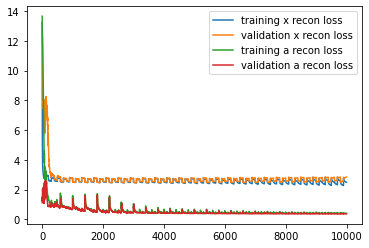

In [8]:
# plt.plot(np.arange(epochs),train_loss_ep)
# plt.plot(np.arange(epochs),val_loss_ep)
plt.plot(np.arange(epochs),train_loss_x_ep)
plt.plot(np.arange(epochs),val_loss_x_ep)
plt.plot(np.arange(epochs),train_loss_a_ep)
plt.plot(np.arange(epochs),val_loss_a_ep)
# plt.plot(np.arange(epochs),train_loss_kl_ep)
# plt.plot(np.arange(epochs),np.array(train_loss_adv_ep)*advWeight)
# plt.plot(np.arange(epochs),np.array(val_loss_adv_ep)*advWeight)
# plt.plot(np.arange(epochs),np.array(train_loss_advD_ep)*advWeight)
# plt.plot(np.arange(epochs),np.array(val_loss_advD_ep)*advWeight)
# plt.plot(np.arange(epochs),np.array(train_loss_clf_ep)*clfweight)
# plt.plot(np.arange(epochs),np.array(val_loss_clf_ep)*clfweight)
# plt.ylim((0,15))
# plt.xlim((0,3000))
# plt.legend(['training loss','validation loss','training x recon loss','validation x recon loss','training kl loss'],loc='upper right')
# plt.legend(['training loss','validation loss','training x recon loss','validation x recon loss','training a recon loss','validation a recon loss','training kl loss','training classifier loss','validation classifier loss'],loc='upper right')
plt.legend(['training x recon loss','validation x recon loss','training a recon loss','validation a recon loss','training discriminator ae','validation discriminator ae','training discriminator d','validation discriminator d'],loc='upper right')
# plt.legend(['training loss','validation loss','training x recon loss','validation x recon loss','training a recon loss','validation a recon loss','training kl loss','training discriminator ae','validation discriminator ae','training discriminator d','validation discriminator d'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3_xa.jpg'))
plt.show()


In [14]:
# name='c13k20XA_07_dca'
# logsavepath='/mnt/xinyi/pamrats/log/train_gae_starmap/'+name
# with open(os.path.join(logsavepath,'val_loss_a'), 'rb') as output:
#     val_loss_a_ep=pickle.load(output)
# np.argmin(loss[:3280])
np.where(np.logical_not(np.isfinite(val_loss_ep[:])))
# val_loss_a_ep[1040]

(array([], dtype=int64),)

In [9]:
testepoch=9990
model.load_state_dict(torch.load(os.path.join(modelsavepath,str(testepoch)+'.pt')))
model.eval()
for s in sampleidx.keys():
    print(s)
    
    adj_norm=adjnormlist[s].cuda().float()
    adj_label=adj_list[s].cuda().float()
    features=featureslist[s+'X_'+training_sample_X].cuda().float()
    pos_weight=pos_weightlist[s]
    norm=normlist[s]
    
    if 'dca' in model_str:
        features_raw=features_raw_list[s+'X_raw'].cuda()
    num_nodes,num_features = features.shape
    maskpath=os.path.join(savedir,'trainMask',s+'_'+maskedgeName+'_seed'+str(seed)+'.pkl')
    if useSavedMaskedEdges and os.path.exists(maskpath):
#         print('opening saved')
        with open(maskpath, 'rb') as input:
            maskedgeres = pickle.load(input)
    else:
        # construct training, validation, and test sets
        maskedgeres= preprocessing.mask_nodes_edges(features.shape[0],testNodeSize=testNodes,valNodeSize=valNodes)
        with open(maskpath, 'wb') as output:
            pickle.dump(maskedgeres, output, pickle.HIGHEST_PROTOCOL)
    train_nodes_idx,val_nodes_idx,test_nodes_idx = maskedgeres
    
    if s in training_samples:
        test_nodes_idx_s=test_nodes_idx
    else:
        test_nodes_idx_s=torch.tensor(np.arange(num_nodes))
        
#     adj_decode=None
#     if adj_decodeName == 'gala':
#         adj_decode=preprocessing.preprocess_graph_sharp(adj)

    if adj_decodeName==None:
        adj_recon,mu,logvar,z, features_recon = model(features, adj_norm)
    else:
        adj_decode=adj_decode.cuda()
        adj_recon,mu,logvar,z, features_recon = model(features, adj_norm,adj_decode)
    if adv and (s in list(sampleLabellist_ae.keys())):
        sampleLabel_ae=sampleLabellist_ae[s].cuda().float()
        modelAdv.eval()
        advOut=modelAdv(z)
    if 'dca' in model_str:
        if 'NB' in name:
            loss_x_test=loss_x(features_recon, features,test_nodes_idx,XreconWeight)
        else:
            loss_x_test=loss_x(features_recon, features,test_nodes_idx_s,XreconWeight,ridgeL,features_raw)
    else:
        loss_x_test=loss_x(features_recon, features,test_nodes_idx_s,XreconWeight,mse)
    loss_a_test=loss_a(adj_recon, adj_label, pos_weight, norm,test_nodes_idx_s)
    loss_test = loss_x_test+loss_a_test
    
    if adv and (s in list(sampleLabellist_ae.keys())):
        loss_adv_test=loss_adv(advOut,sampleLabel_ae,test_nodes_idx)
        print('loss_adv_test: {:.4f}'.format(loss_adv_test.item()))
        
    print('test results',
          'loss_test: {:.4f}'.format(loss_test.item()),
          'loss_x_test: {:.4f}'.format(loss_x_test.item()),
          'loss_a_test: {:.4f}'.format(loss_a_test.item()))
#          'loss_adv_test: {:.4f}'.format(loss_adv_test.item()))
    if protein:
        test_nodes_idx_s_genes=torch.clone(test_nodes_idx_s)
        test_nodes_idx_s_genes[2112:]=0
        test_nodes_idx_s_proteins=torch.clone(test_nodes_idx_s)
        test_nodes_idx_s_proteins[:2112]=0
        if 'dca' in model_str:
            loss_genes_test=loss_x(features_recon, features,test_nodes_idx_s_genes,XreconWeight,ridgeL,features_raw)
            loss_proteins_test=loss_x(features_recon, features,test_nodes_idx_s_proteins,XreconWeight,ridgeL,features_raw)
        print('loss_x_genes: {:.4f}'.format(loss_genes_test.item()),
          'loss_x_proteins: {:.4f}'.format(loss_proteins_test.item()))
    if 'dca' in model_str:
        features_raw=features_raw.cpu()

   

disease13
test results loss_test: 3.3073 loss_x_test: 2.8884 loss_a_test: 0.4189
control13
test results loss_test: 3.1026 loss_x_test: 2.6967 loss_a_test: 0.4059
disease8
test results loss_test: 3.1646 loss_x_test: 2.7175 loss_a_test: 0.4471
control8
test results loss_test: 3.1413 loss_x_test: 2.7735 loss_a_test: 0.3679


In [12]:
y_true=features
y_true_raw=features_raw
preds=features_recon
mask=nodesmask=torch.tensor(np.arange(num_nodes))
reconWeight=20
eps = 1e-10

output,pi,theta,y_pred=preds
nb_case=optimizer.optimizer_nb(preds,y_true,mask,reconWeight,eps = 1e-10,ifmean=False)- torch.log(pi+eps)

zero_nb = torch.pow(theta/(theta+y_pred+eps), theta)
zero_case = -torch.log(pi + ((1.0-pi)*zero_nb)+eps)
result = torch.where(torch.lt(y_true_raw.cuda(), 1), zero_case, nb_case)

In [13]:
result[:8,:8]

tensor([[-0.0000e+00, 2.1077e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00],
        [1.1921e-07, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         1.1921e-07, -0.0000e+00],
        [1.7968e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 1.7740e+00,
         1.1915e+00, -0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         1.1921e-07, -0.0000e+00],
        [1.1921e-07, 1.1921e-07, 1.1921e-07, -0.0000e+00, 1.1921e-07, 1.1921e-07,
         1.1921e-07, 1.1921e-07],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         1.4272e+00, -0.0000e+00]], device='cuda:0', grad_fn=<Slic

In [14]:
features[:8,:8]

tensor([[-0.2504,  8.5853, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [ 5.5540, -0.1938, -0.1941, -0.1474, -0.1934,  3.1612,  1.2601, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717,  2.5718, -0.3465]],
       device='cuda:0')

In [15]:
zeroidx=(features_raw==0)
nonzeroidx=(features_raw!=0)
torch.sum(result[zeroidx])/torch.sum(result)

tensor(2.8589e-09, device='cuda:0', grad_fn=<DivBackward0>)

In [22]:
torch.sum(result[zeroidx])

tensor(0., device='cuda:0', grad_fn=<SumBackward0>)

In [1]:
# model.pi.weight[:8,:8]
model_str

NameError: name 'model_str' is not defined